# Influence LXe Rayleigh Scattering Length on the LCE

In [1]:
## Imports:

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline
import concurrent.futures

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from numpy import exp
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.patches as patches
import matplotlib.cbook as cbook
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
## Function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


def remove_duplicate(input_list, inputcritical_list): 
    final_list = []
    finalcritical_list = []
    for i in range(0, len(inputcritical_list)): 
        if inputcritical_list[i] not in finalcritical_list: 
            finalcritical_list.append(inputcritical_list[i]) 
            final_list.append(input_list[i])
    return final_list 

In [3]:
## PMT properties and physics:

QE_PMT0 = 0.325
QE_PMT1 = 0.3
QE_PMT2 = 0.3
QE_PMT3 = 0.3
QE_PMT4 = 0.3
QE_PMT5 = 0.3
QE_PMT6 = 0.3
QE_PMT7 = 0.3
QE_Bottom = QE_PMT0
QE_Top = 0.3

CE_PMT0 = 0.95
CE_PMT1 = 0.7
CE_PMT2 = 0.7
CE_PMT3 = 0.7
CE_PMT4 = 0.7
CE_PMT5 = 0.7
CE_PMT6 = 0.7
CE_PMT7 = 0.7
CE_Bottom = CE_PMT0
CE_Top = 0.7

W = 1/(1302.808447/32.1517) # 1/W = photons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/W  = '+str(1/W)+' ph/keV')
We = 1/(1045.457843/32.1517) # 1/W = electrons/keV @ 32.1517 keV, 500 V/cm, ER
print('1/We = '+str(1/We)+' e/keV')

W0 = 1/(2195.519/32.1517) # 1/W = photons/keV @ 32.1517 keV, 0.0001 V/cm, ER
print('1/W0  = '+str(1/W0)+' ph/keV')

1/W  = 40.52067066438166 ph/keV
1/We = 32.51640949001141 e/keV
1/W0  = 68.28624924965087 ph/keV


## Imports and data processing

In [4]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Simulation_Data/LCE/*.root
#! ls ../../Simulation_Data/Modification_Spacer_3/*.root
! ls /media/alex/TOSHIBA\ EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2/*.root

'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_100.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_10.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_15.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_20.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2/optPhot_S2_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs1000_Tmesh0.89770509_LXeRayScatterLength_30.root'
'/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_

In [5]:
b_preprocessed = True

if b_preprocessed == False:
    
    ## Selection of path with files to be analysed
    from os import listdir
    from os.path import isfile, join
    path = "/media/alex/TOSHIBA EXT/Simulation_Data/Influence_Optical_Parameters/LXeRayScatterLength/S2"
    files = [f for f in listdir(path) if isfile(join(path, f))]
    #files = files[0:3]

    ## Initialize empty dataframe
    opticals = pd.DataFrame({'RPTFE' : [], 'LXeAbs' : [], 'LXeRayScatterLength' : [], 'LCE_b' : [],'LCE_t' : [],'LCE_a' : []})

    counter = 0
    for file in files:

        ## Selection of file to be analyzed:
        #file = "optPhot_S1_1.0e+07_pmtGap4.5_RPTFE0.95_LXeAbs100.root"
        filename = path+"/"+file
        #filenameprefix = file[:-5]    
        #print(filenameprefix)

        ## Extraction of optical parameters from filename
        RPTFE = float(file[file.find("RPTFE")+5 : file.find("_", file.find("RPTFE")+5)])
        LXeAbs = float(file[file.find("LXeAbs")+6 : file.find("_", file.find("LXeAbs")+6)])
        LXeRayScatterLength = float(file[file.find("LXeRayScatterLength")+20 : file.find(".root")])

        ## Import as pandas dataframes and write to compressed dataframe
        branches= ['nbpmthits','ntpmthits'] # Be careful that the branches are also initilized in _chunk_collect
        executor = concurrent.futures.ThreadPoolExecutor(8)
        _chunk_collect = pd.DataFrame({'nbpmthits' : [],'ntpmthits' : []}) # Initialize empty data frame
        for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                               outputtype=pd.DataFrame, executor=executor):
            _chunk.columns=branches
            _chunk_collect = _chunk_collect.append(_chunk)
        LCE_b = _chunk_collect["nbpmthits"].mean()
        LCE_t = _chunk_collect["ntpmthits"].mean()
        LCE_a = LCE_b + LCE_t
        opticals = opticals.append(pd.DataFrame({'RPTFE' : [RPTFE], 'LXeAbs' : [LXeAbs], 'LXeRayScatterLength' : [LXeRayScatterLength], 'LCE_b' : [LCE_b],'LCE_t' : [LCE_t],'LCE_a' : [LCE_a]}), ignore_index=True)
        del(_chunk)
        del(_chunk_collect)
        
        counter += 1
        print(str(round(100*counter / len(files),1))+'%', end = ' ')

    ## Derive DE and LY
    opticals['DE_b'] = opticals['LCE_b'] * QE_Bottom * CE_Bottom
    opticals['DE_t'] = opticals['LCE_t'] * QE_Top * CE_Top
    opticals['DE_a'] = opticals['DE_b'] + opticals['DE_t']
    opticals['LY_b'] = opticals['DE_b']/W
    opticals['LY_t'] = opticals['DE_t']/W
    opticals['LY_a'] = opticals['LY_b'] + opticals['LY_t']
    opticals['LY0_b'] = opticals['DE_b']/W0
    opticals['LY0_t'] = opticals['DE_t']/W0
    opticals['LY0_a'] = opticals['LY0_b'] + opticals['LY0_t']

    ## Save to pickle file
    opticals.to_pickle("Influence_LXeRayScatterLength_S2.pkl")

if b_preprocessed == True:
    opticals = pd.read_pickle("proc/Influence_LXeRayScatterLength_S2.pkl")

print('Done.')
opticals

Done.


RPTFE  LXeAbs  LXeRayScatterLength     LCE_b     LCE_t     LCE_a  \
0    0.95   100.0                 10.0  0.114360  0.135274  0.249634   
1    0.99   100.0                 10.0  0.129293  0.143059  0.272352   
2    0.95  1000.0                 10.0  0.135807  0.138114  0.273921   
3    0.95  1000.0                100.0  0.172379  0.129432  0.301811   
4    0.95  1000.0                 15.0  0.147423  0.135245  0.282669   
5    0.95  1000.0                 20.0  0.154288  0.133559  0.287847   
6    0.95  1000.0                 30.0  0.161614  0.132012  0.293626   
7    0.95  1000.0                  5.0  0.108154  0.144916  0.253070   
8    0.95  1000.0                 50.0  0.167594  0.130369  0.297963   
9    0.95   100.0                100.0  0.149544  0.127696  0.277240   
10   0.95   100.0                 15.0  0.125699  0.132641  0.258340   
11   0.95   100.0                 20.0  0.132035  0.131299  0.263334   
12   0.95   100.0                 30.0  0.139085  0.130063  0.269148   
13   0.95   100.0                  5.0  0.088399  0.141135  0.229534   
14   0.95   100.0                 50.0  0.144824  0.129020  0.273844   
15   0.99  1000.0                 10.0  0.155627  0.146641  0.302267   
16   0.99  1000.0                100.0  0.192893  0.136616  0.329509   
17   0.99  1000.0                 15.0  0.167613  0.143553  0.311166   
18   0.99  1000.0                 20.0  0.174277  0.141645  0.315922   
19   0.99  1000.0                 30.0  0.181661  0.139681  0.321342   
20   0.99  1000.0                  5.0  0.126765  0.154283  0.281048   
21   0.99  1000.0                 50.0  0.188040  0.138066  0.326107   
22   0.99   100.0                100.0  0.165323  0.134391  0.299714   
23   0.99   100.0                 15.0  0.140907  0.140418  0.281324   
24   0.99   100.0                 20.0  0.147438  0.138860  0.286297   
25   0.99   100.0                 30.0  0.154501  0.137057  0.291558   
26   0.99   100.0                  5.0  0.101921  0.149916  0.251837   
27   0.99   100.0                 50.0  0.160606  0.135512  0.296118   

        DE_b      DE_t      DE_a      LY_b      LY_t      LY_a     LY0_b  \
0   0.035309  0.028408  0.063716  1.430730  1.151092  2.581822  2.411095   
1   0.039919  0.030042  0.069962  1.617553  1.217337  2.834890  2.725933   
2   0.041931  0.029004  0.070934  1.699053  1.175256  2.874309  2.863279   
3   0.053222  0.027181  0.080403  2.156587  1.101384  3.257970  3.634323   
4   0.045517  0.028401  0.073918  1.844378  1.150848  2.995226  3.108183   
5   0.047636  0.028047  0.075684  1.930258  1.136500  3.066758  3.252910   
6   0.049898  0.027722  0.077621  2.021915  1.123334  3.145249  3.407371   
7   0.033393  0.030432  0.063825  1.353090  1.233140  2.586230  2.280254   
8   0.051745  0.027377  0.079122  2.096733  1.109354  3.206087  3.533456   
9   0.046172  0.026816  0.072988  1.870914  1.086609  2.957522  3.152901   
10  0.038810  0.027855  0.066664  1.572590  1.128685  2.701275  2.650160   
11  0.040766  0.027573  0.068338  1.651854  1.117267  2.769121  2.783738   
12  0.042942  0.027313  0.070256  1.740059  1.106748  2.846806  2.932382   
13  0.027293  0.029638  0.056932  1.105943  1.200962  2.306906  1.863758   
14  0.044714  0.027094  0.071809  1.811858  1.097876  2.909734  3.053379   
15  0.048050  0.030795  0.078844  1.947007  1.247816  3.194822  3.281135   
16  0.059556  0.028689  0.088245  2.413244  1.162509  3.575752  4.066847   
17  0.051751  0.030146  0.081897  2.096966  1.221545  3.318510  3.533848   
18  0.053808  0.029745  0.083553  2.180336  1.205306  3.385642  3.674346   
19  0.056088  0.029333  0.085421  2.272713  1.188595  3.461308  3.830021   
20  0.039139  0.032400  0.071538  1.585924  1.312851  2.898775  2.672630   
21  0.058057  0.028994  0.087051  2.352527  1.174854  3.527381  3.964525   
22  0.051043  0.028222  0.079265  2.068312  1.143579  3.211891  3.485561   
23  0.043505  0.029488  0.072993  1.762849  1.194860  2.957710  2.970789   
24  0.045521  0

In [6]:
plt.rcParams['axes.axisbelow'] = True

## Evaluation

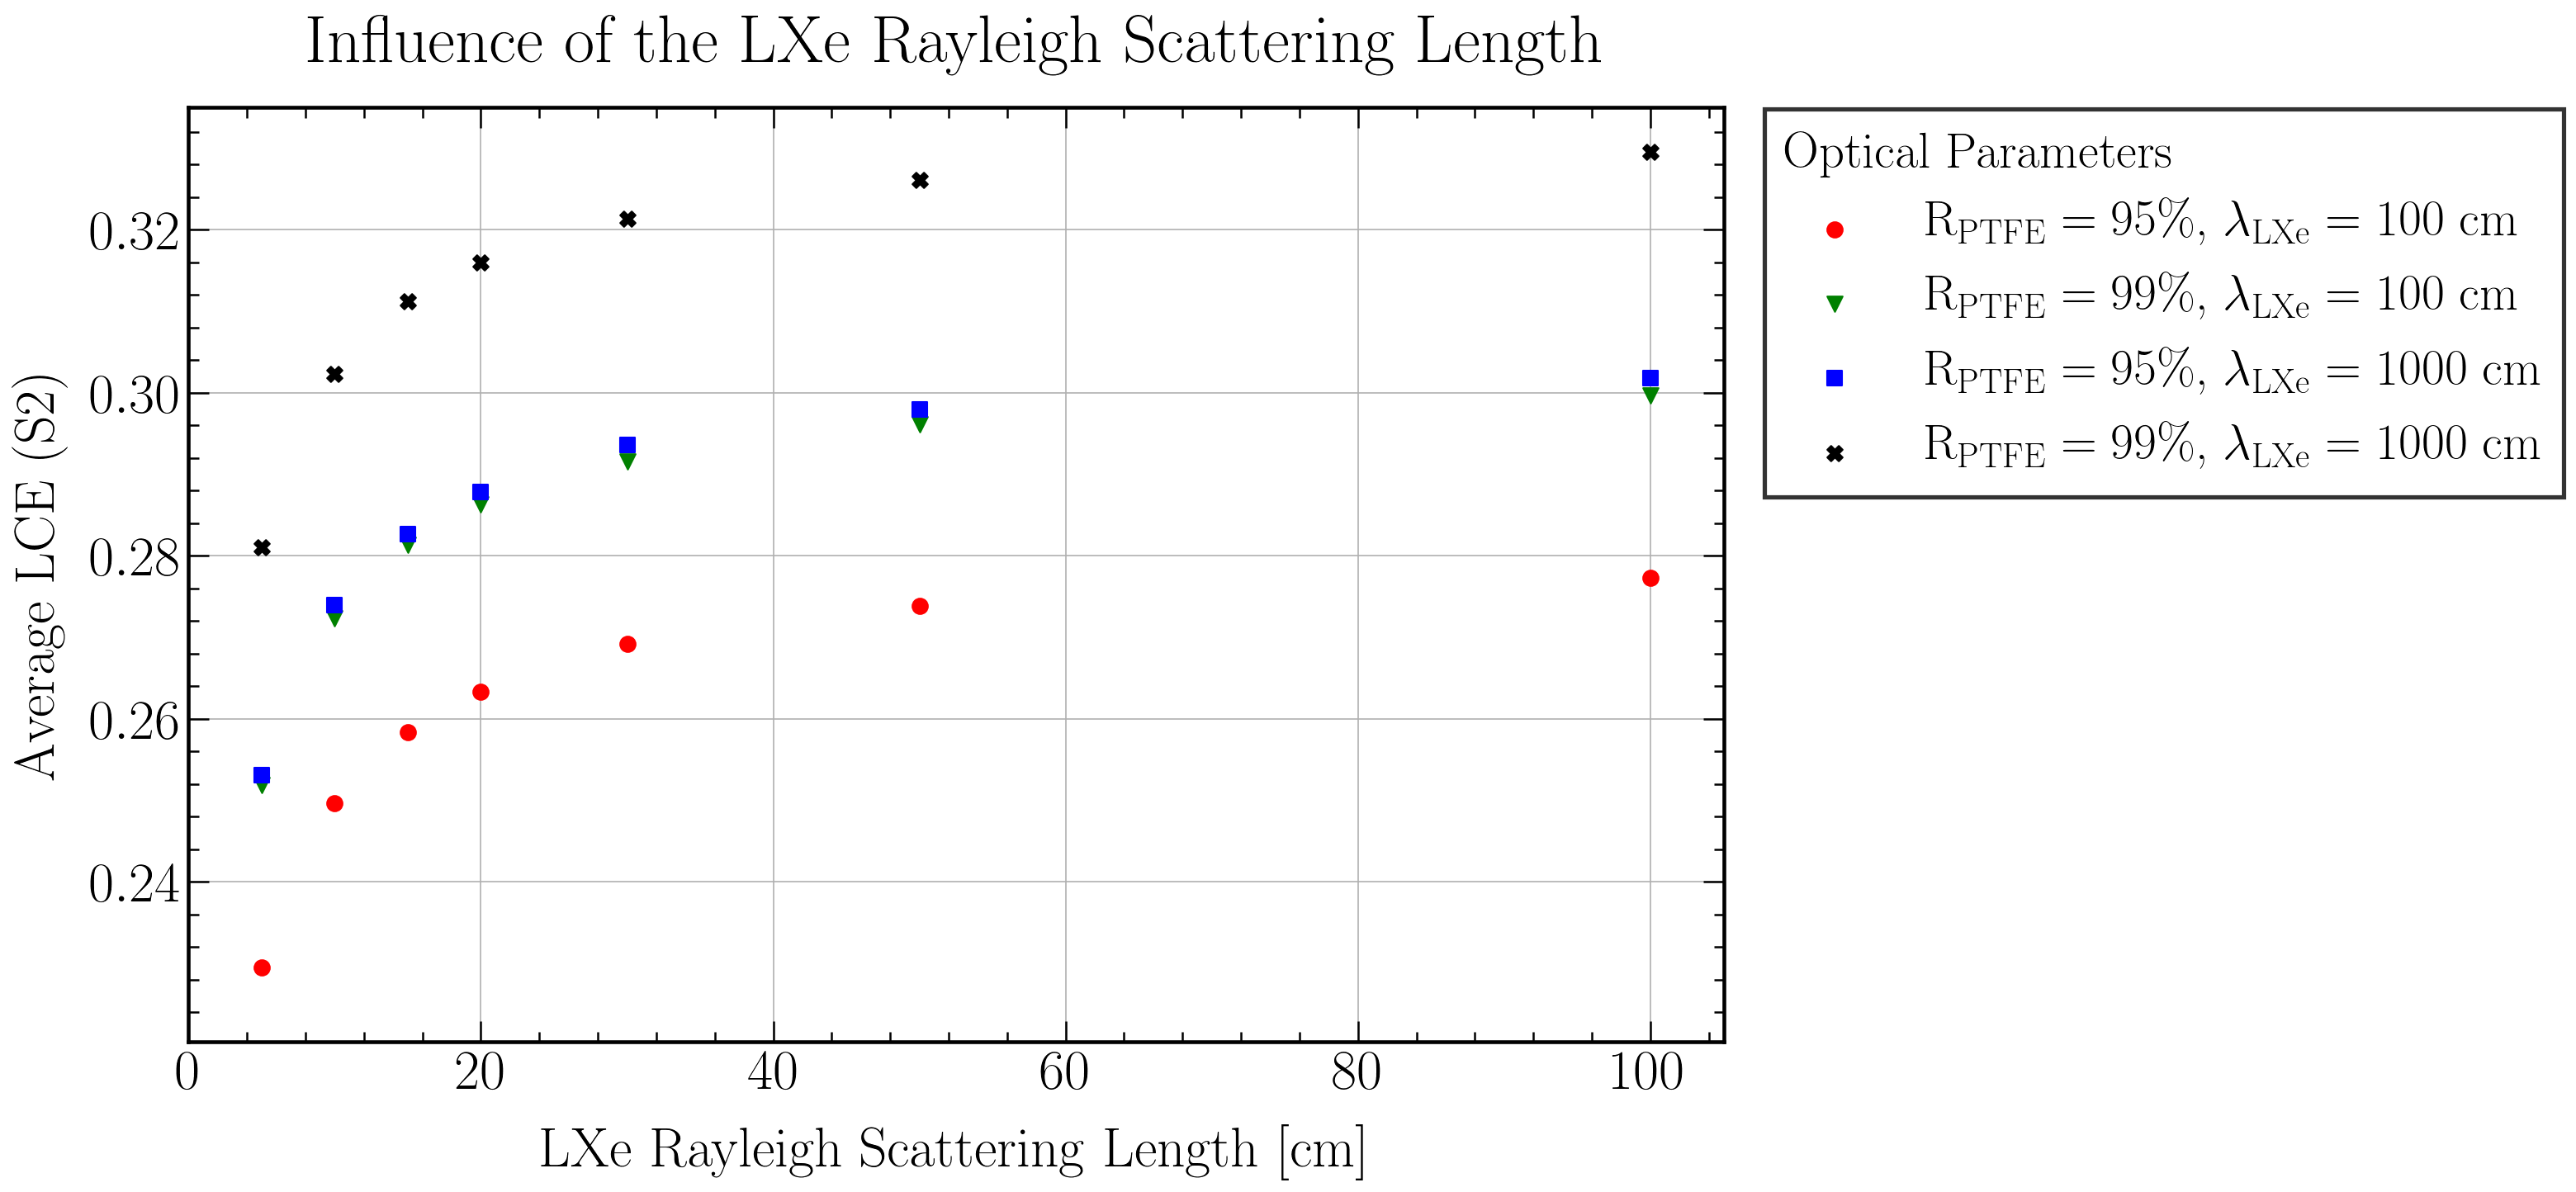

In [7]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_S2.png", bbox_inches='tight')
plt.show()

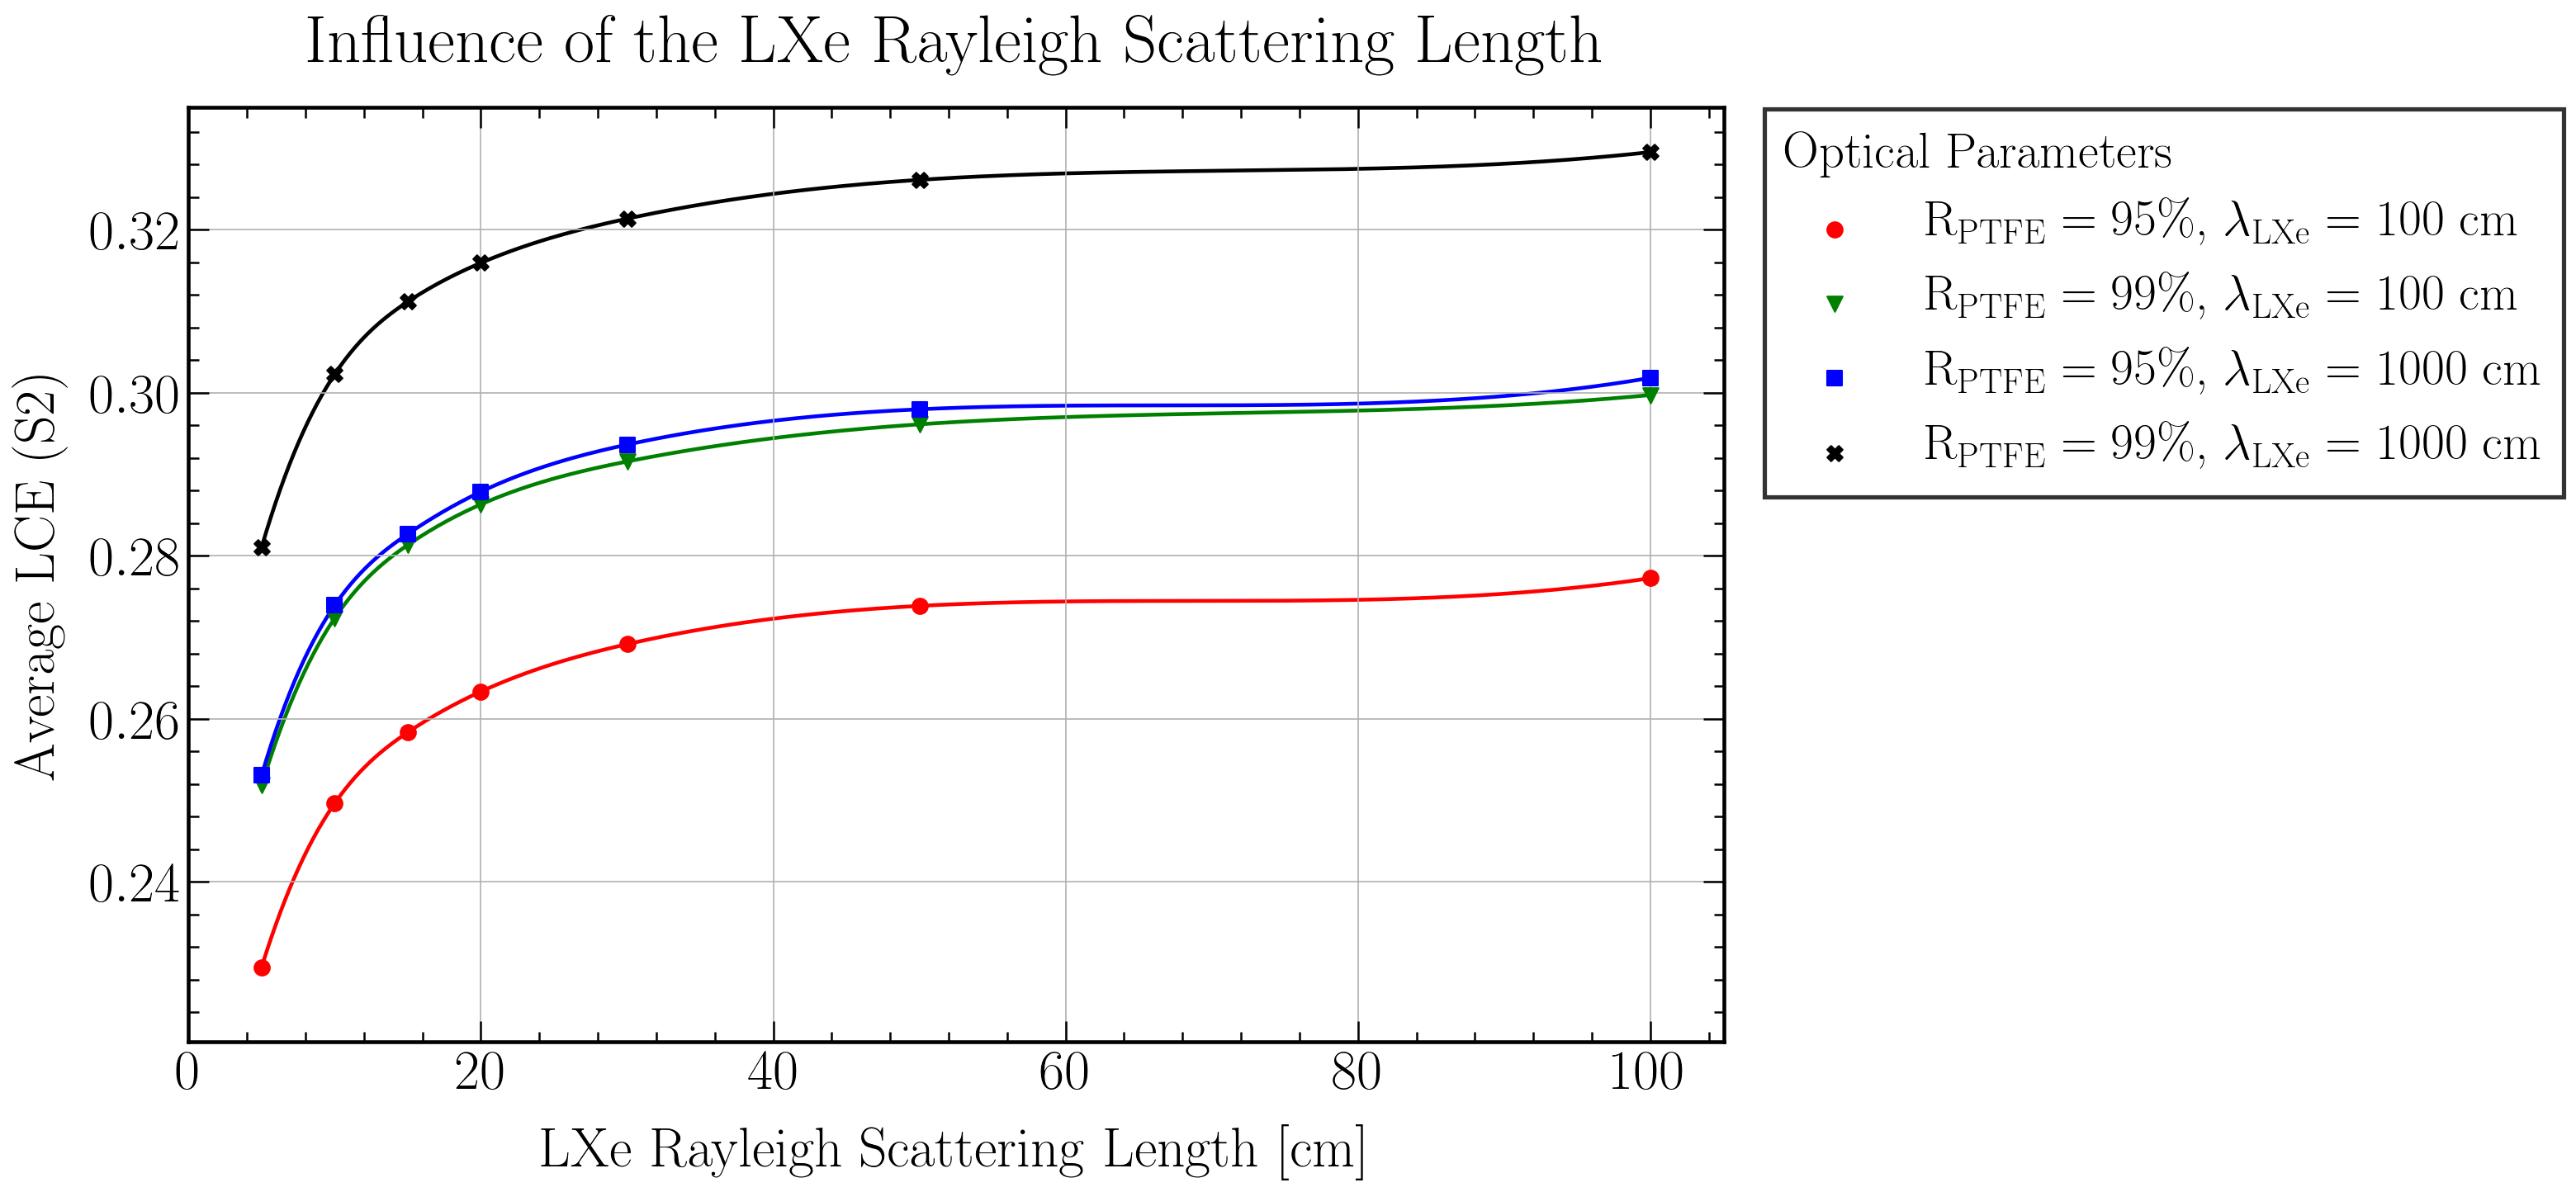

In [8]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_spline_S2.png", bbox_inches='tight')
plt.show()

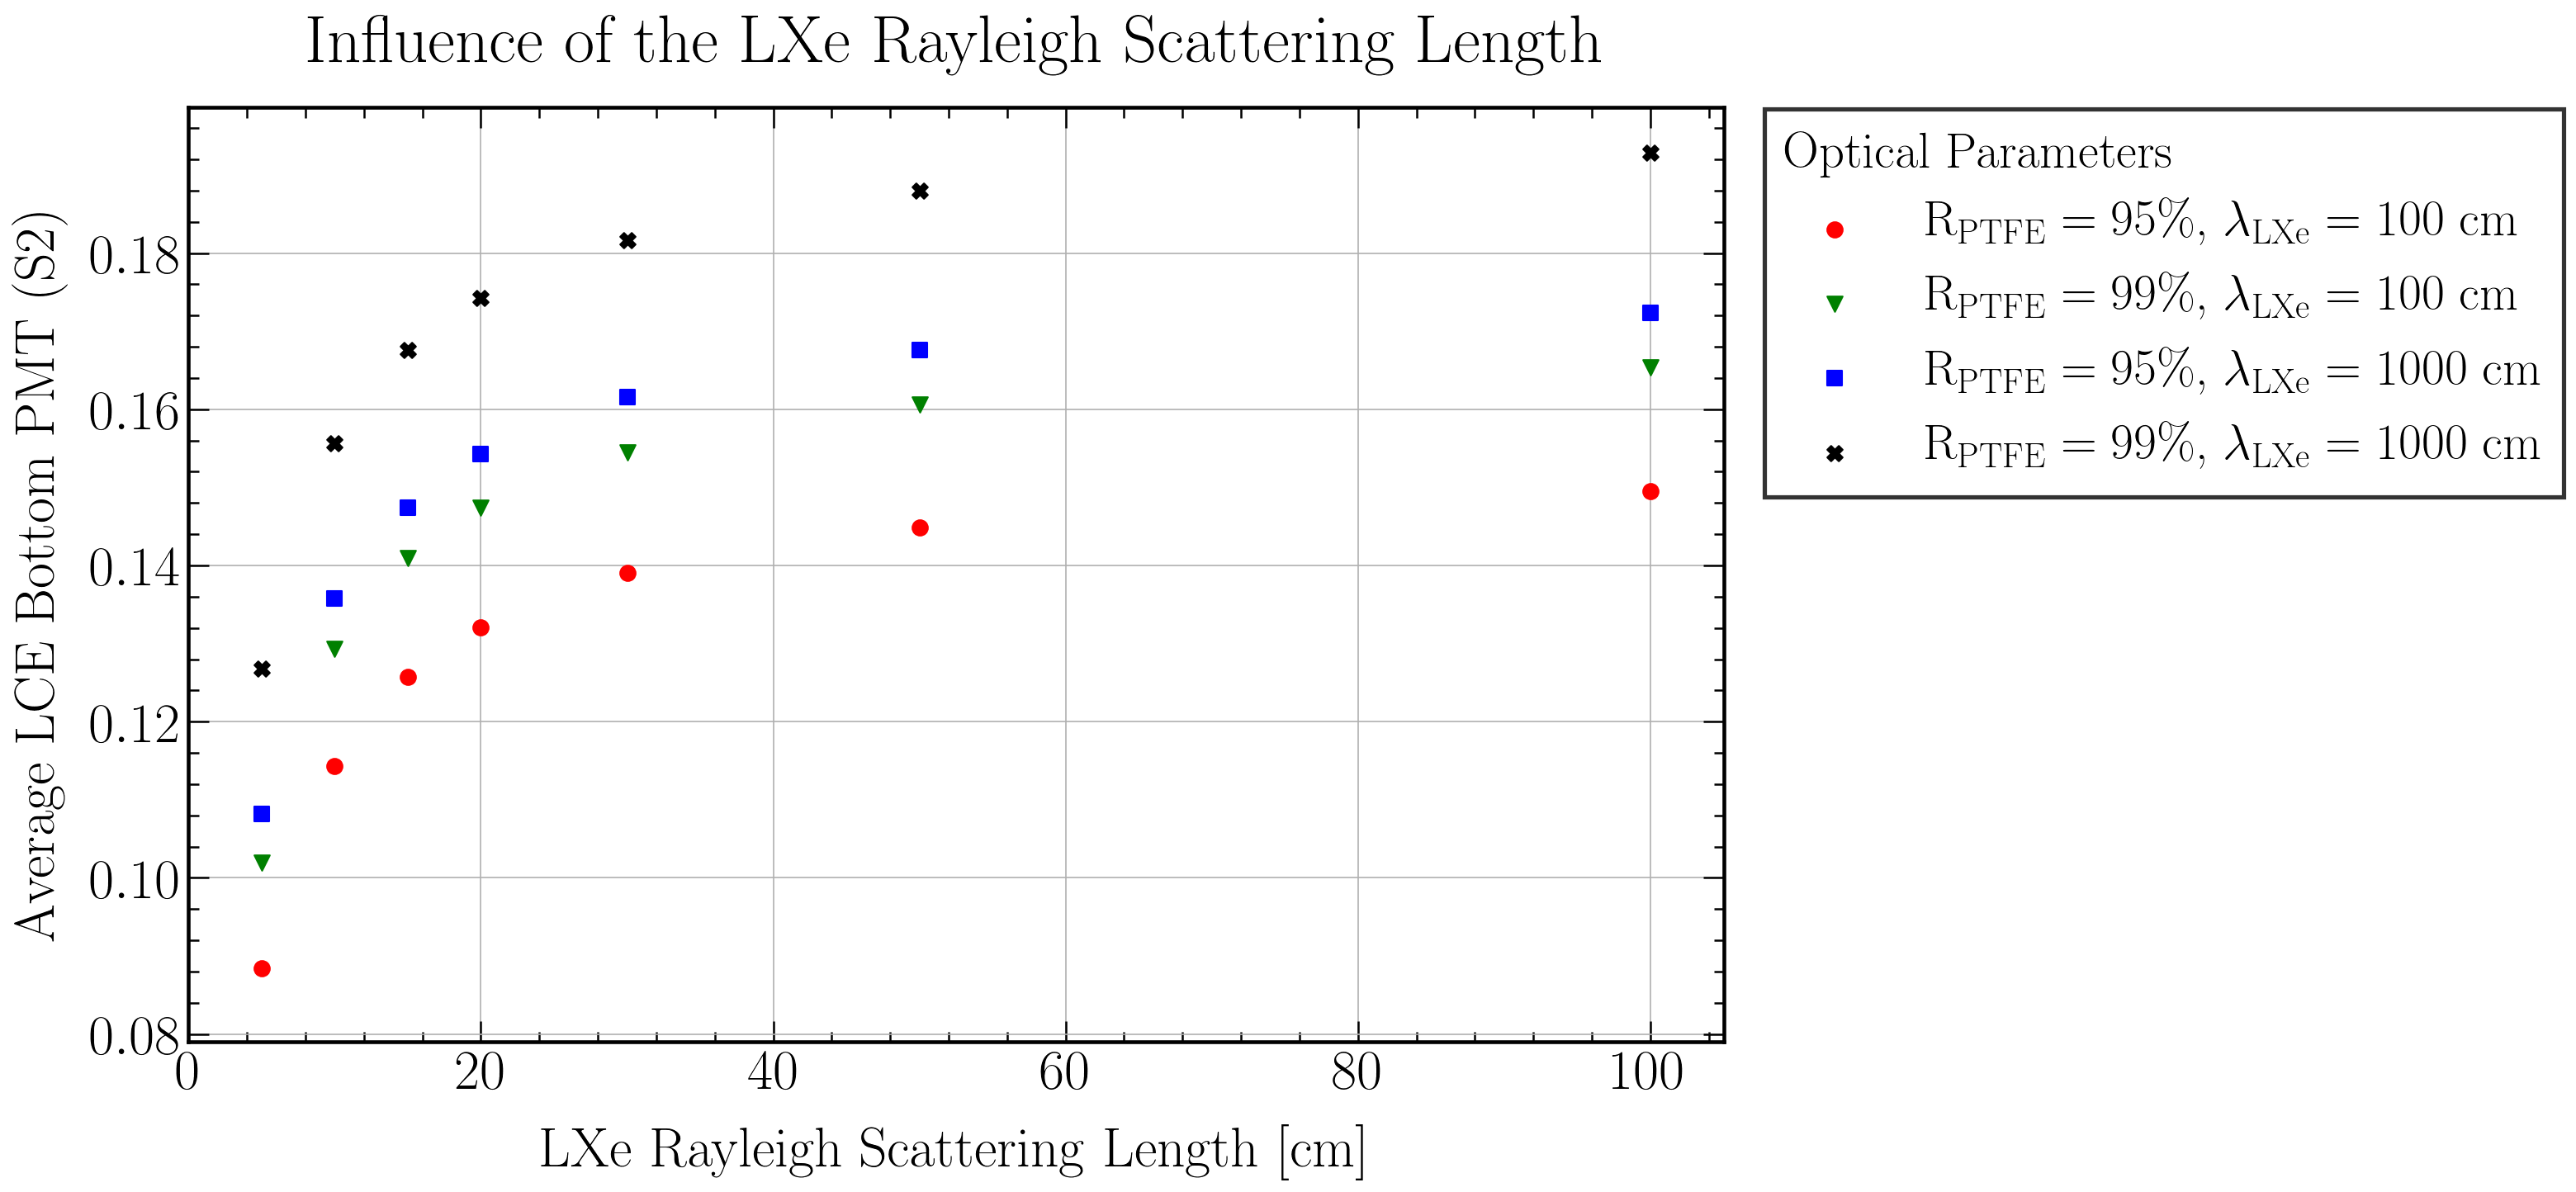

In [9]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_Bottom_S2.png", bbox_inches='tight')
plt.show()

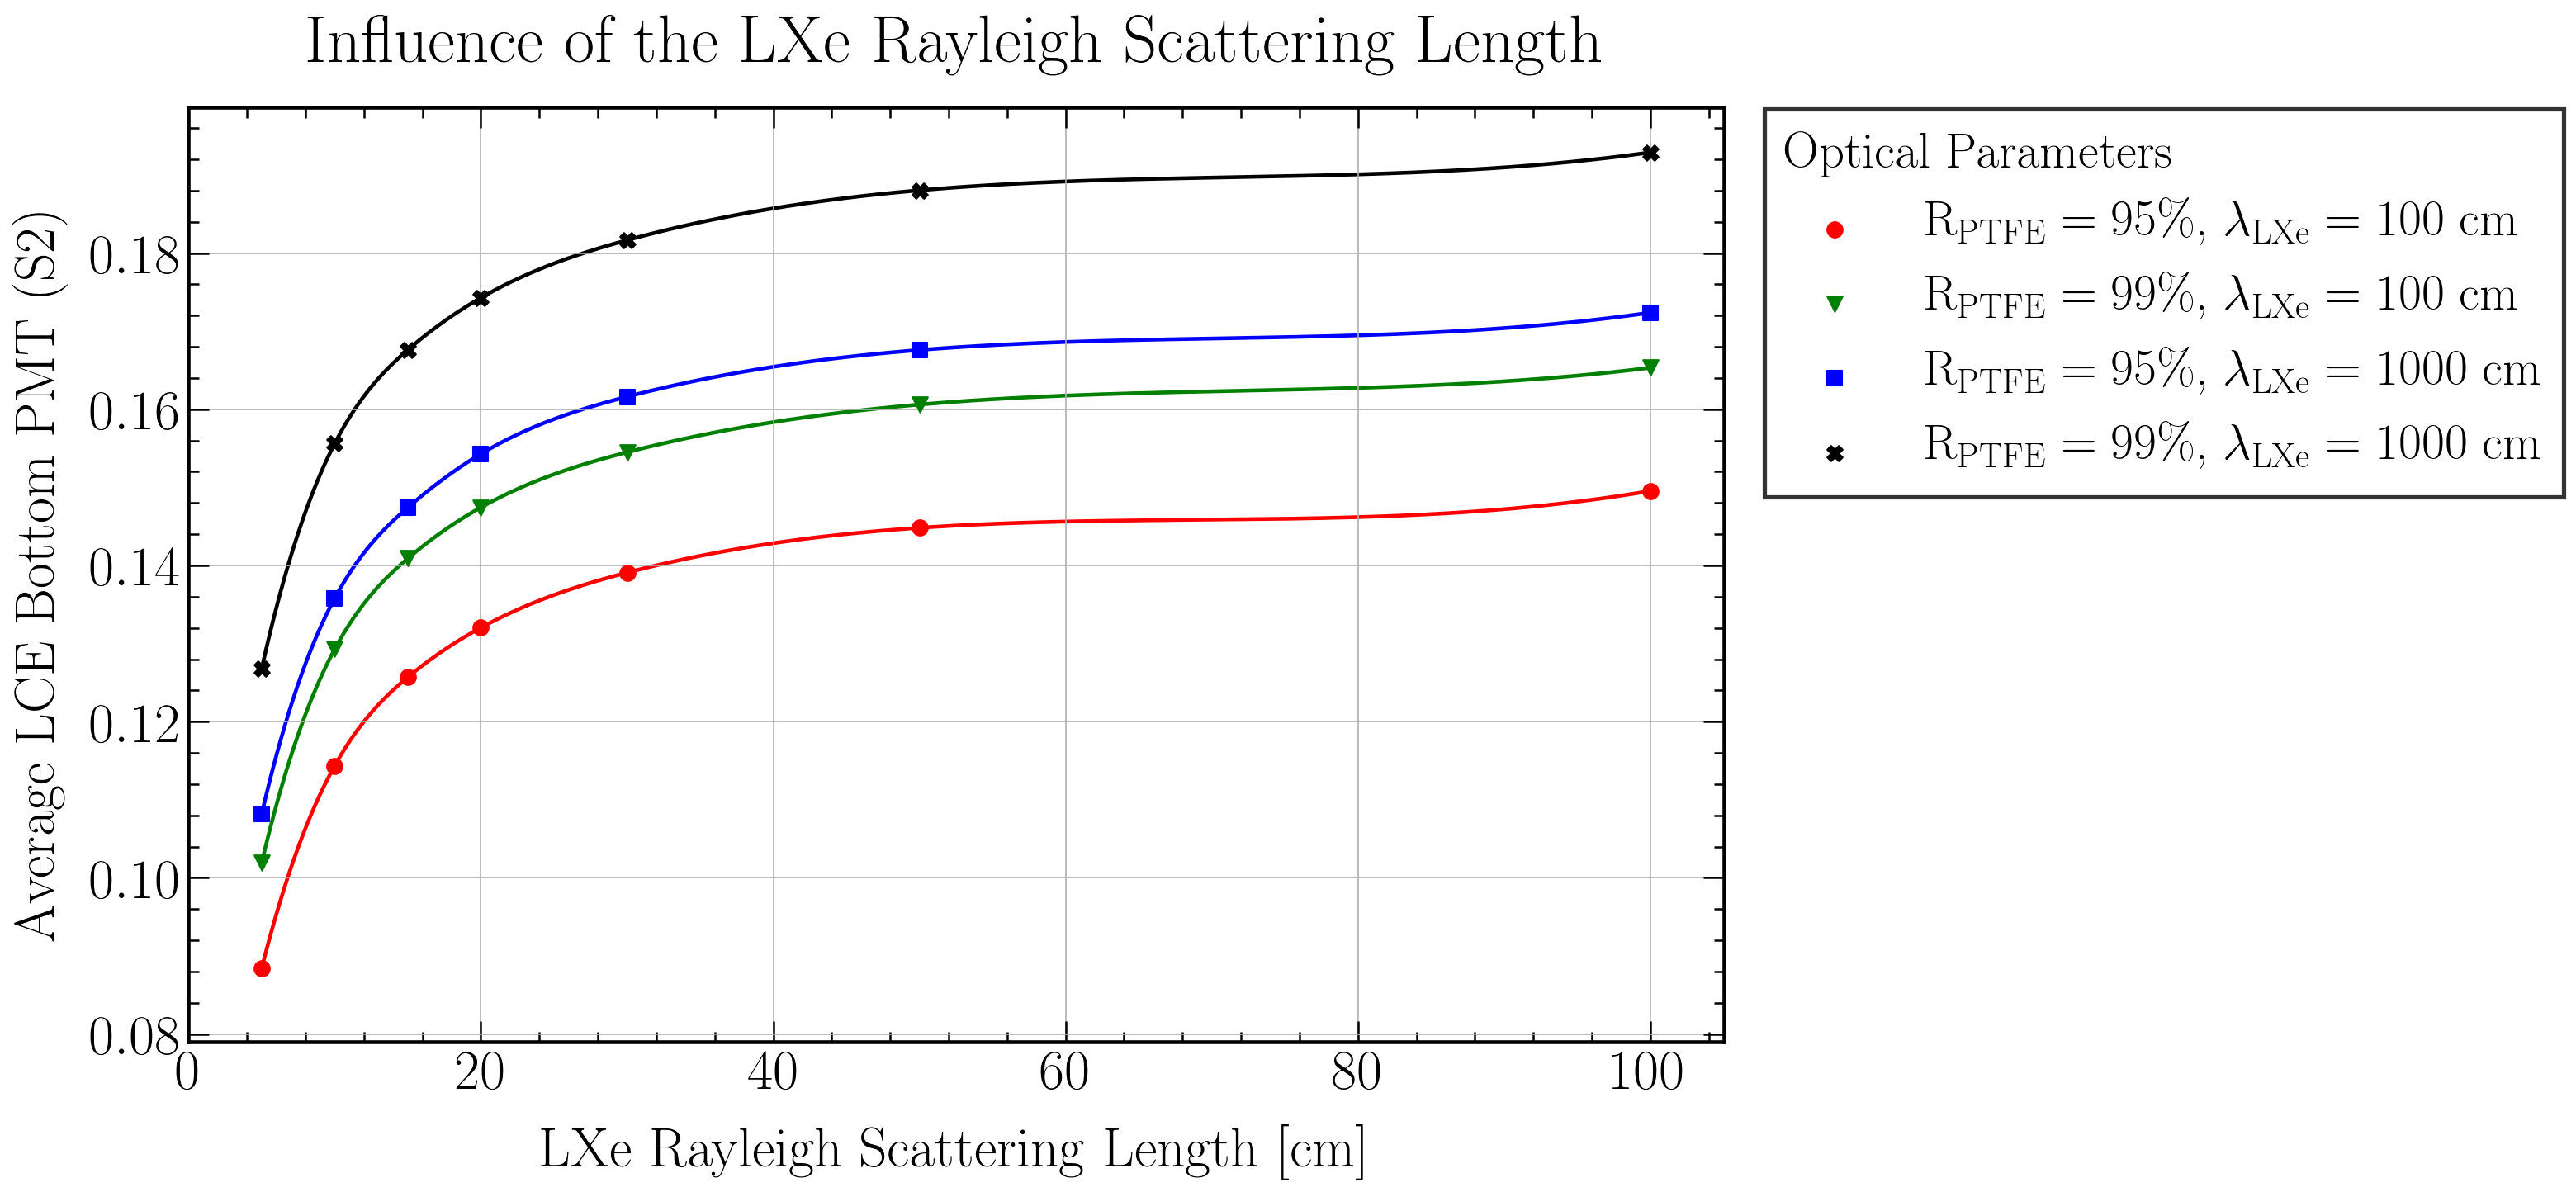

In [10]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

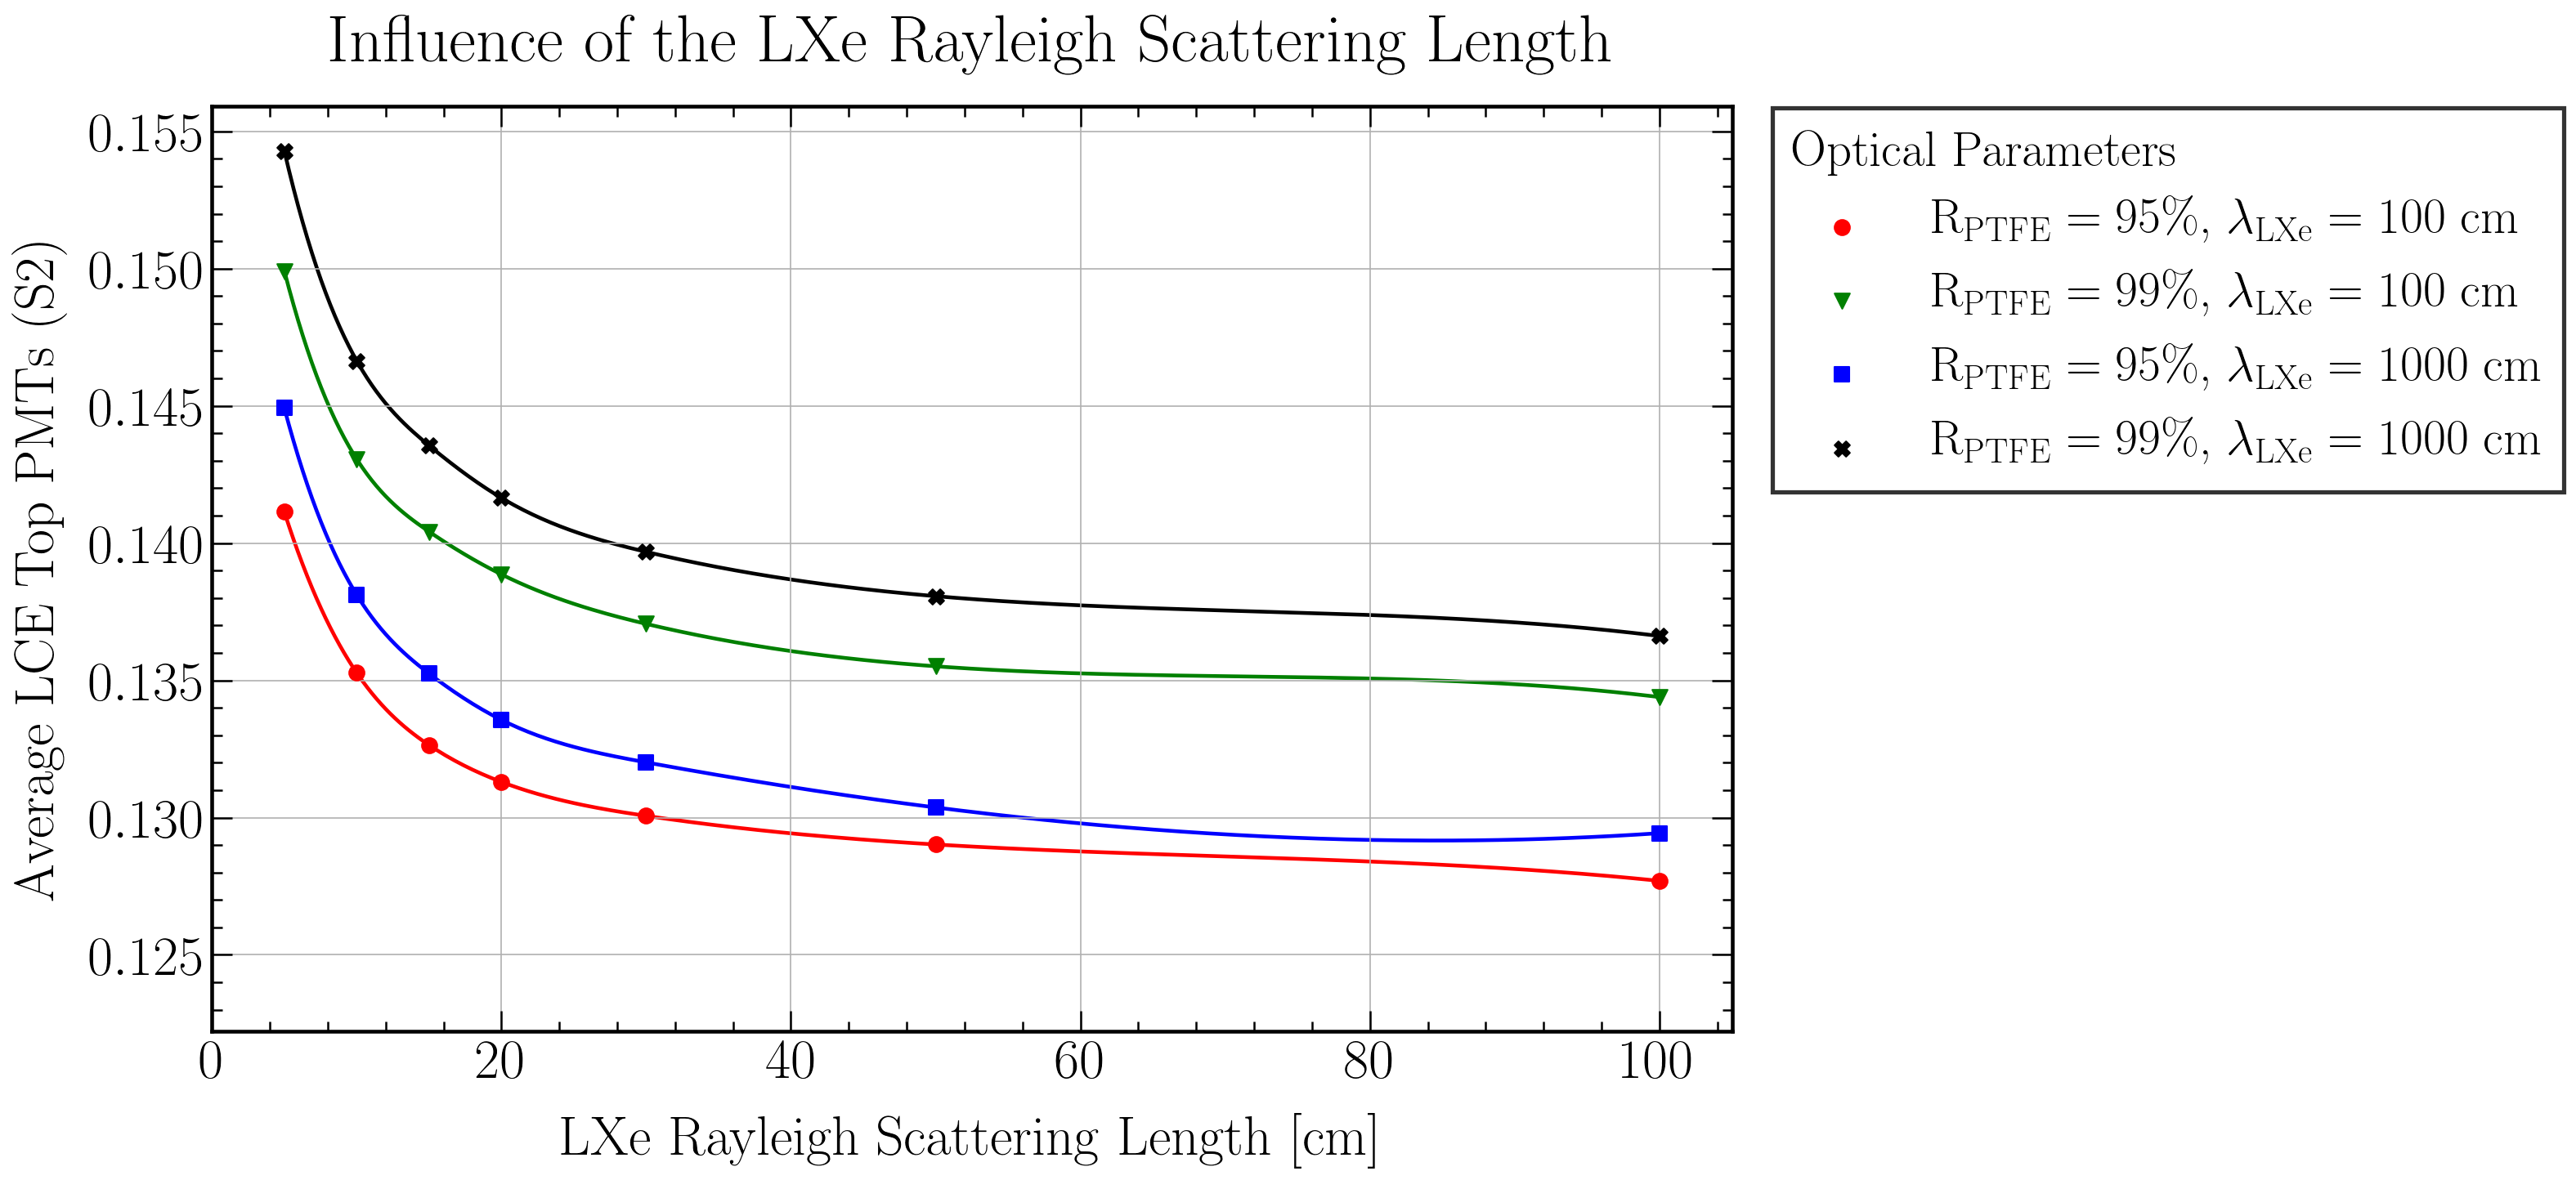

In [11]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LCE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LCE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LCE Top PMTs (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LCE_Top_spline_S2.png", bbox_inches='tight')
plt.show()

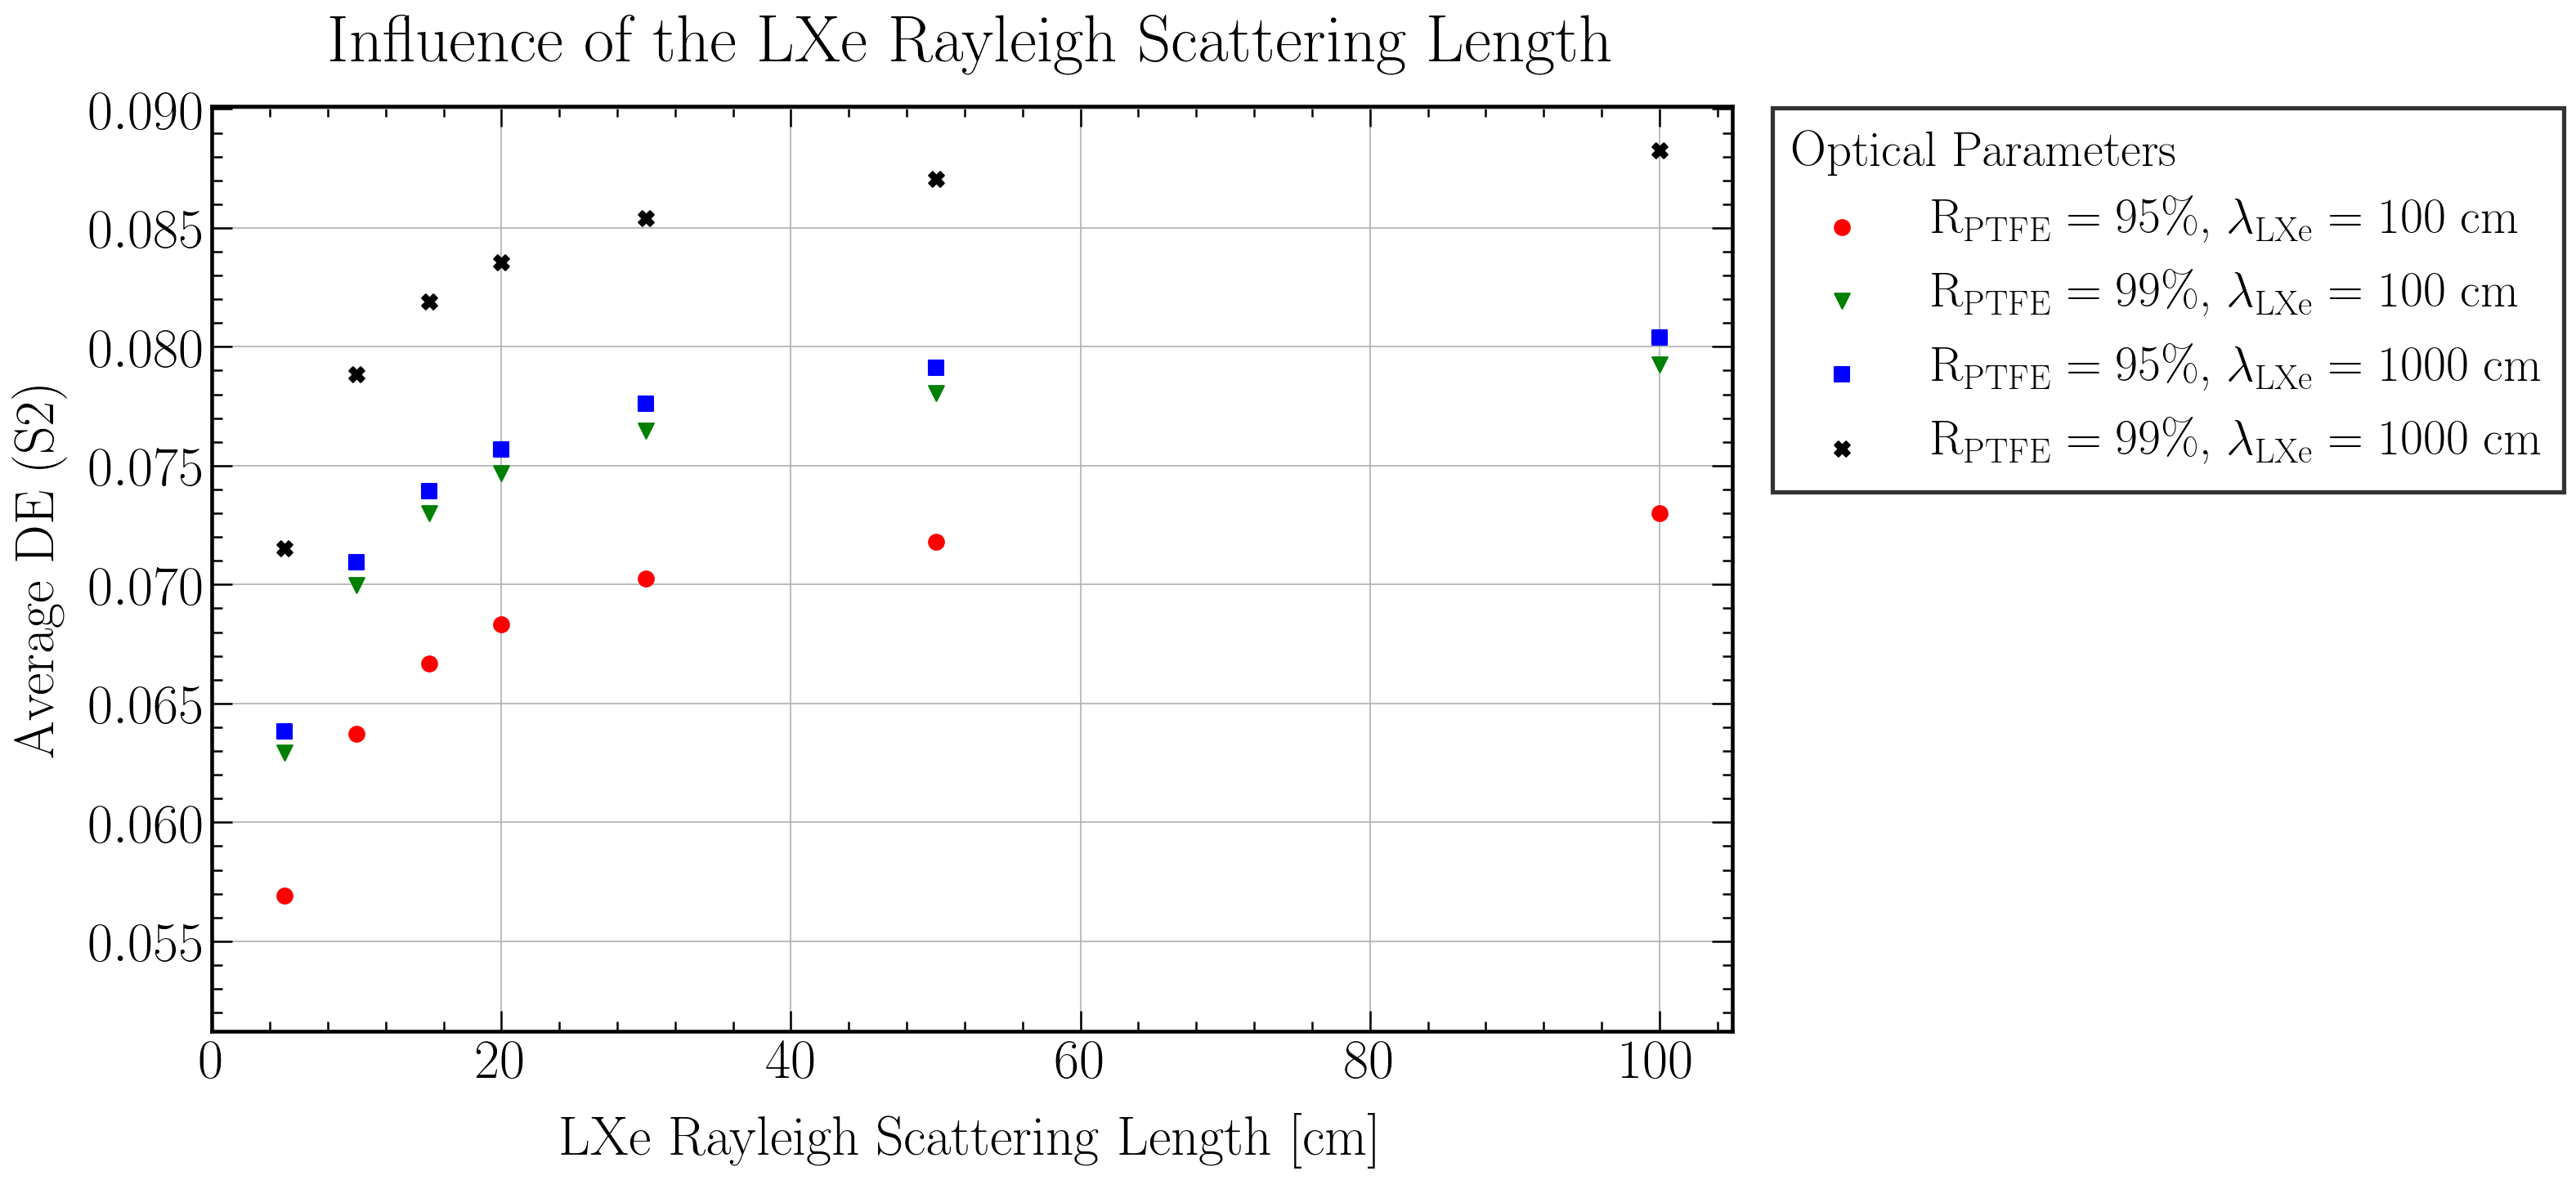

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_S2.png", bbox_inches='tight')
plt.show()

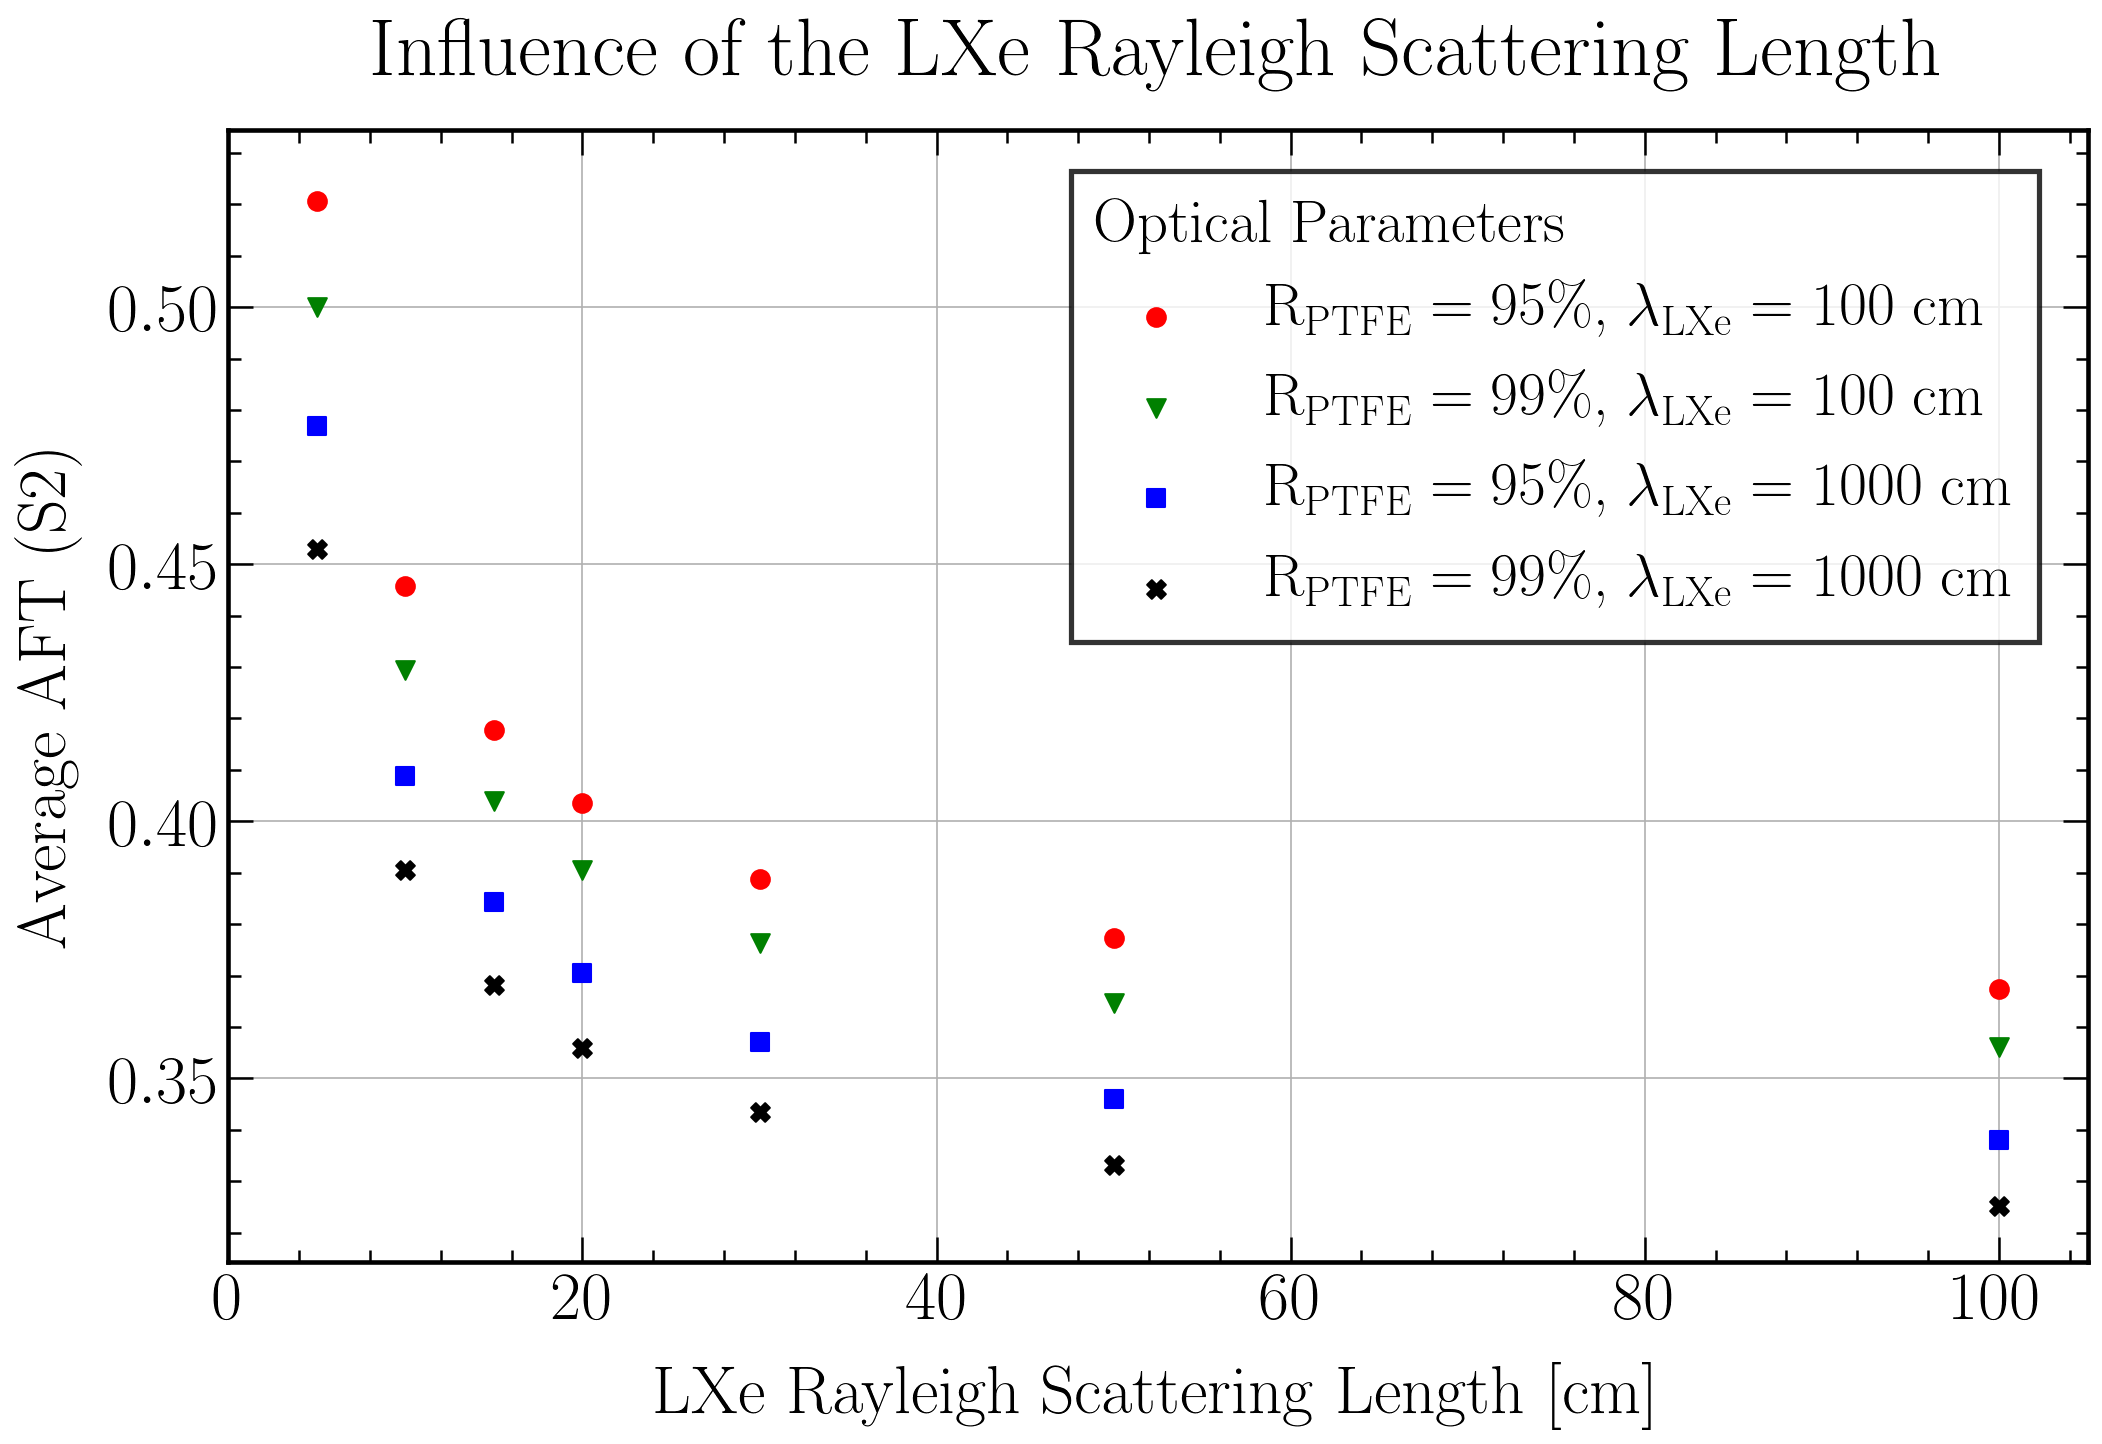

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_AFT_S2.png")
plt.show()

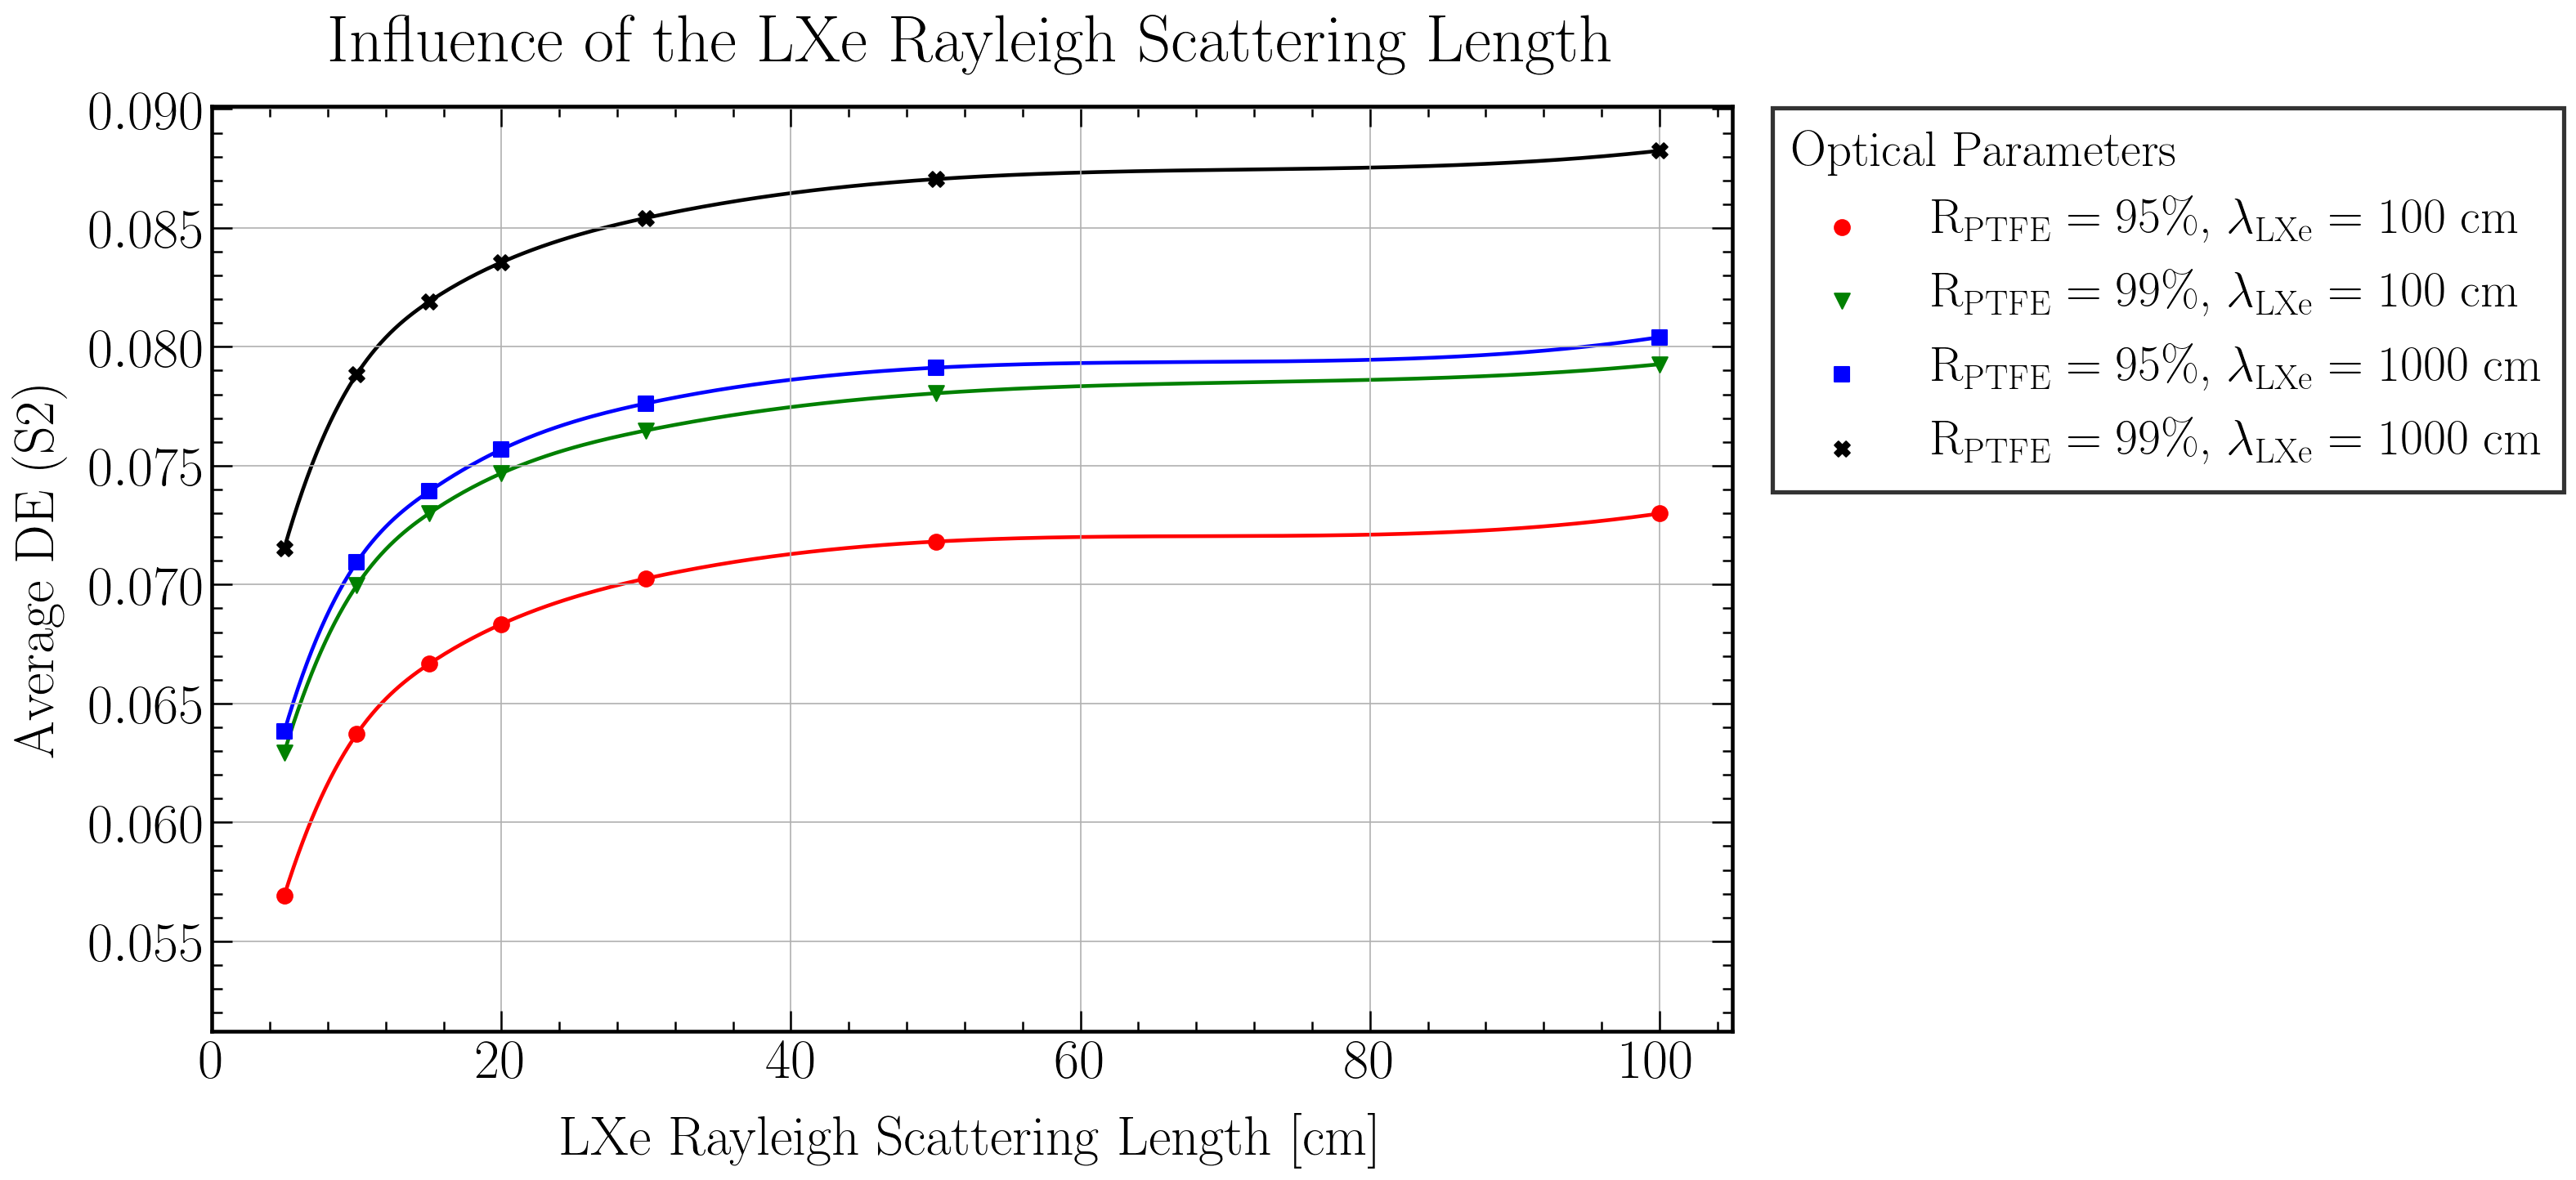

In [14]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_spline_S2.png", bbox_inches='tight')
plt.show()

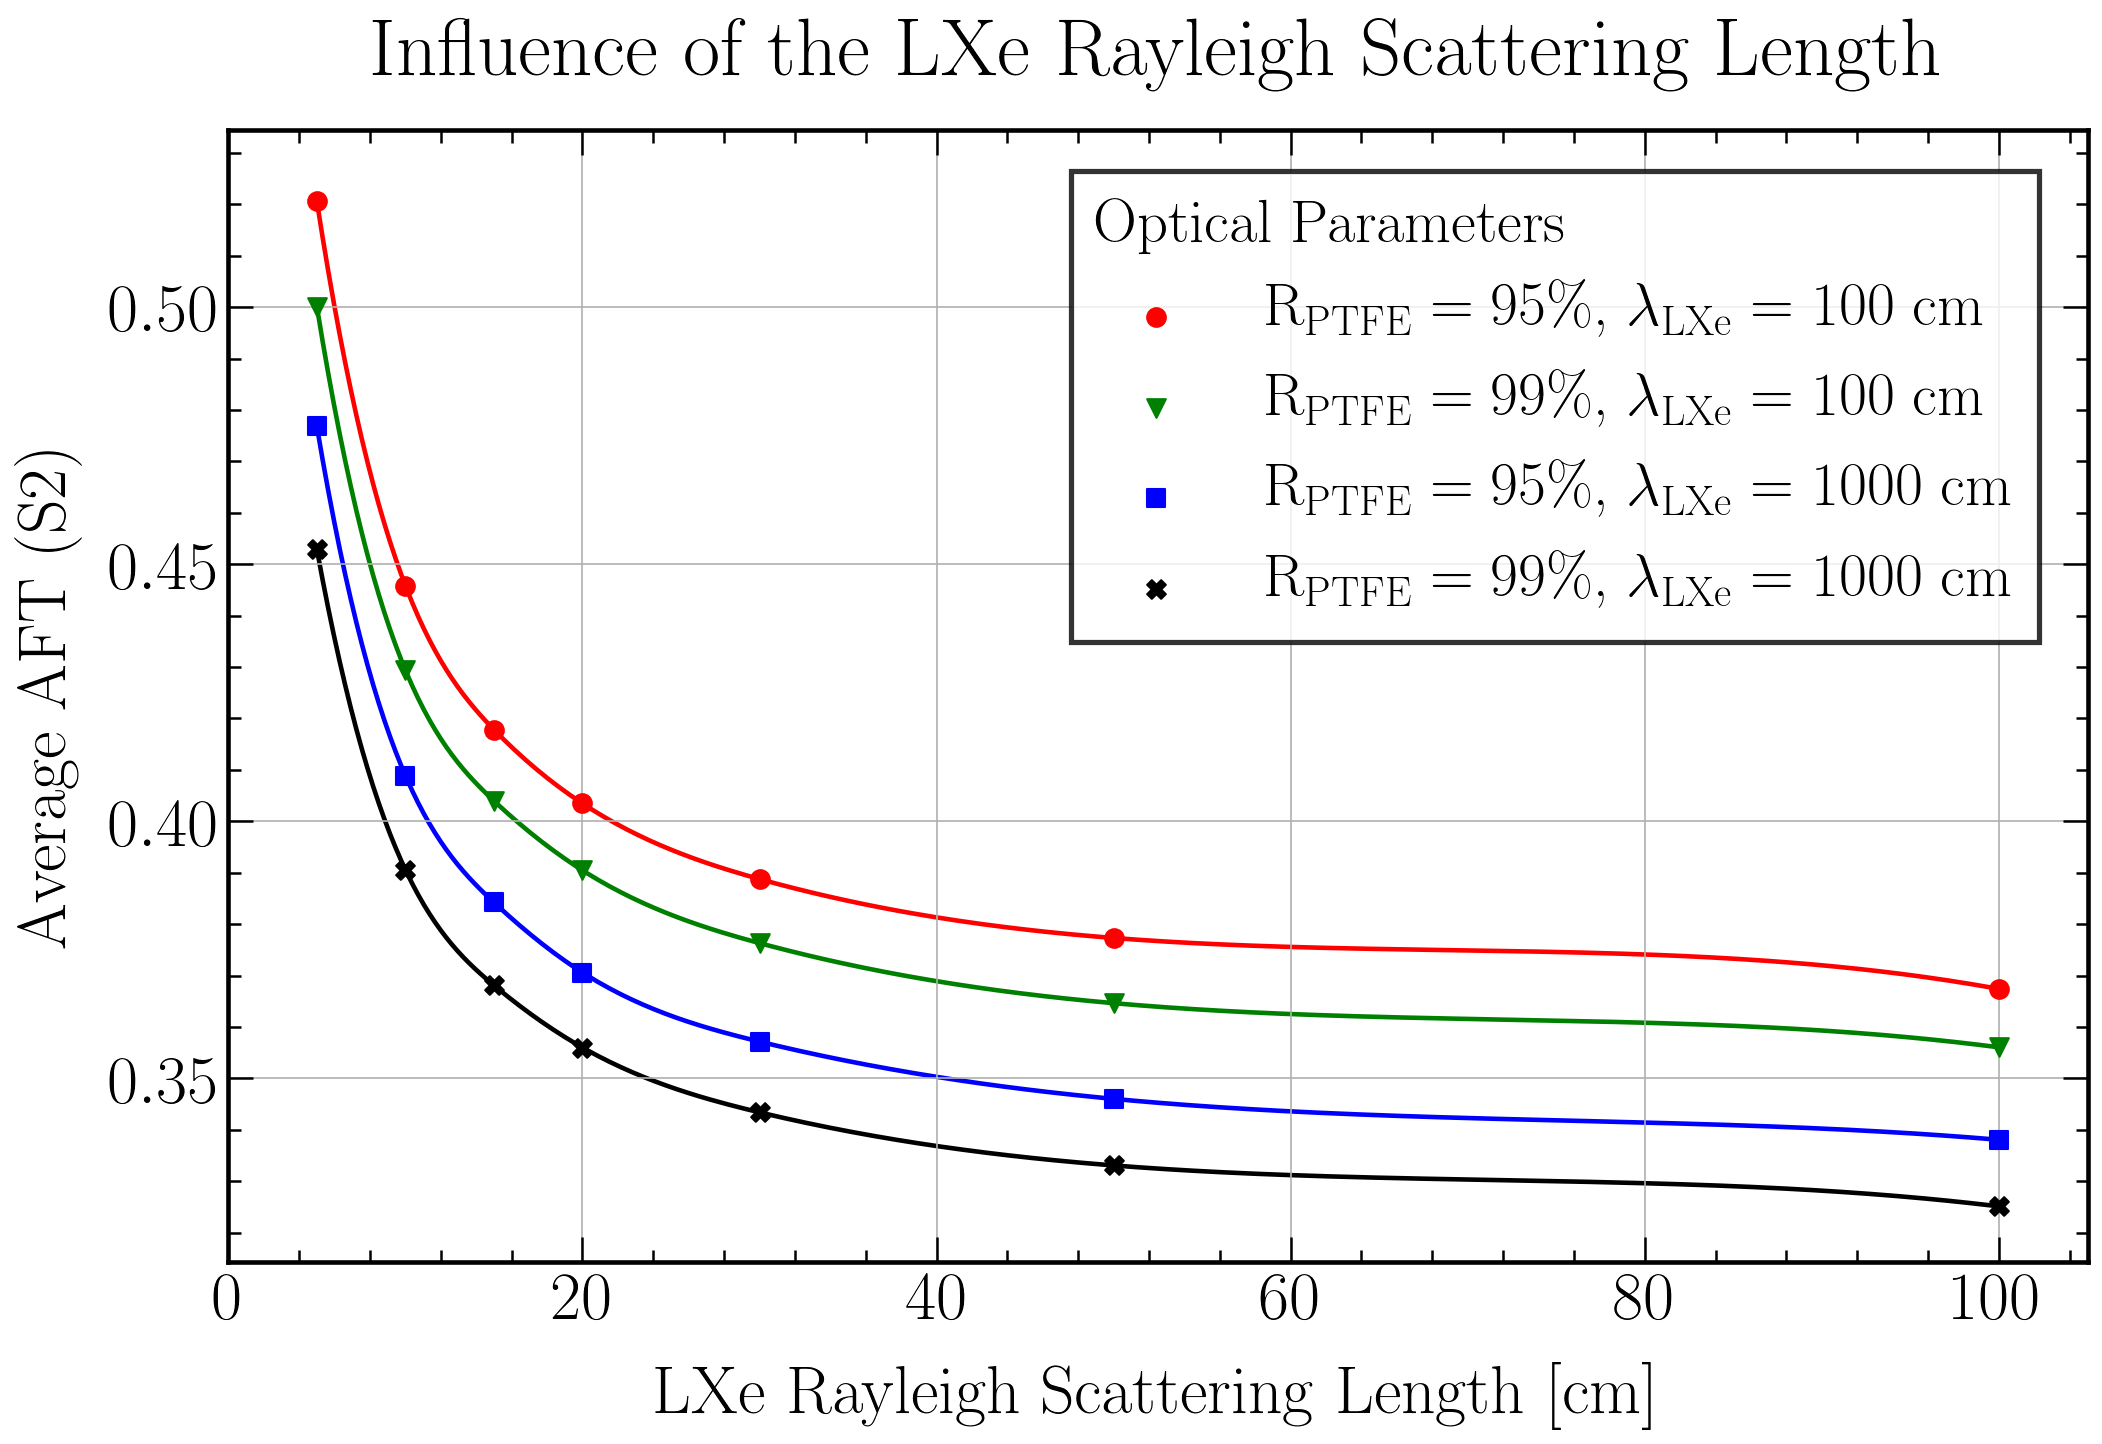

In [15]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)


plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_AFT_spline_S2.png")
plt.show()

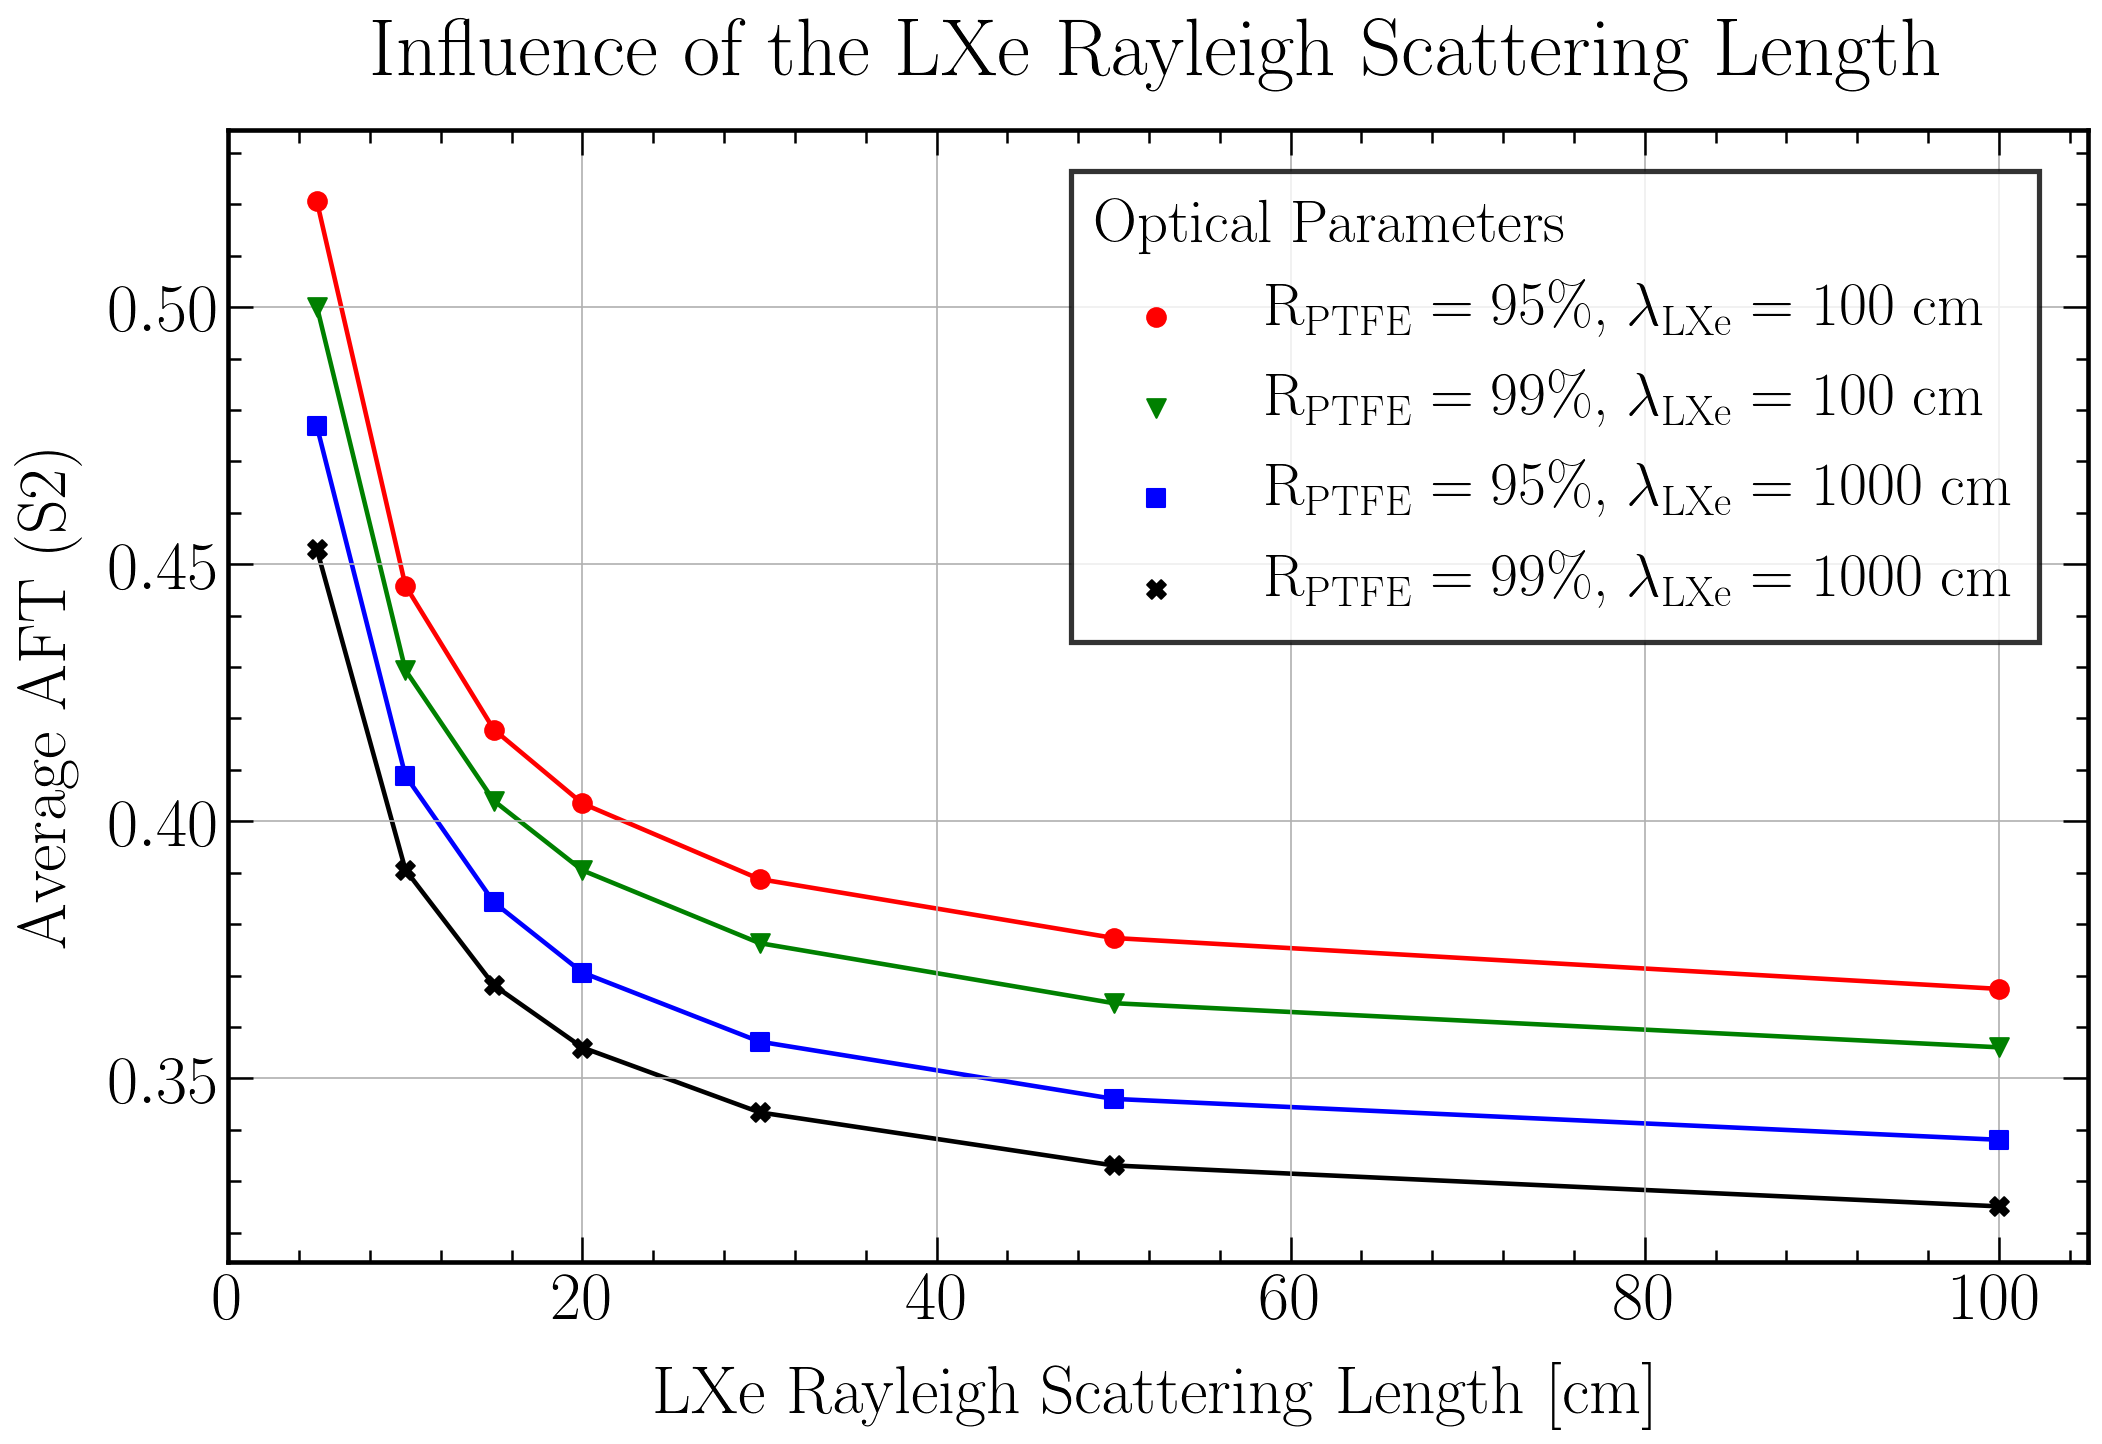

In [16]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'red', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'green', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'blue', zorder=0)


x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = (opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])/(opticals["DE_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)])
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xr = np.array(xr)[~np.isnan(np.array(yr))]
yr = np.array(yr)[~np.isnan(np.array(yr))]
yr = np.array([v for _,v in sorted(zip(xr,yr))])
xr = np.array(sorted(xr))
plt.plot(xr, yr, linewidth = 2.2, color = 'black', zorder=0)


plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average AFT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_AFT_spline2_S2.png")
plt.show()

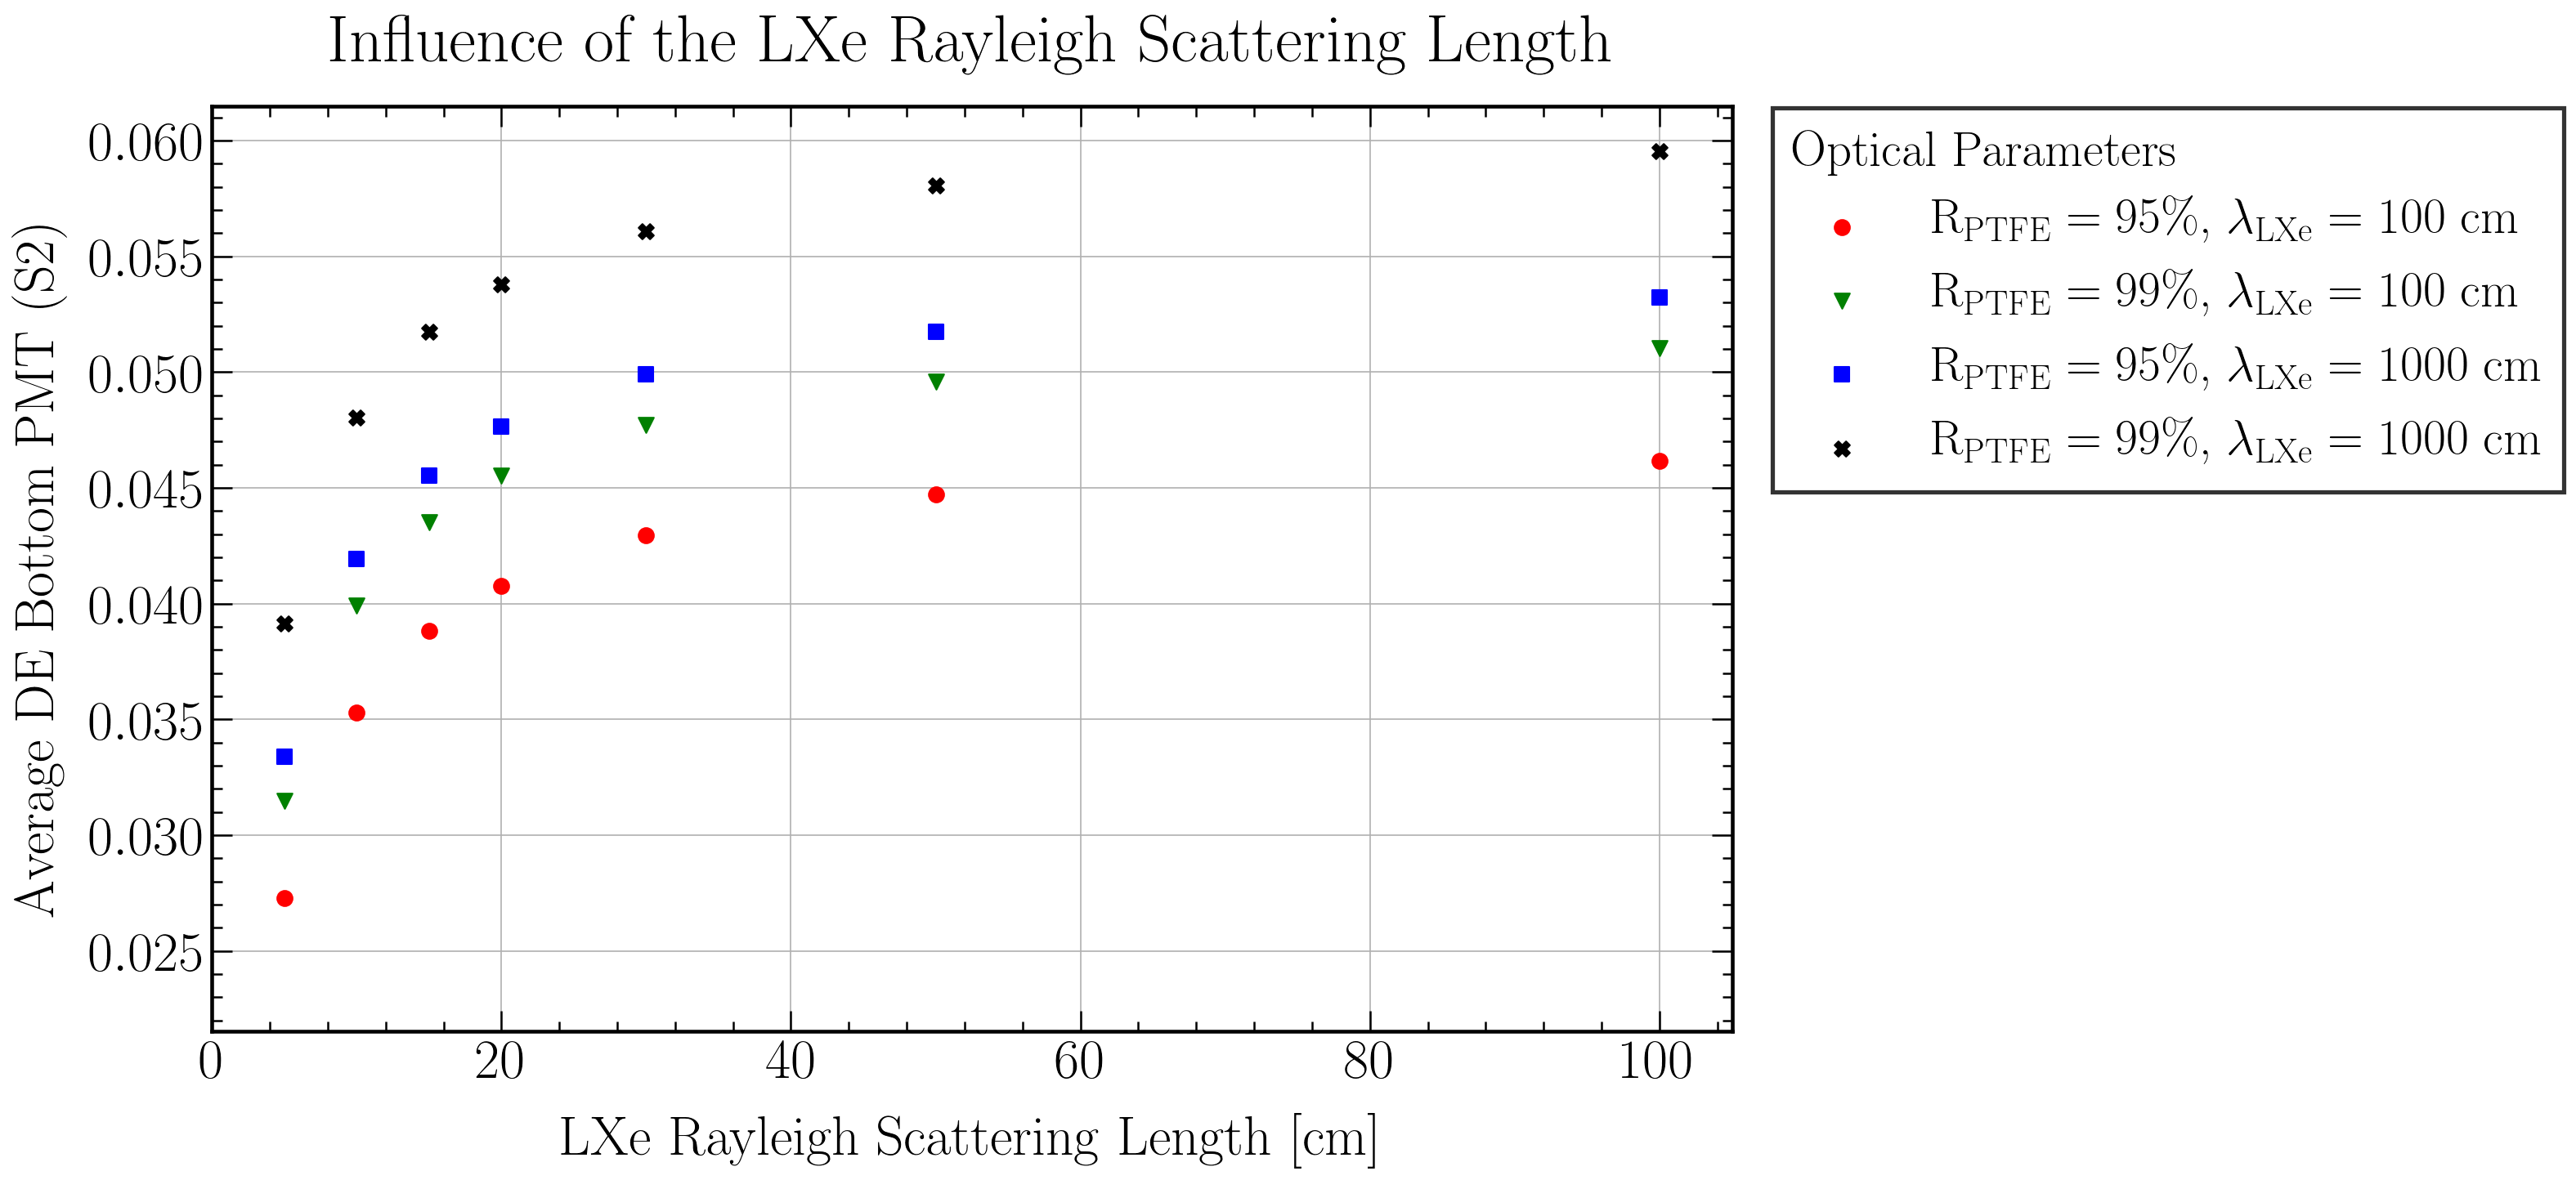

In [17]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_Bottom_S2.png", bbox_inches='tight')
plt.show()

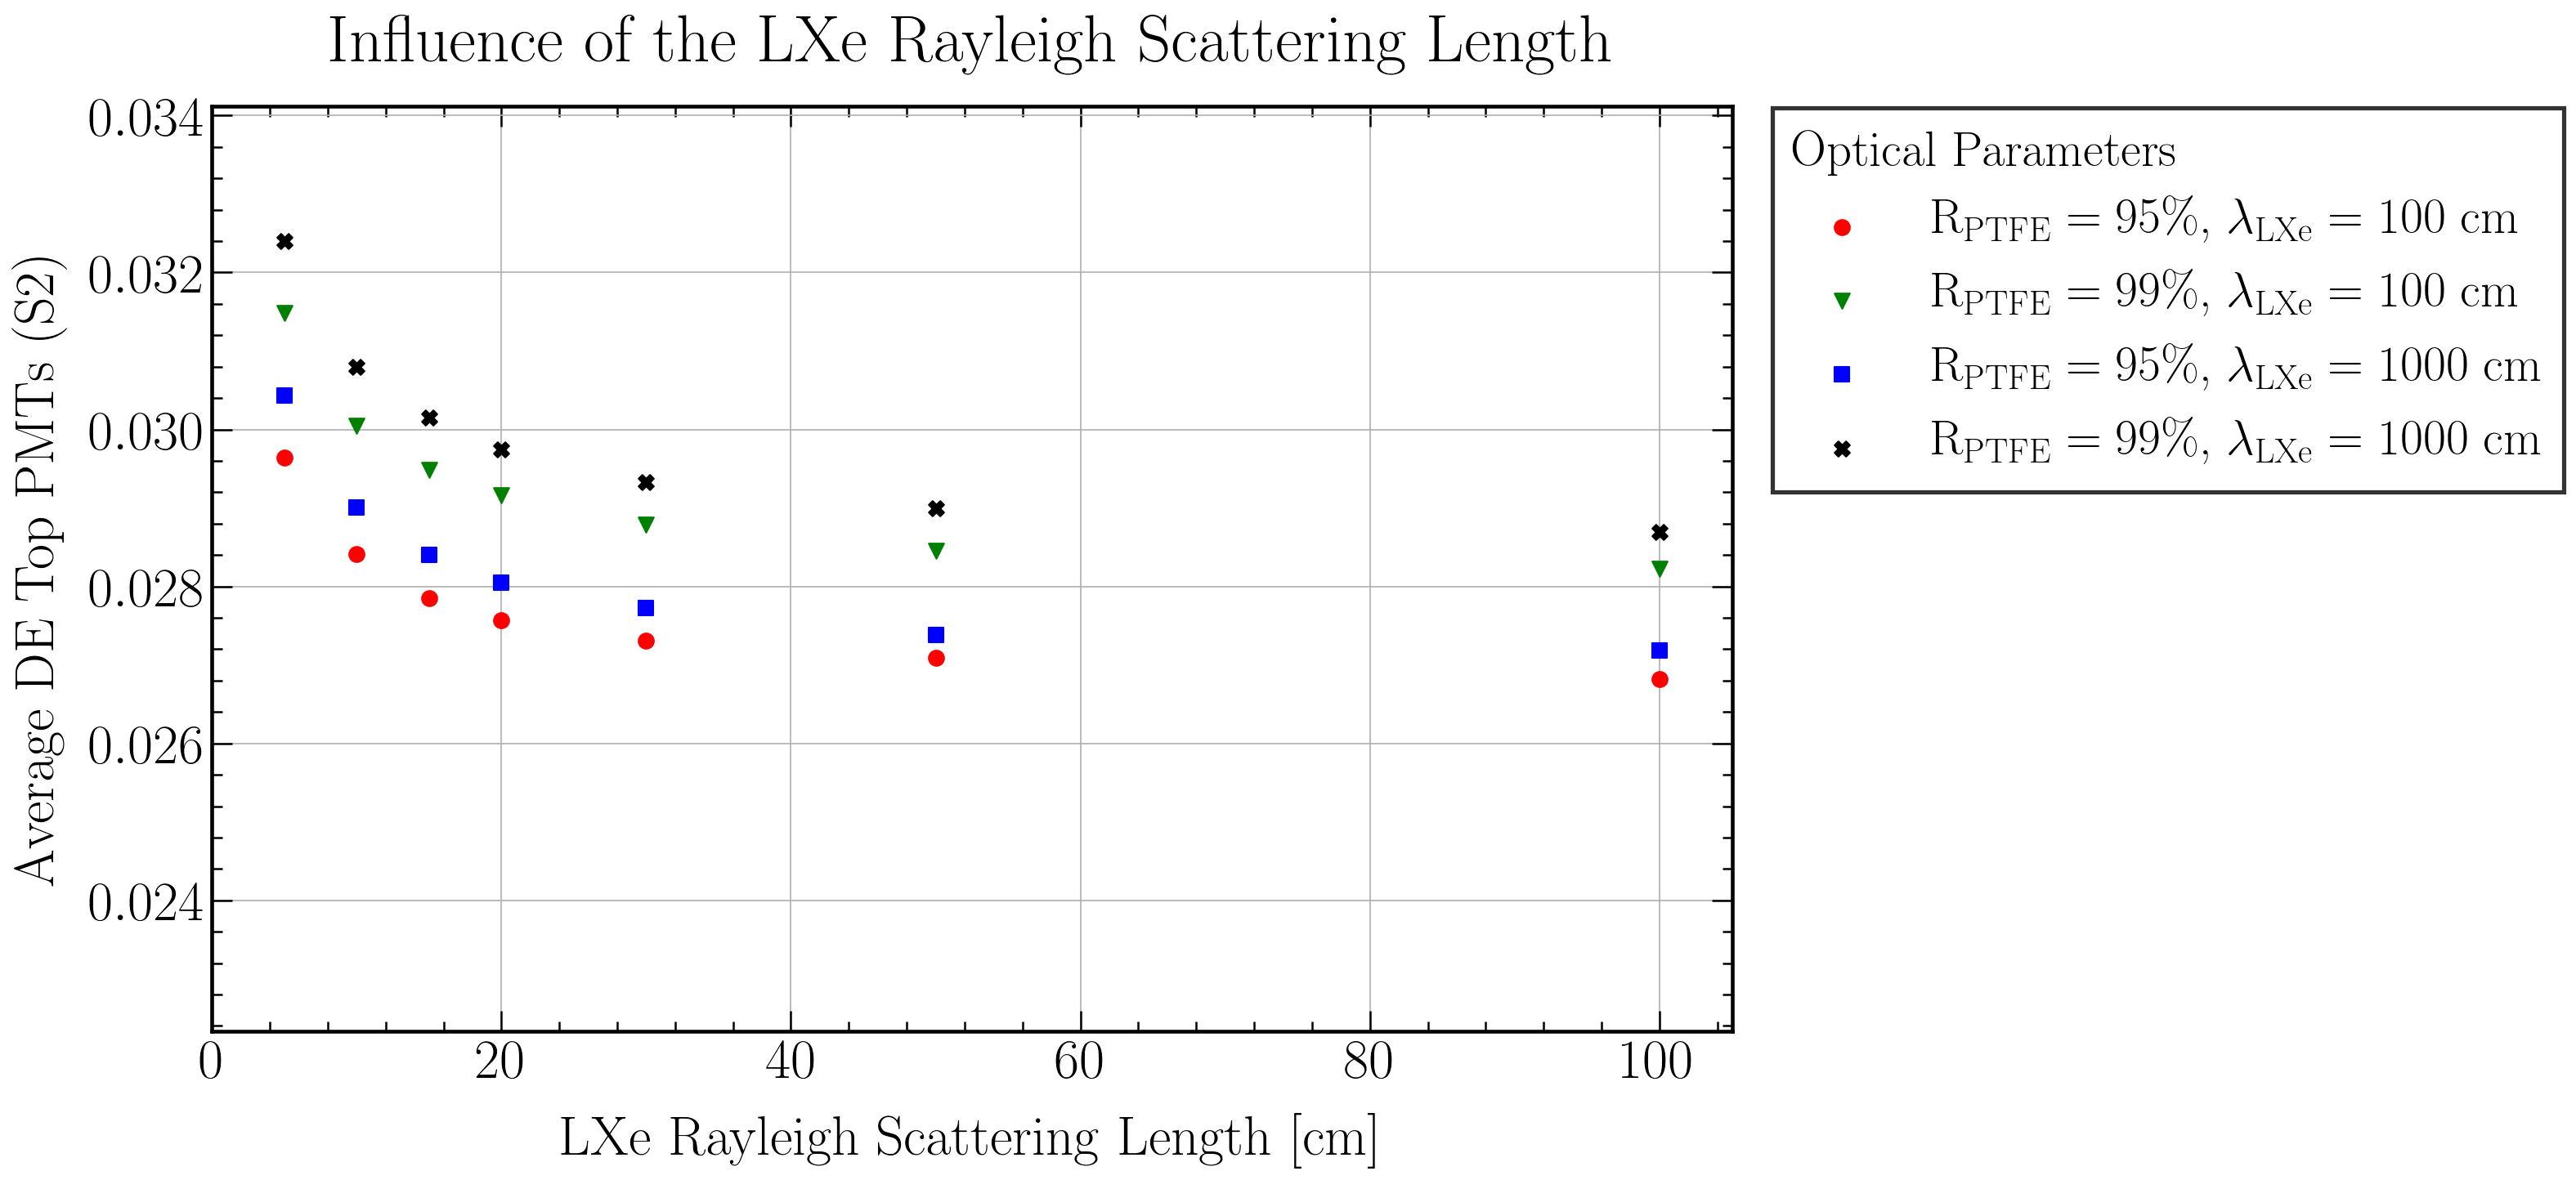

In [18]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Top PMTs (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_Top_S2.png", bbox_inches='tight')
plt.show()

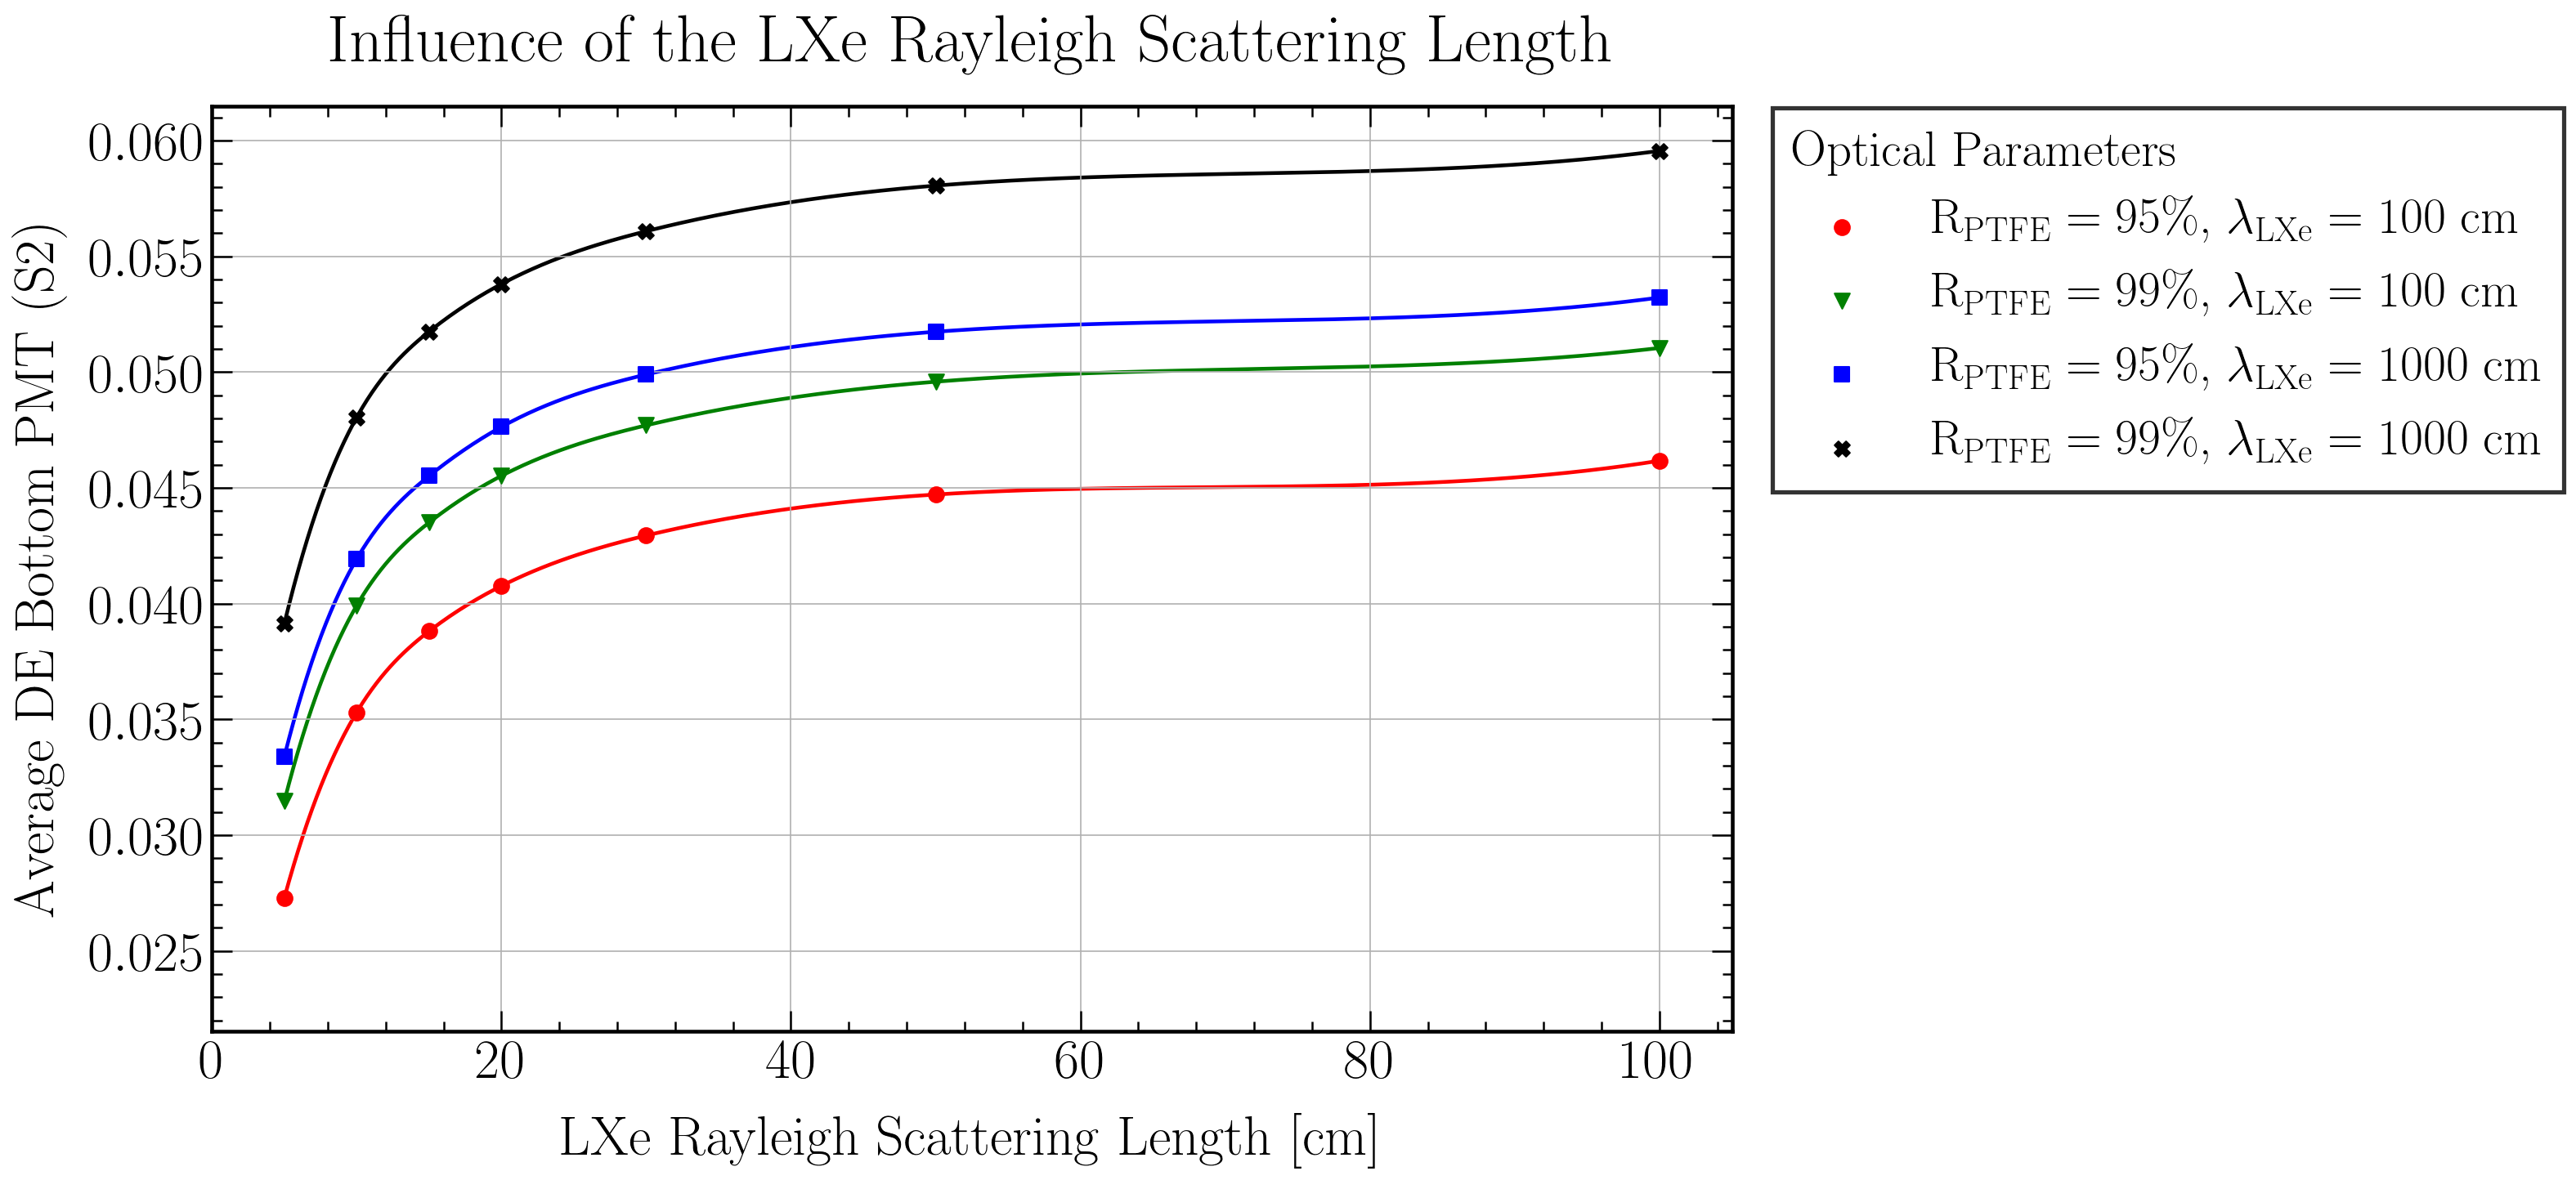

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Bottom PMT (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

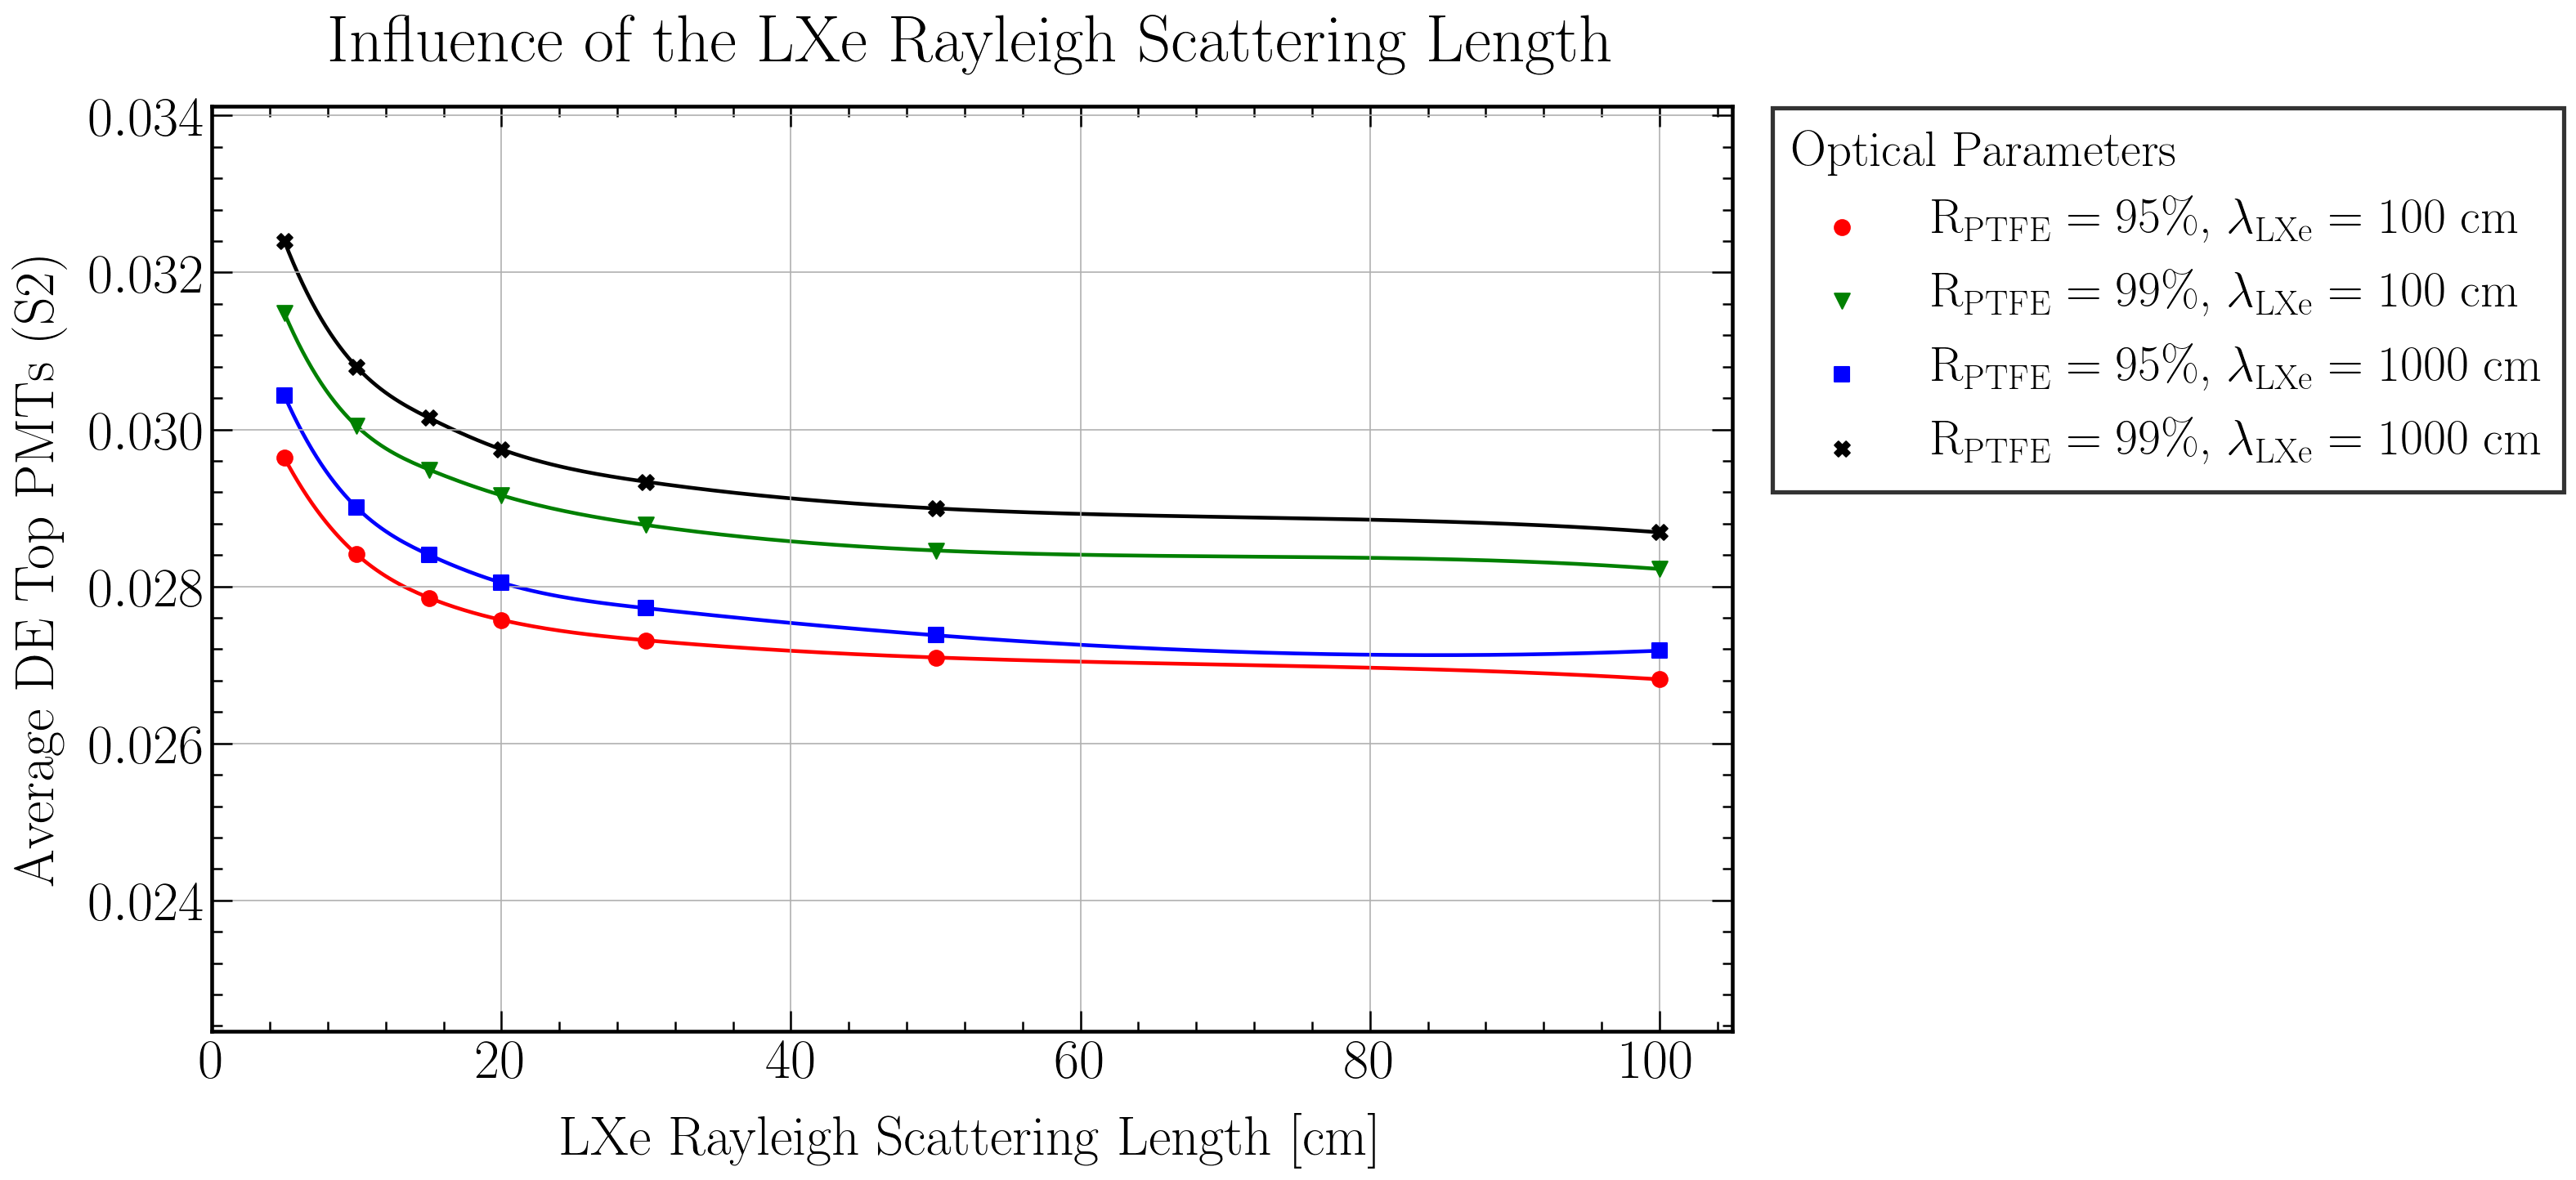

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["DE_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average DE Top PMTs (S2)', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="Optical Parameters", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_DE_Top_spline_S2.png", bbox_inches='tight')
plt.show()

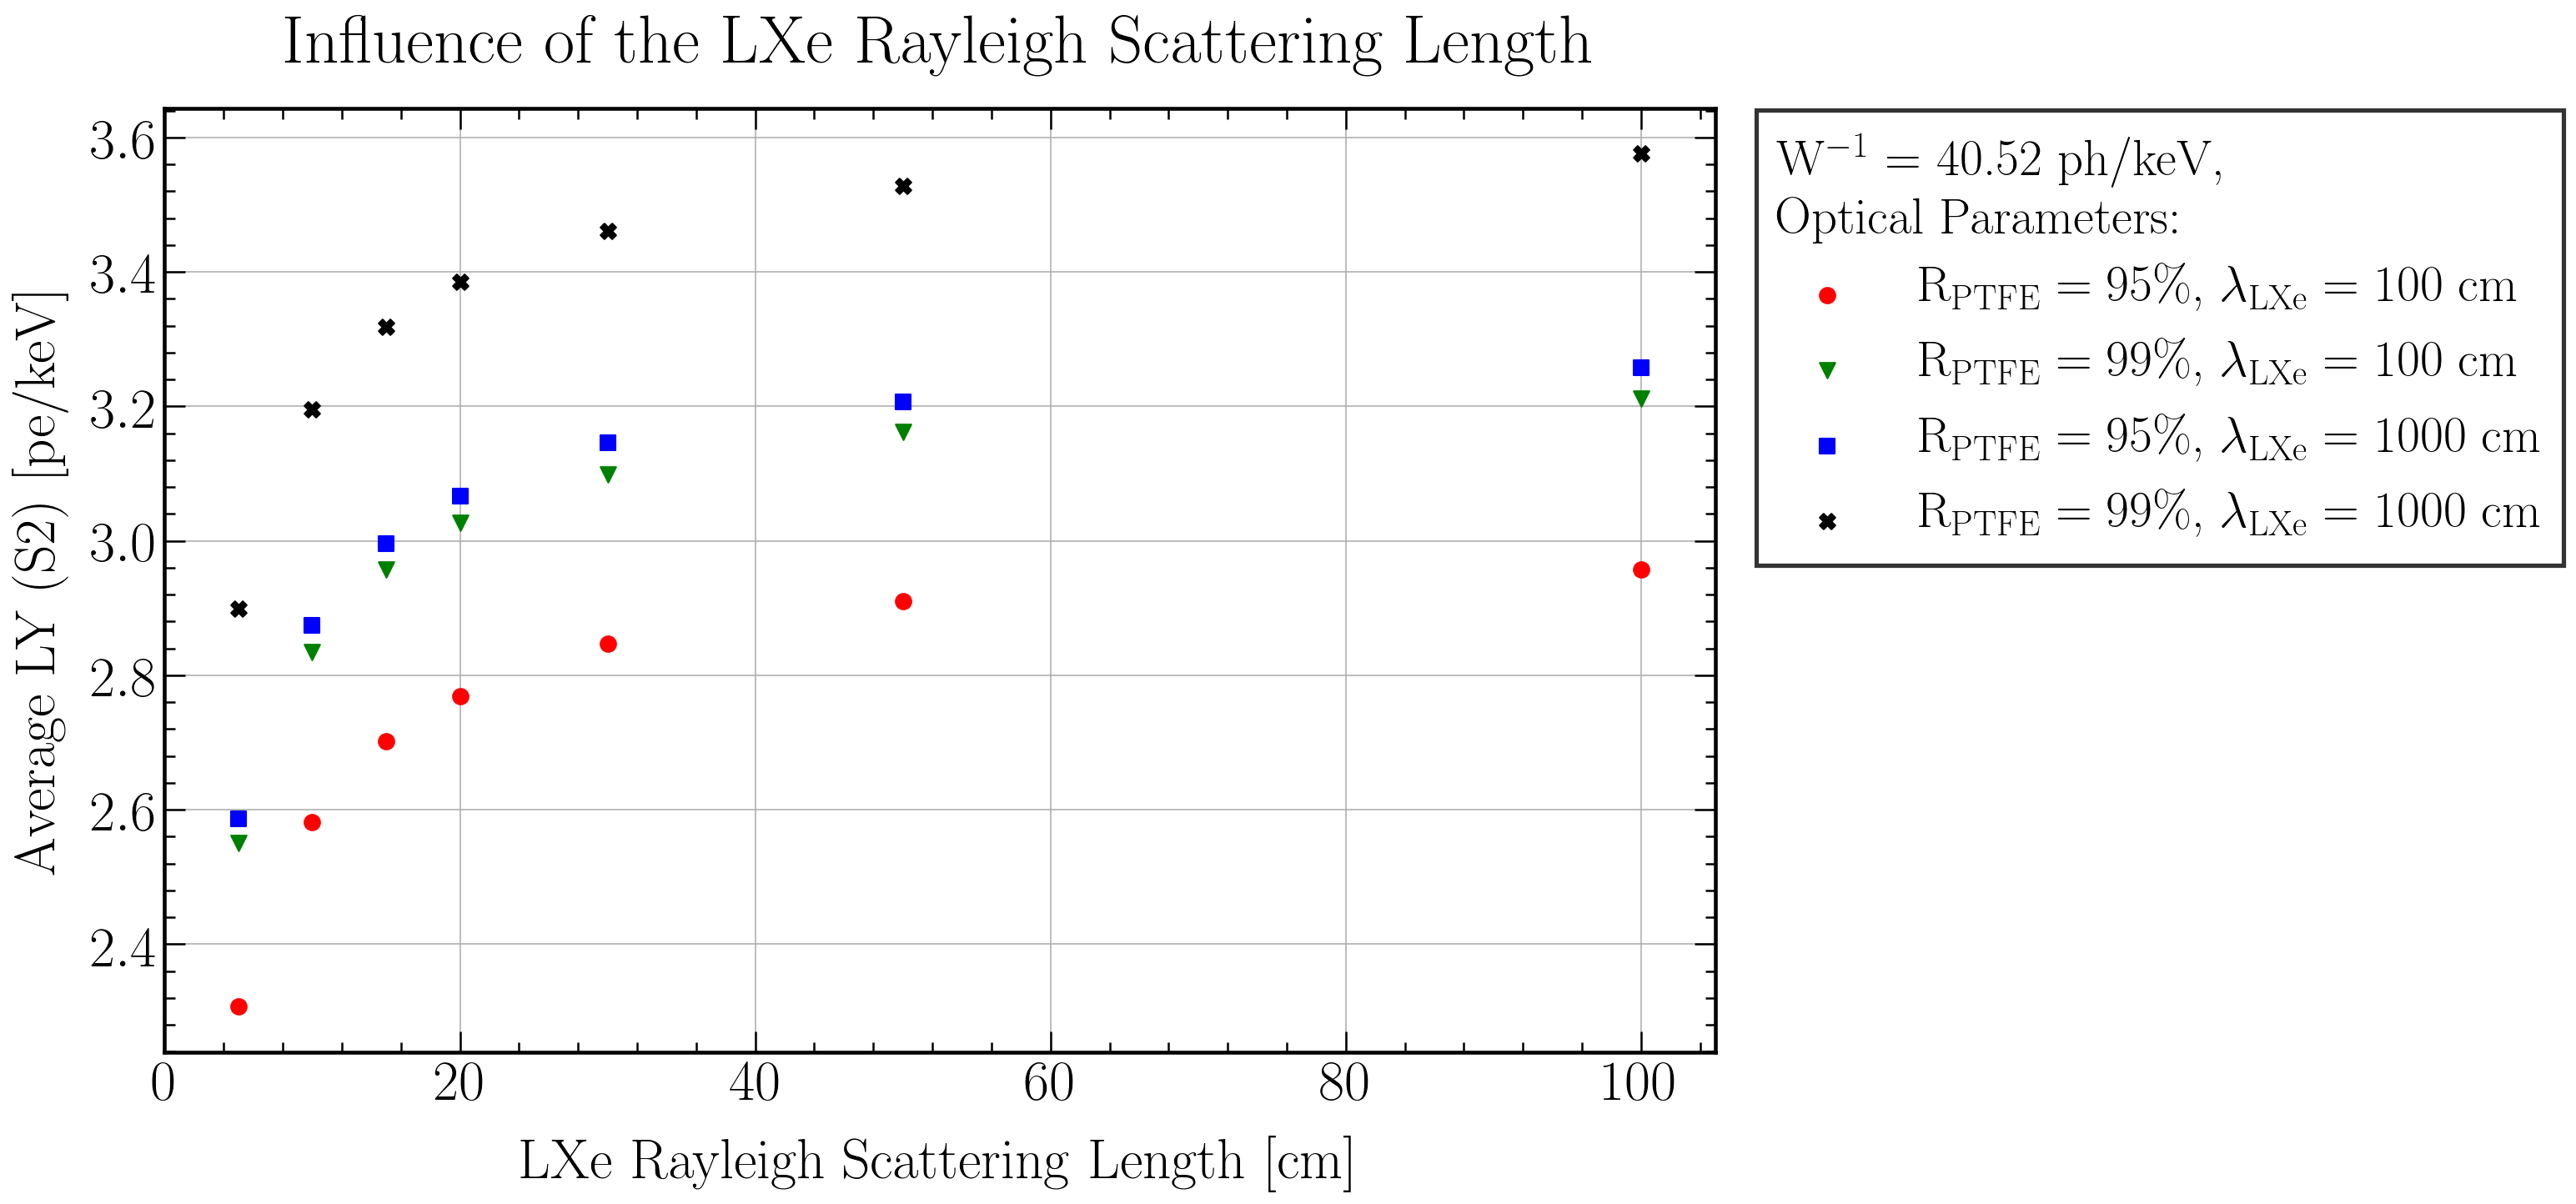

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_S2.png", bbox_inches='tight')
plt.show()

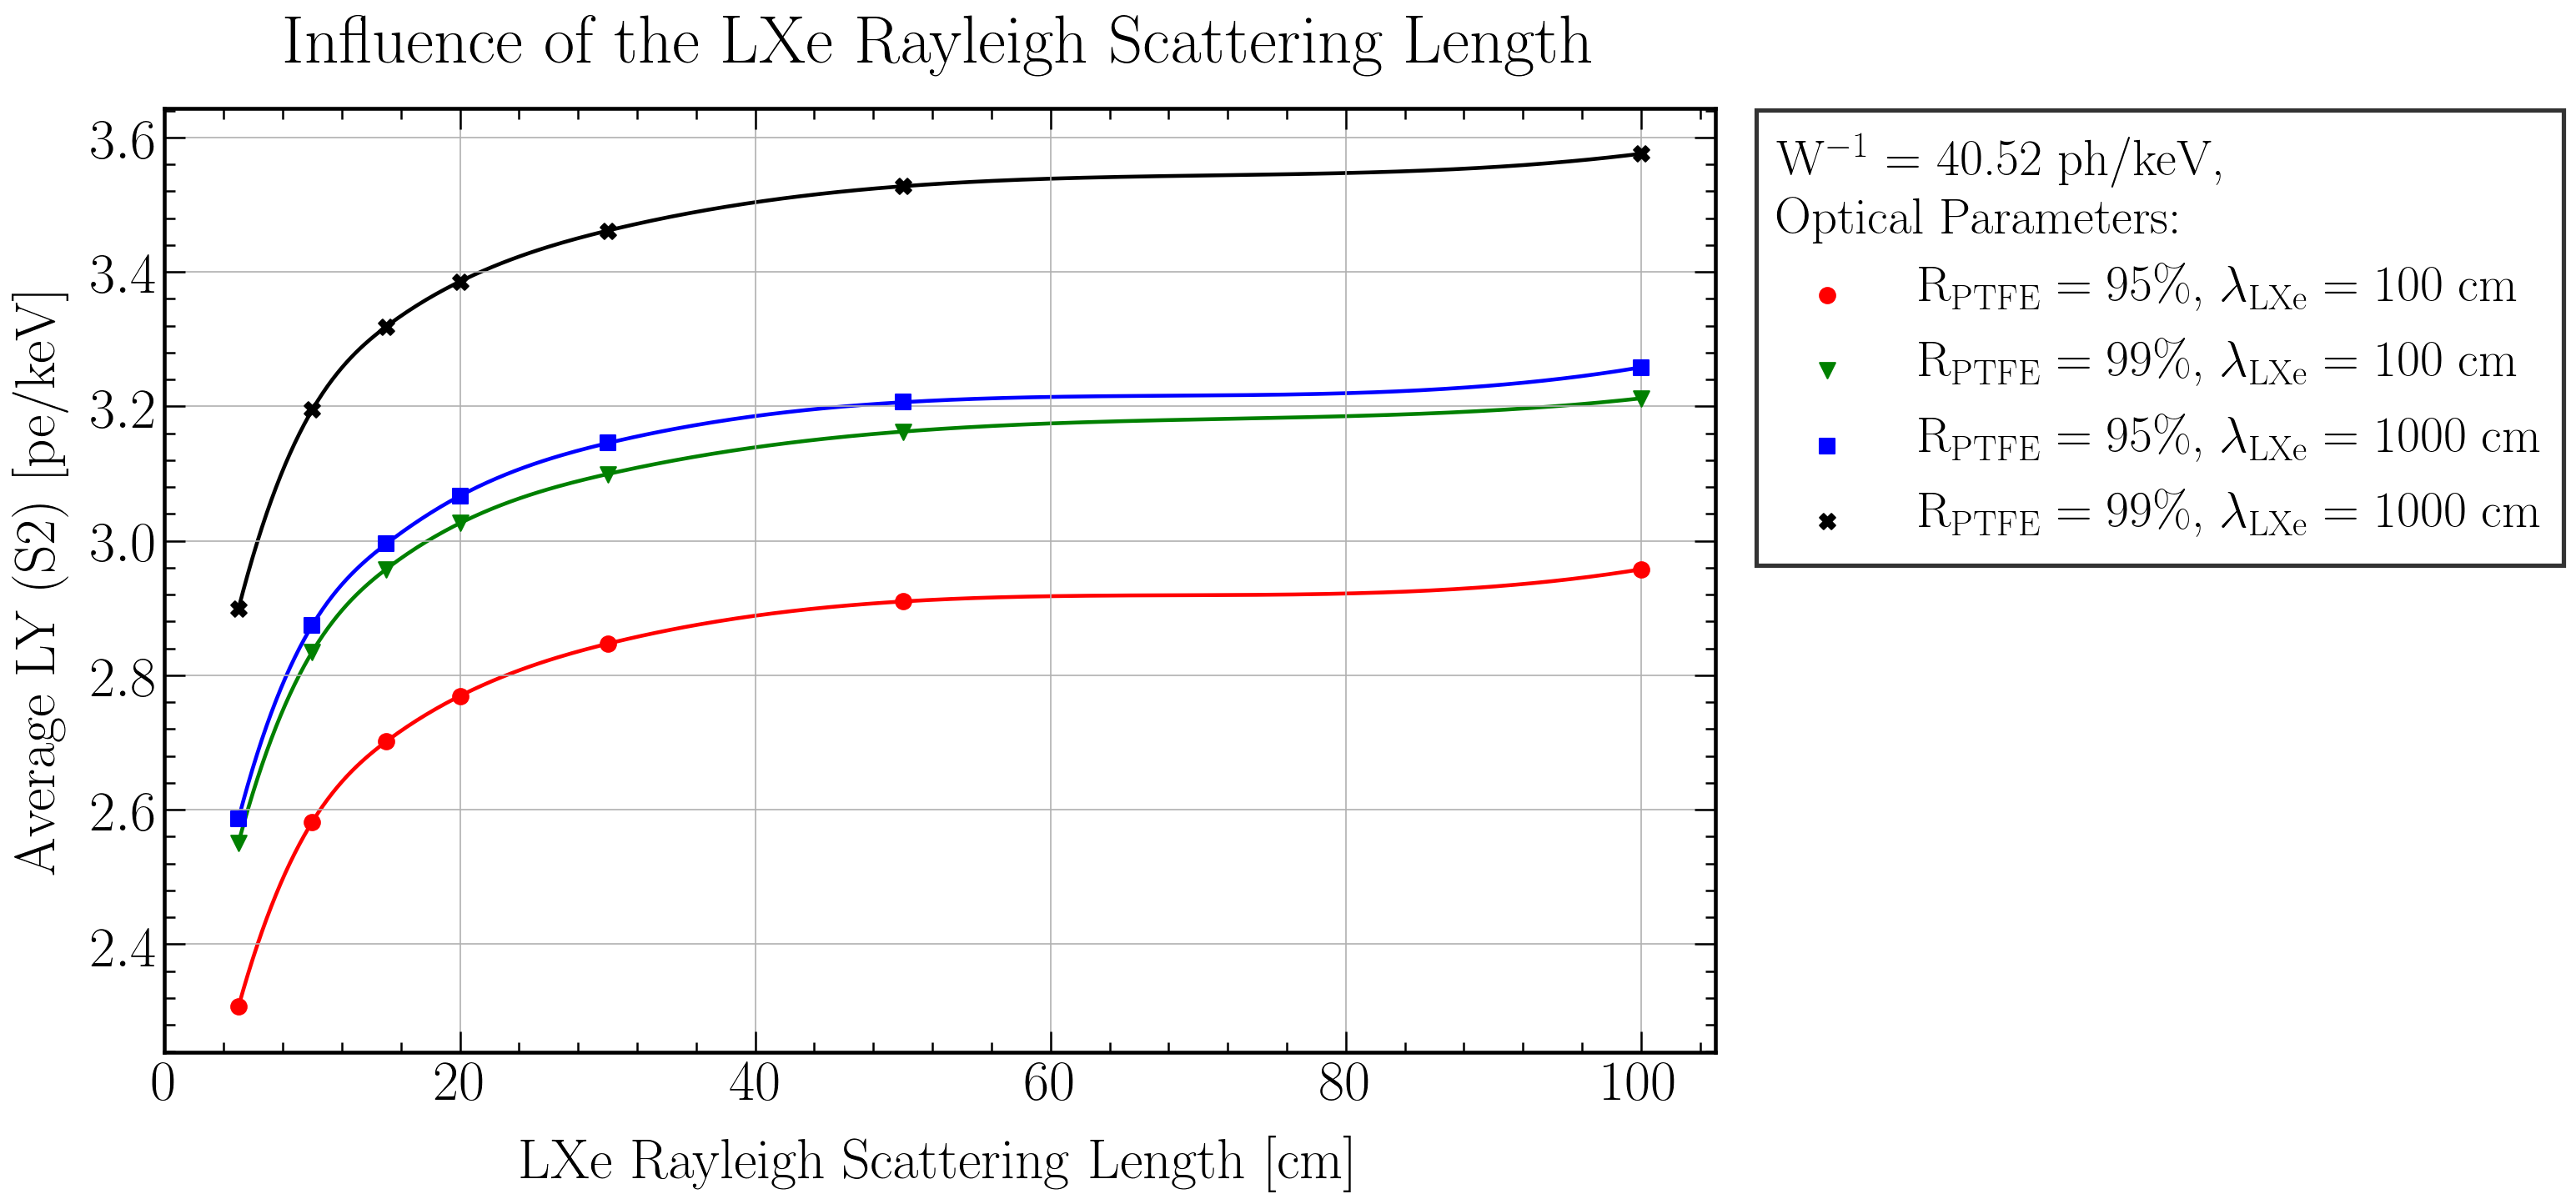

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_spline_S2.png", bbox_inches='tight')
plt.show()

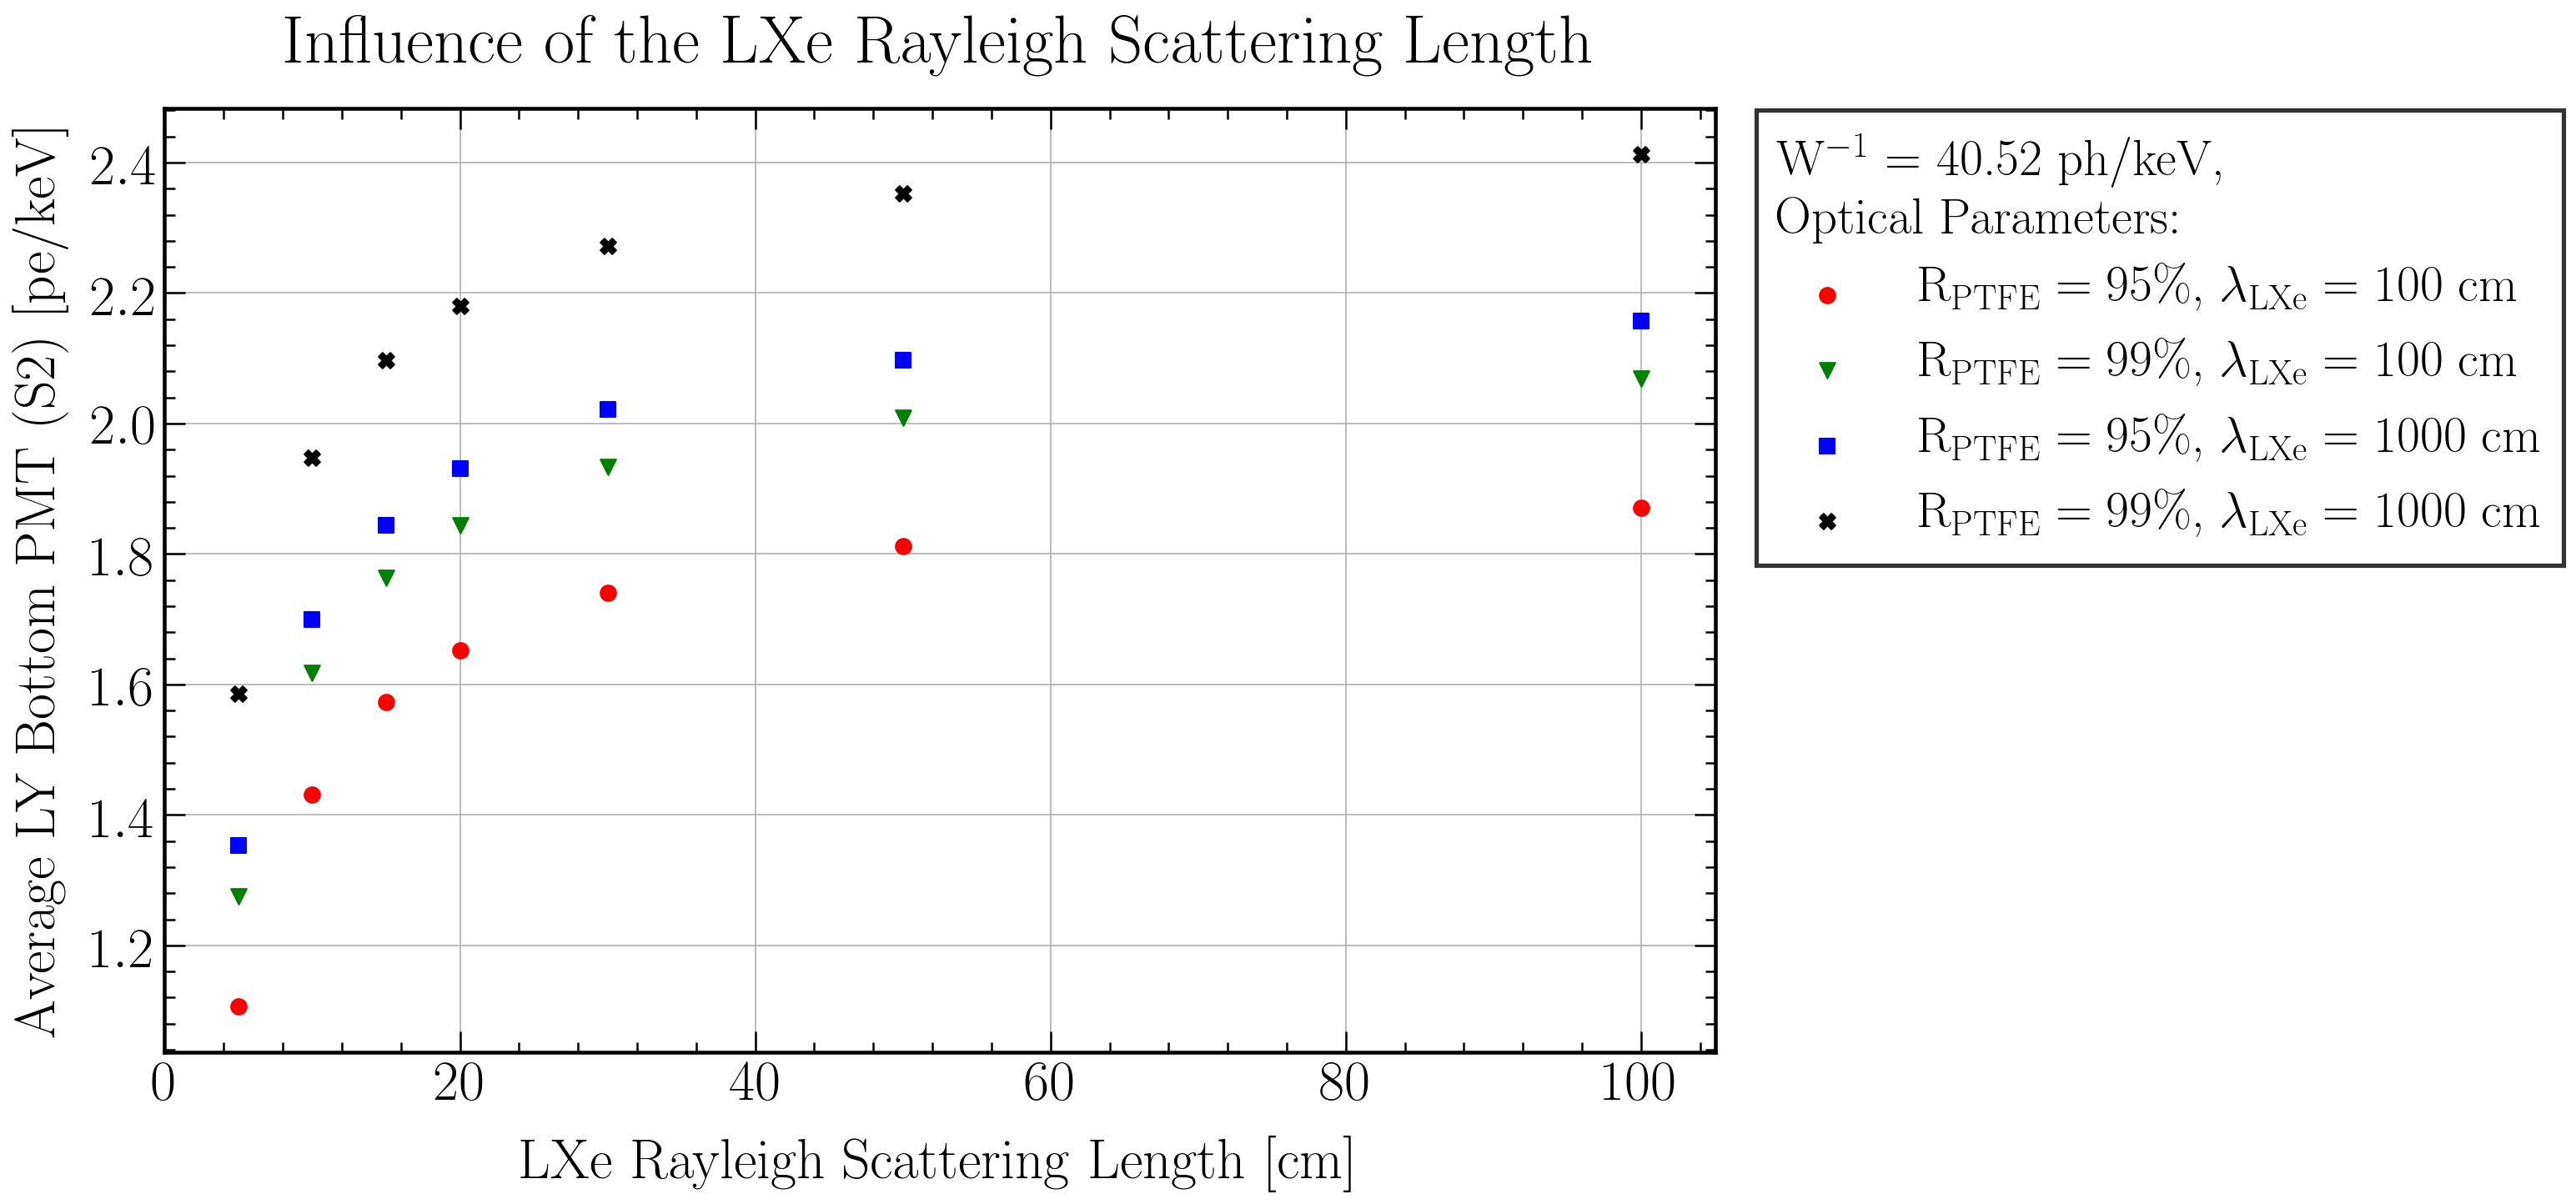

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_Bottom_S2.png", bbox_inches='tight')
plt.show()

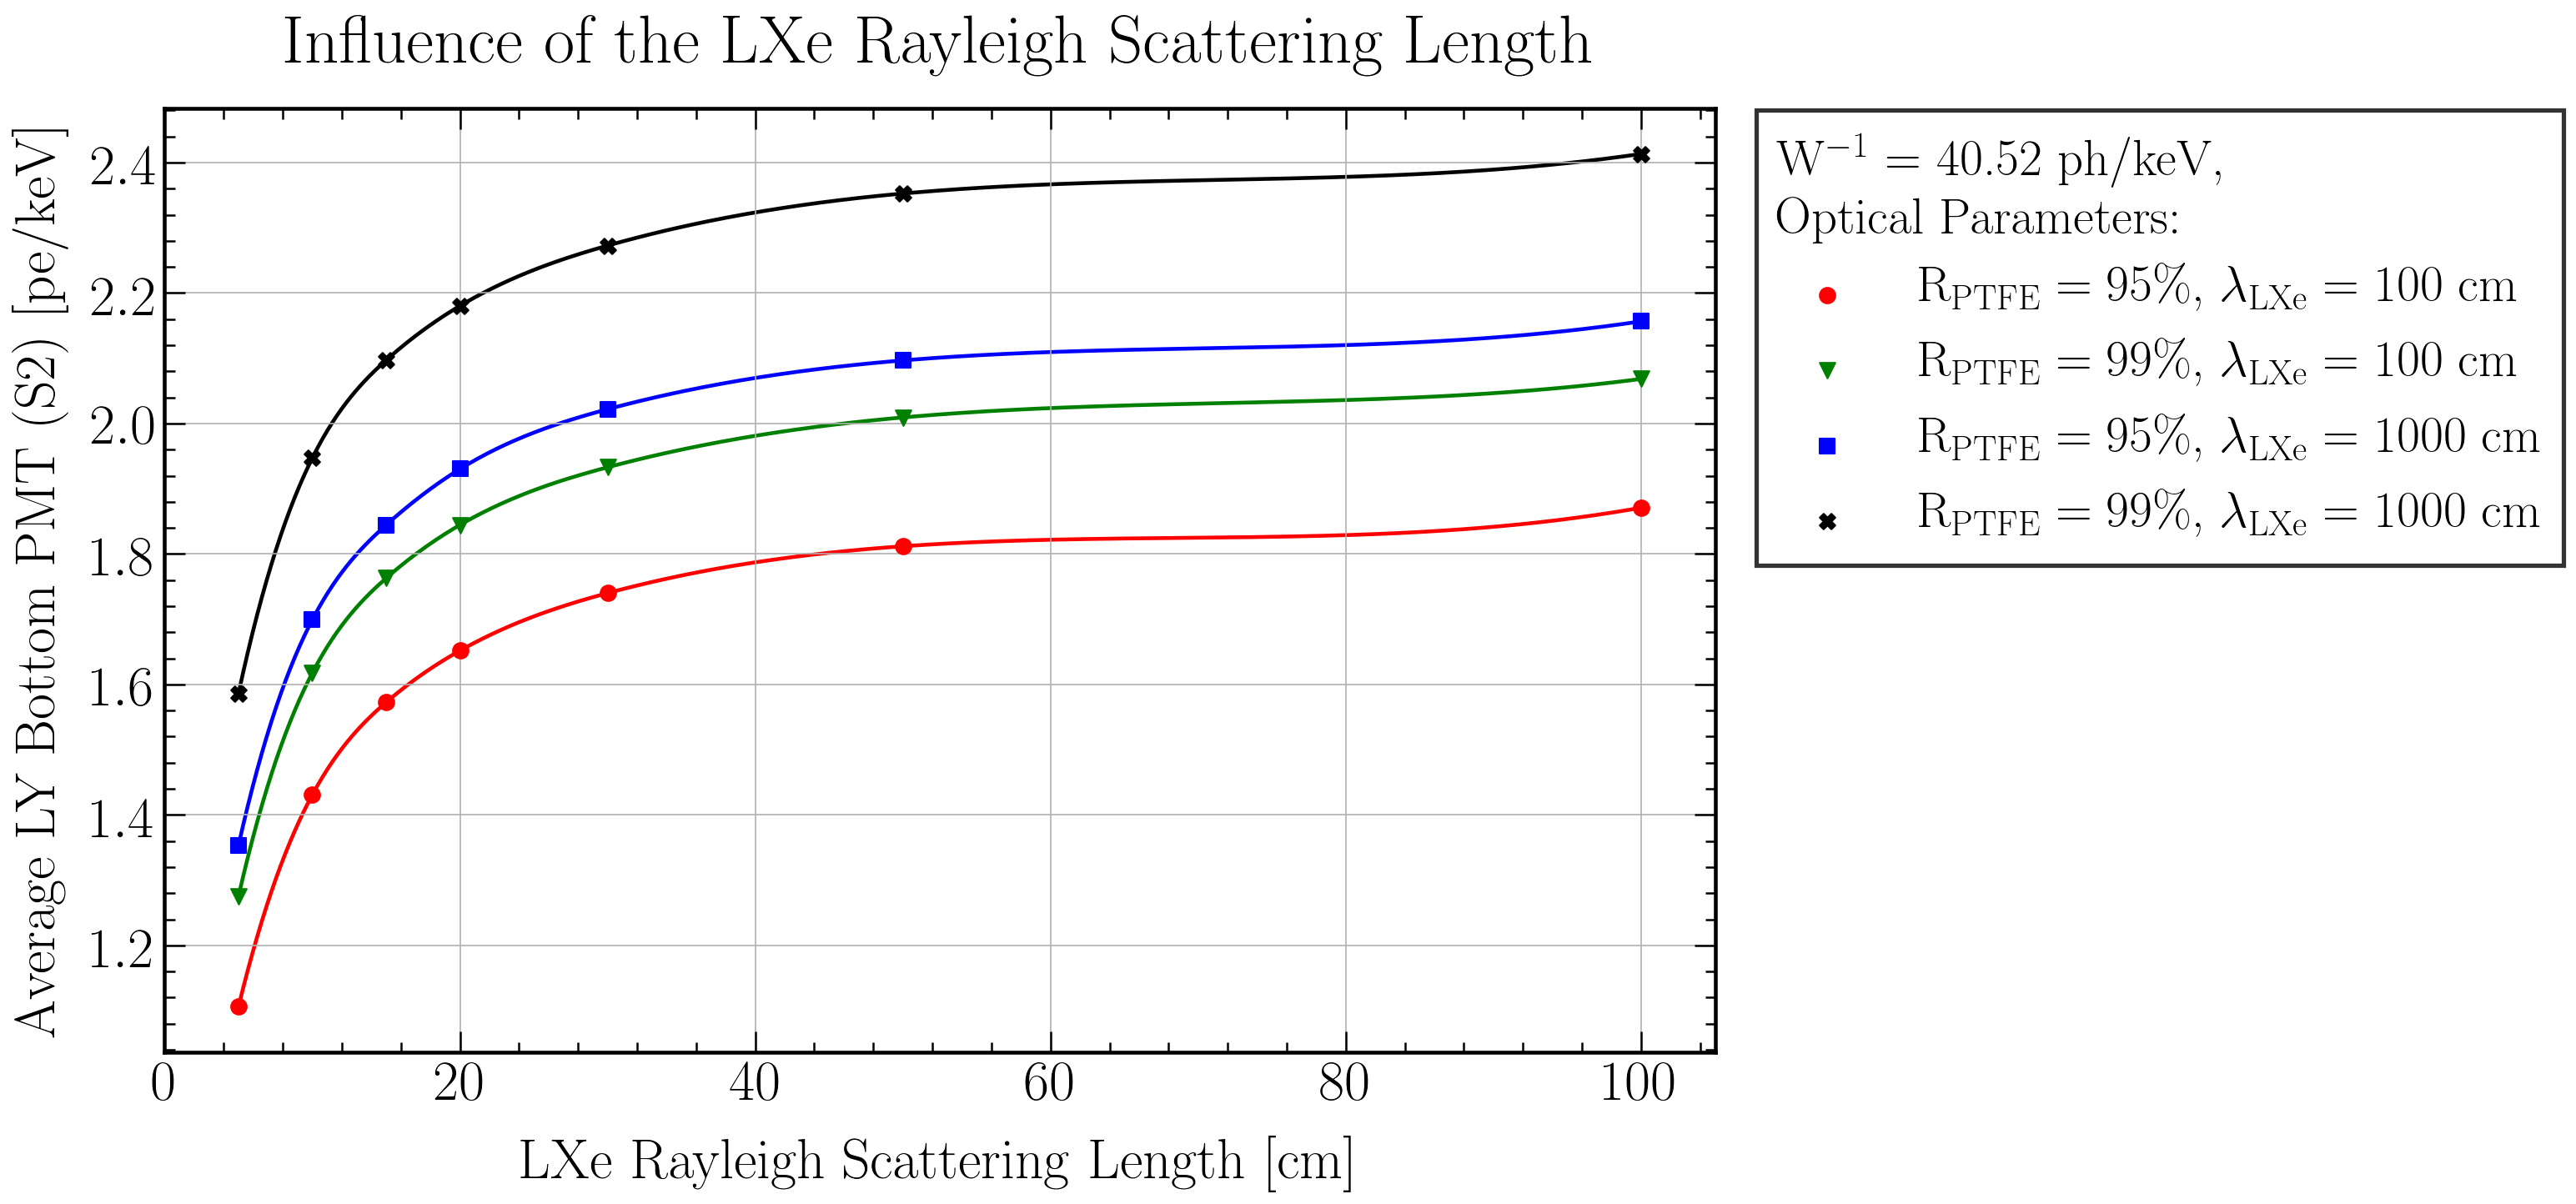

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

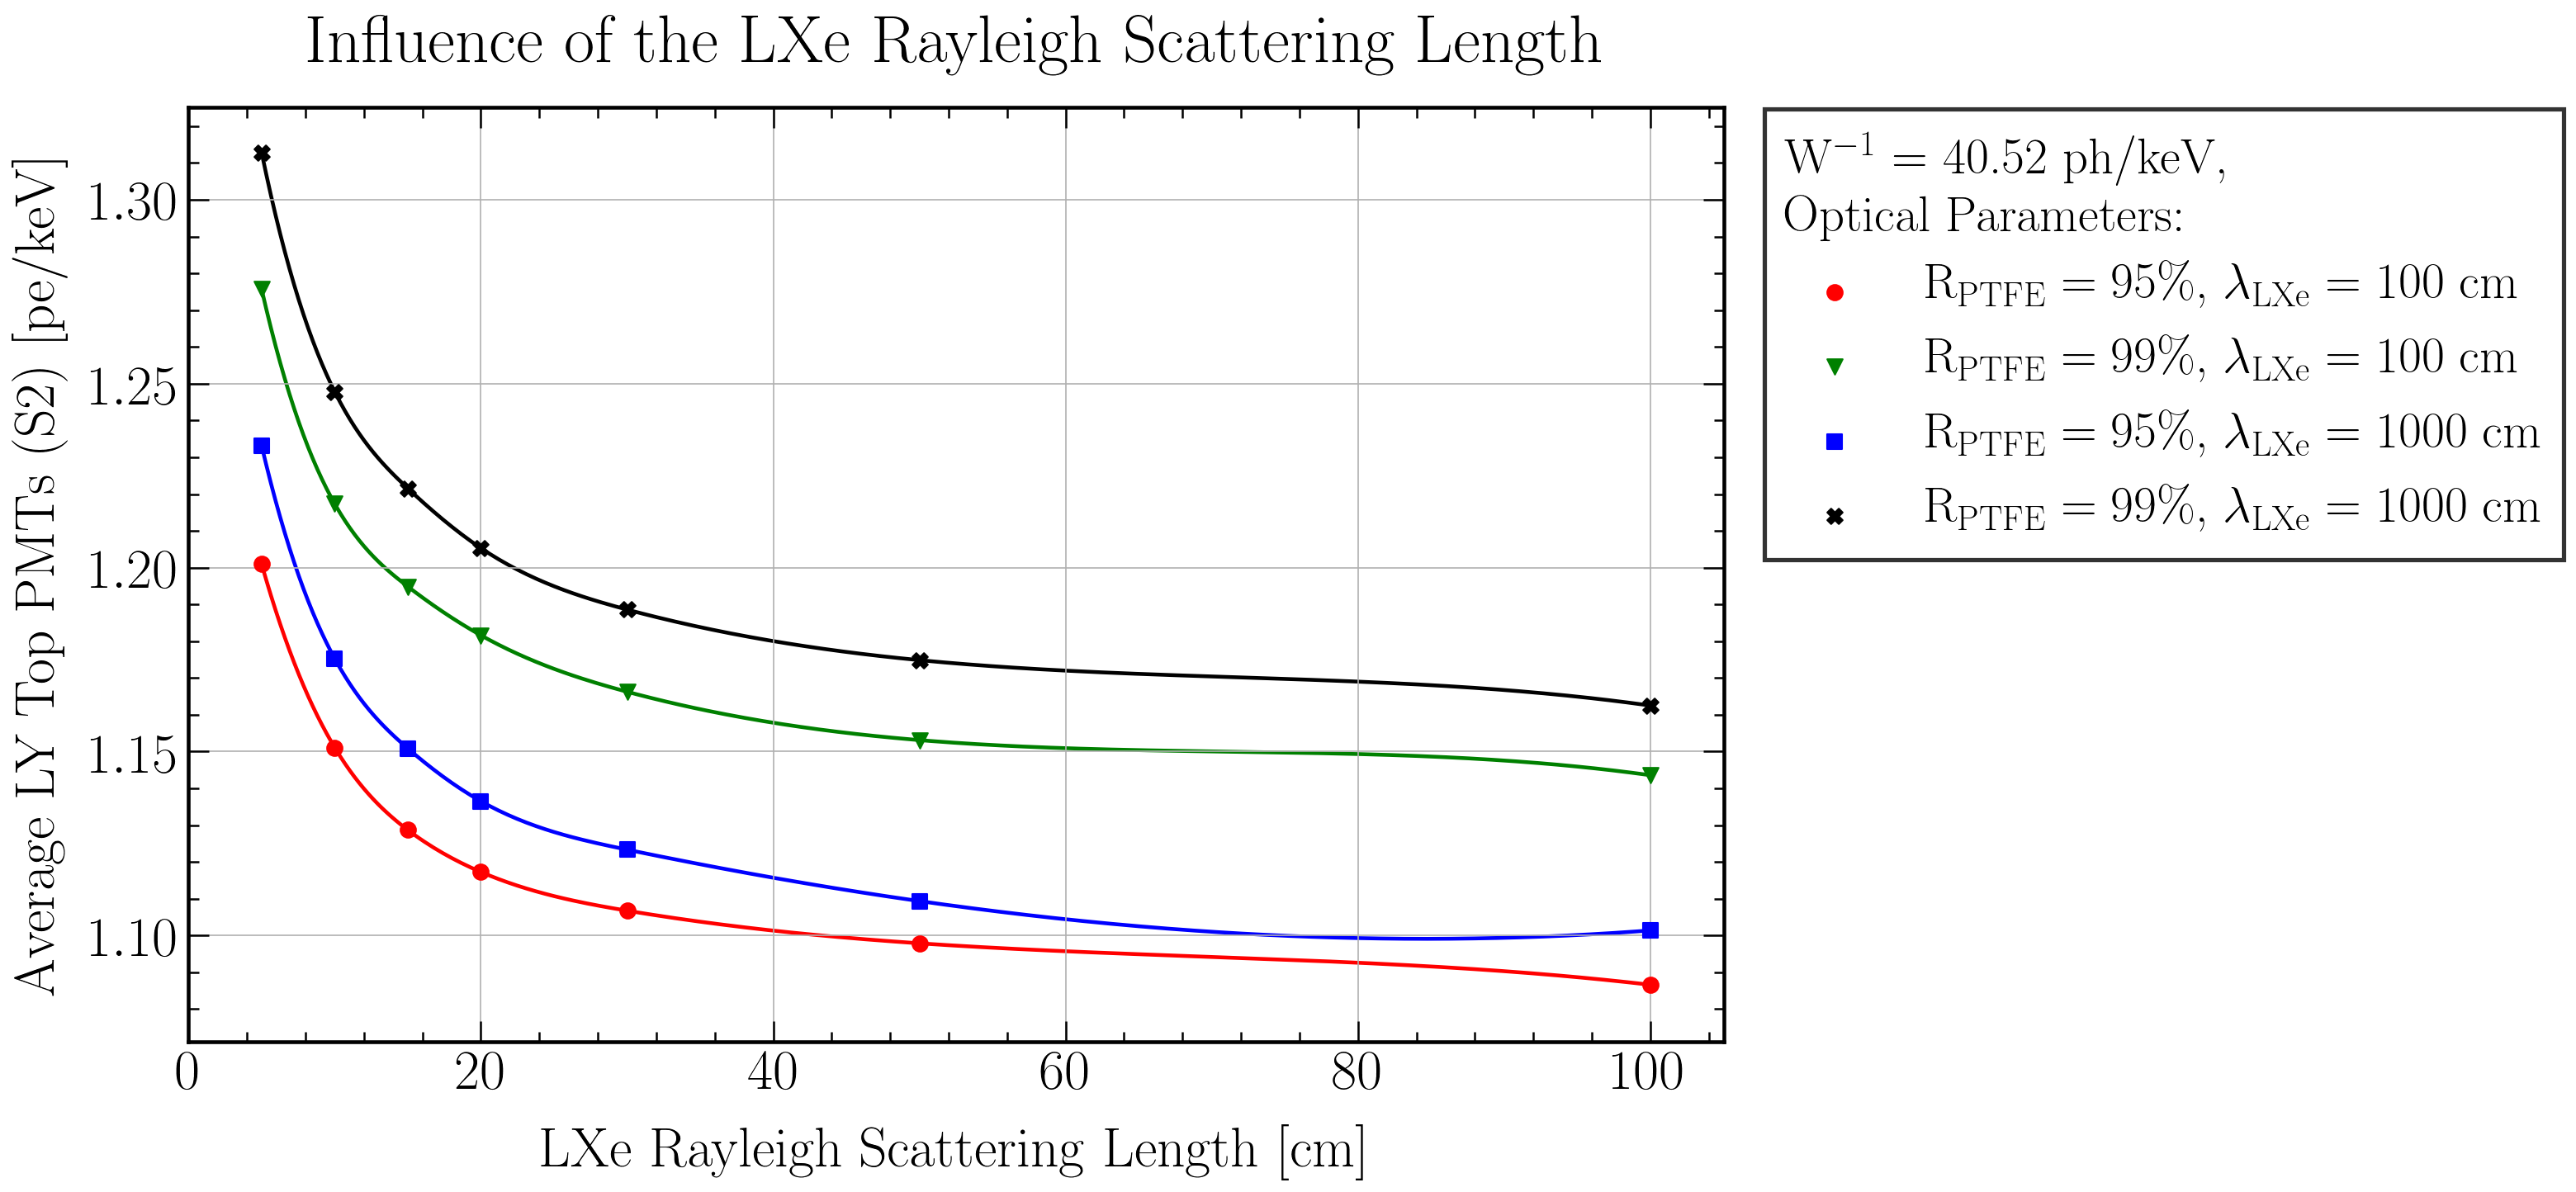

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Top PMTs (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$^{-1}$ = "+str(round(1/W,2))+" ph/keV,\n"+"Optical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY_Top_spline_S2.png", bbox_inches='tight')
plt.show()

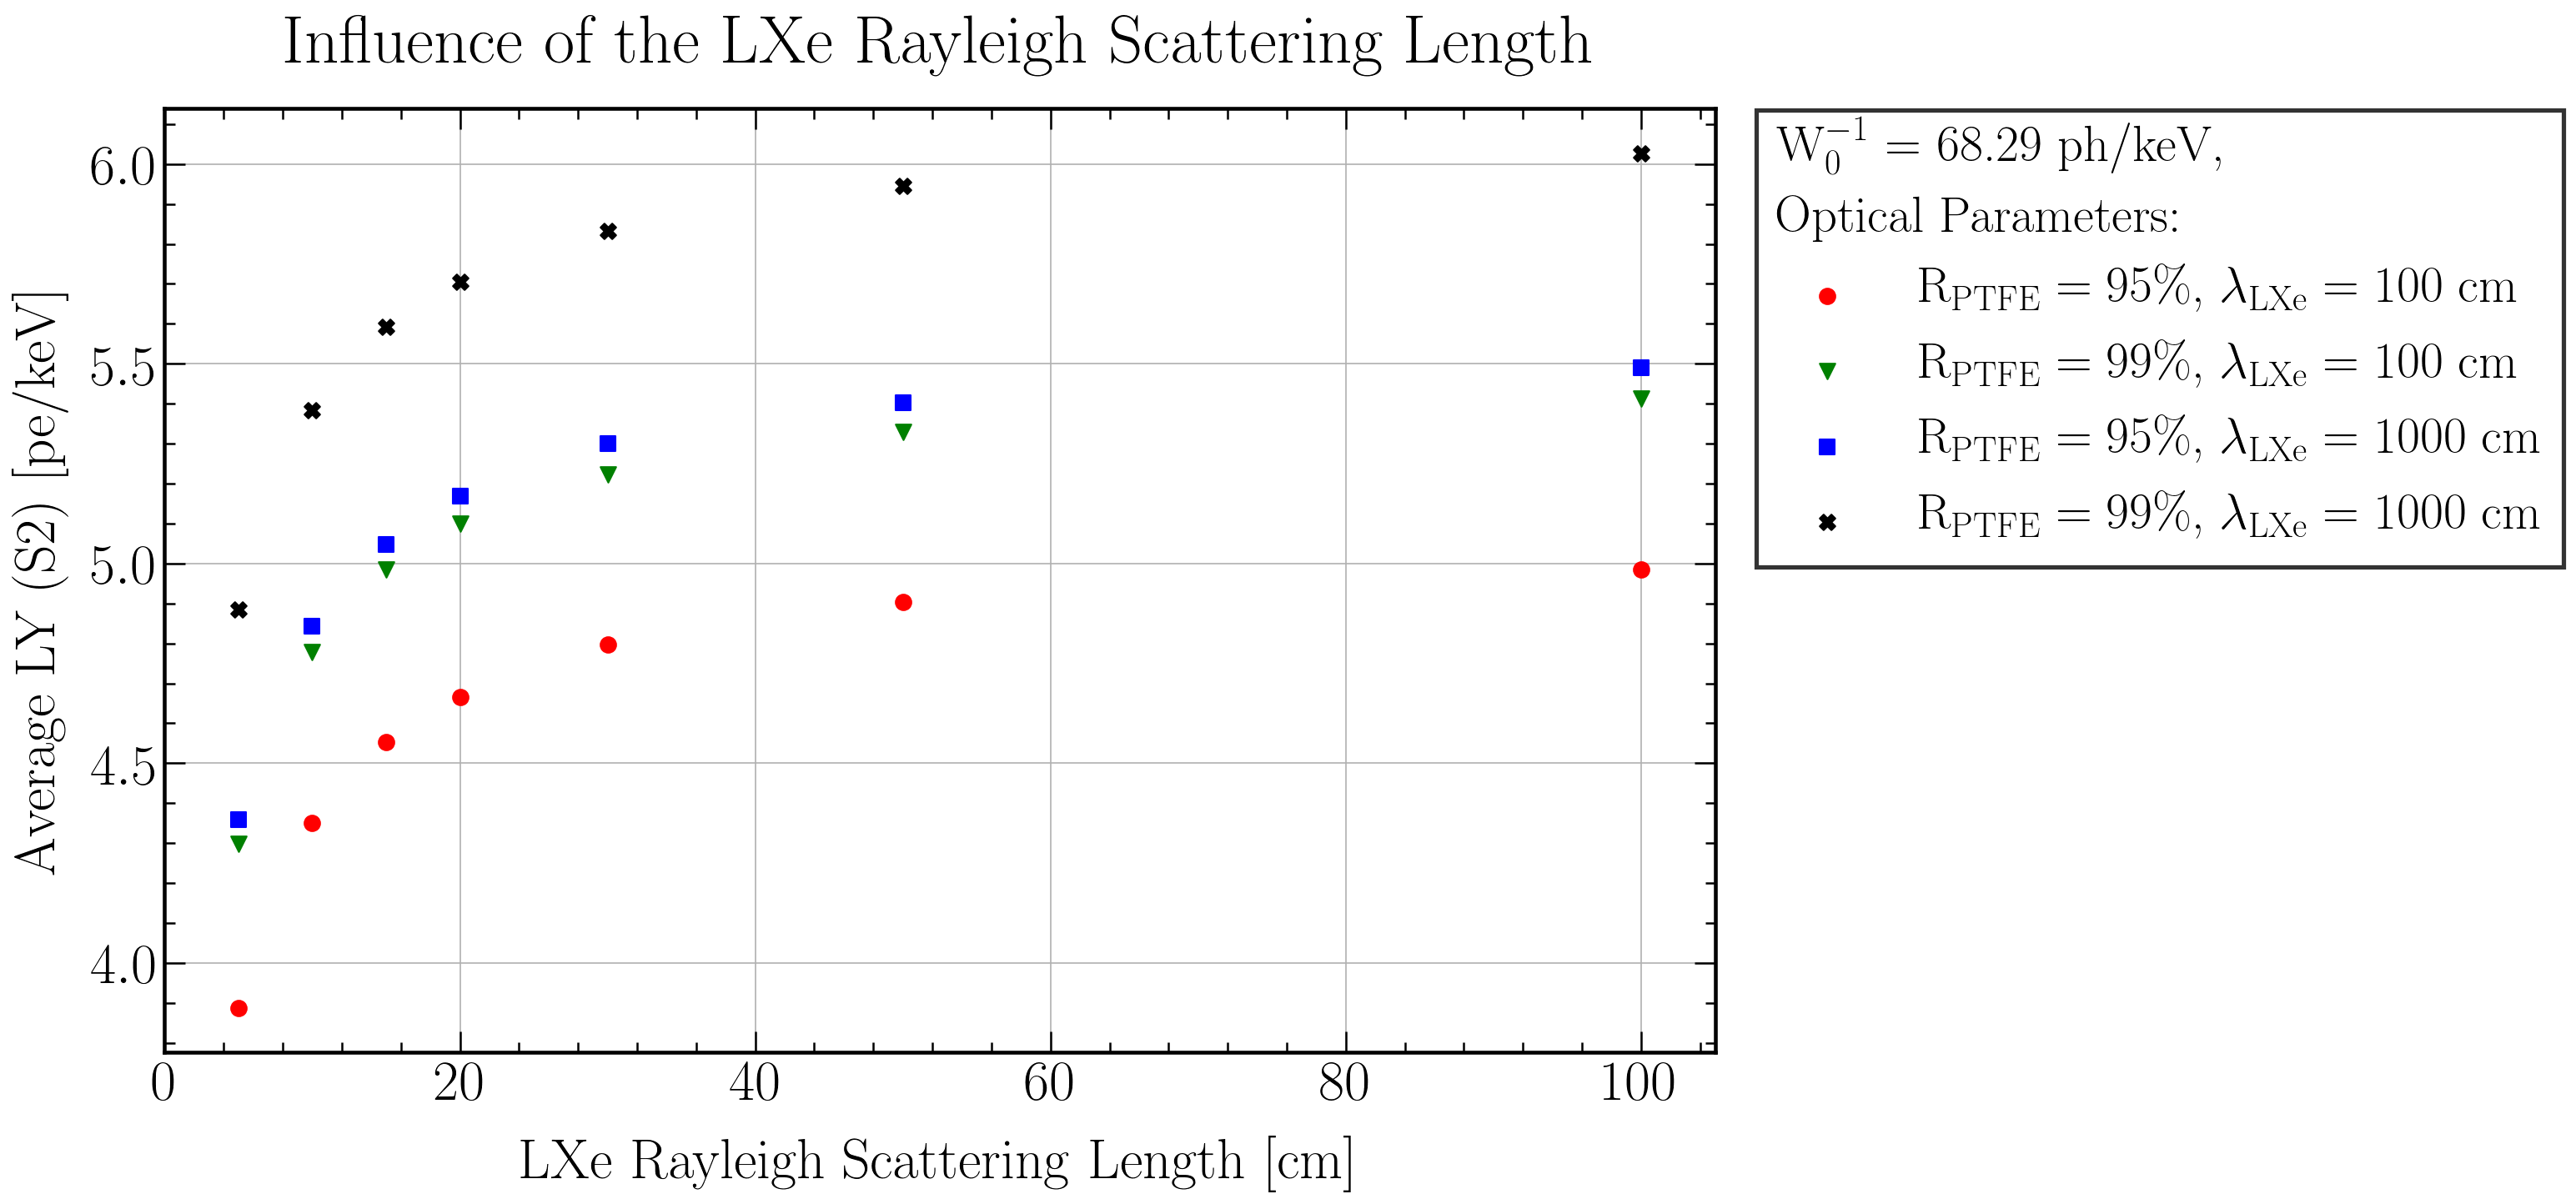

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_S2.png", bbox_inches='tight')
plt.show()

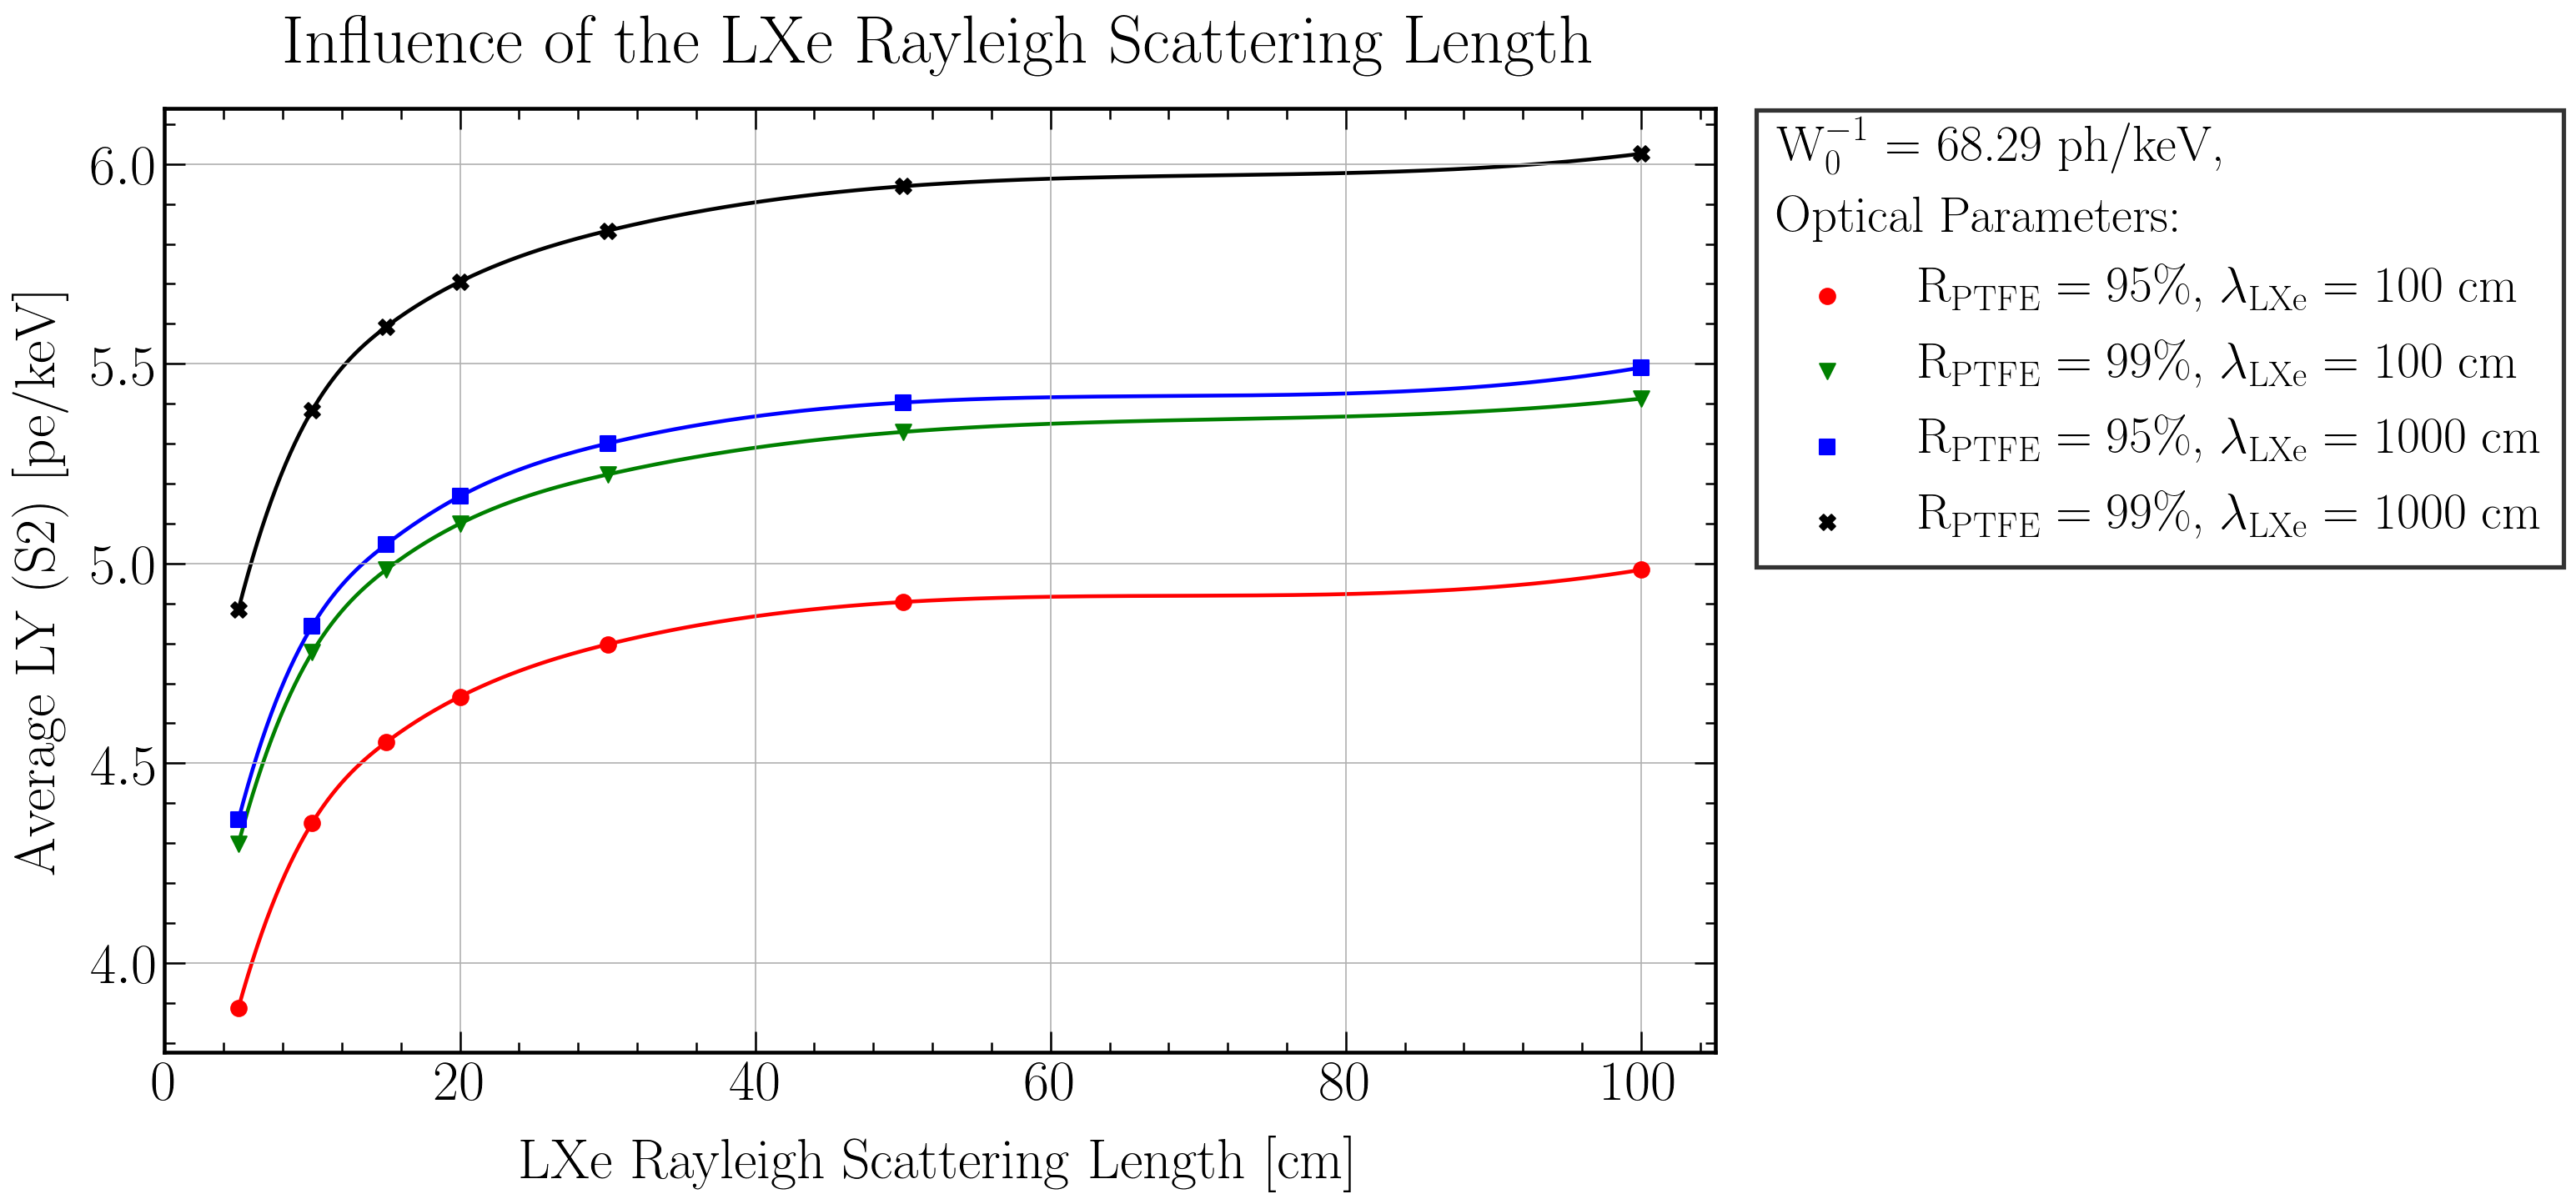

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_a"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_spline_S2.png", bbox_inches='tight')
plt.show()

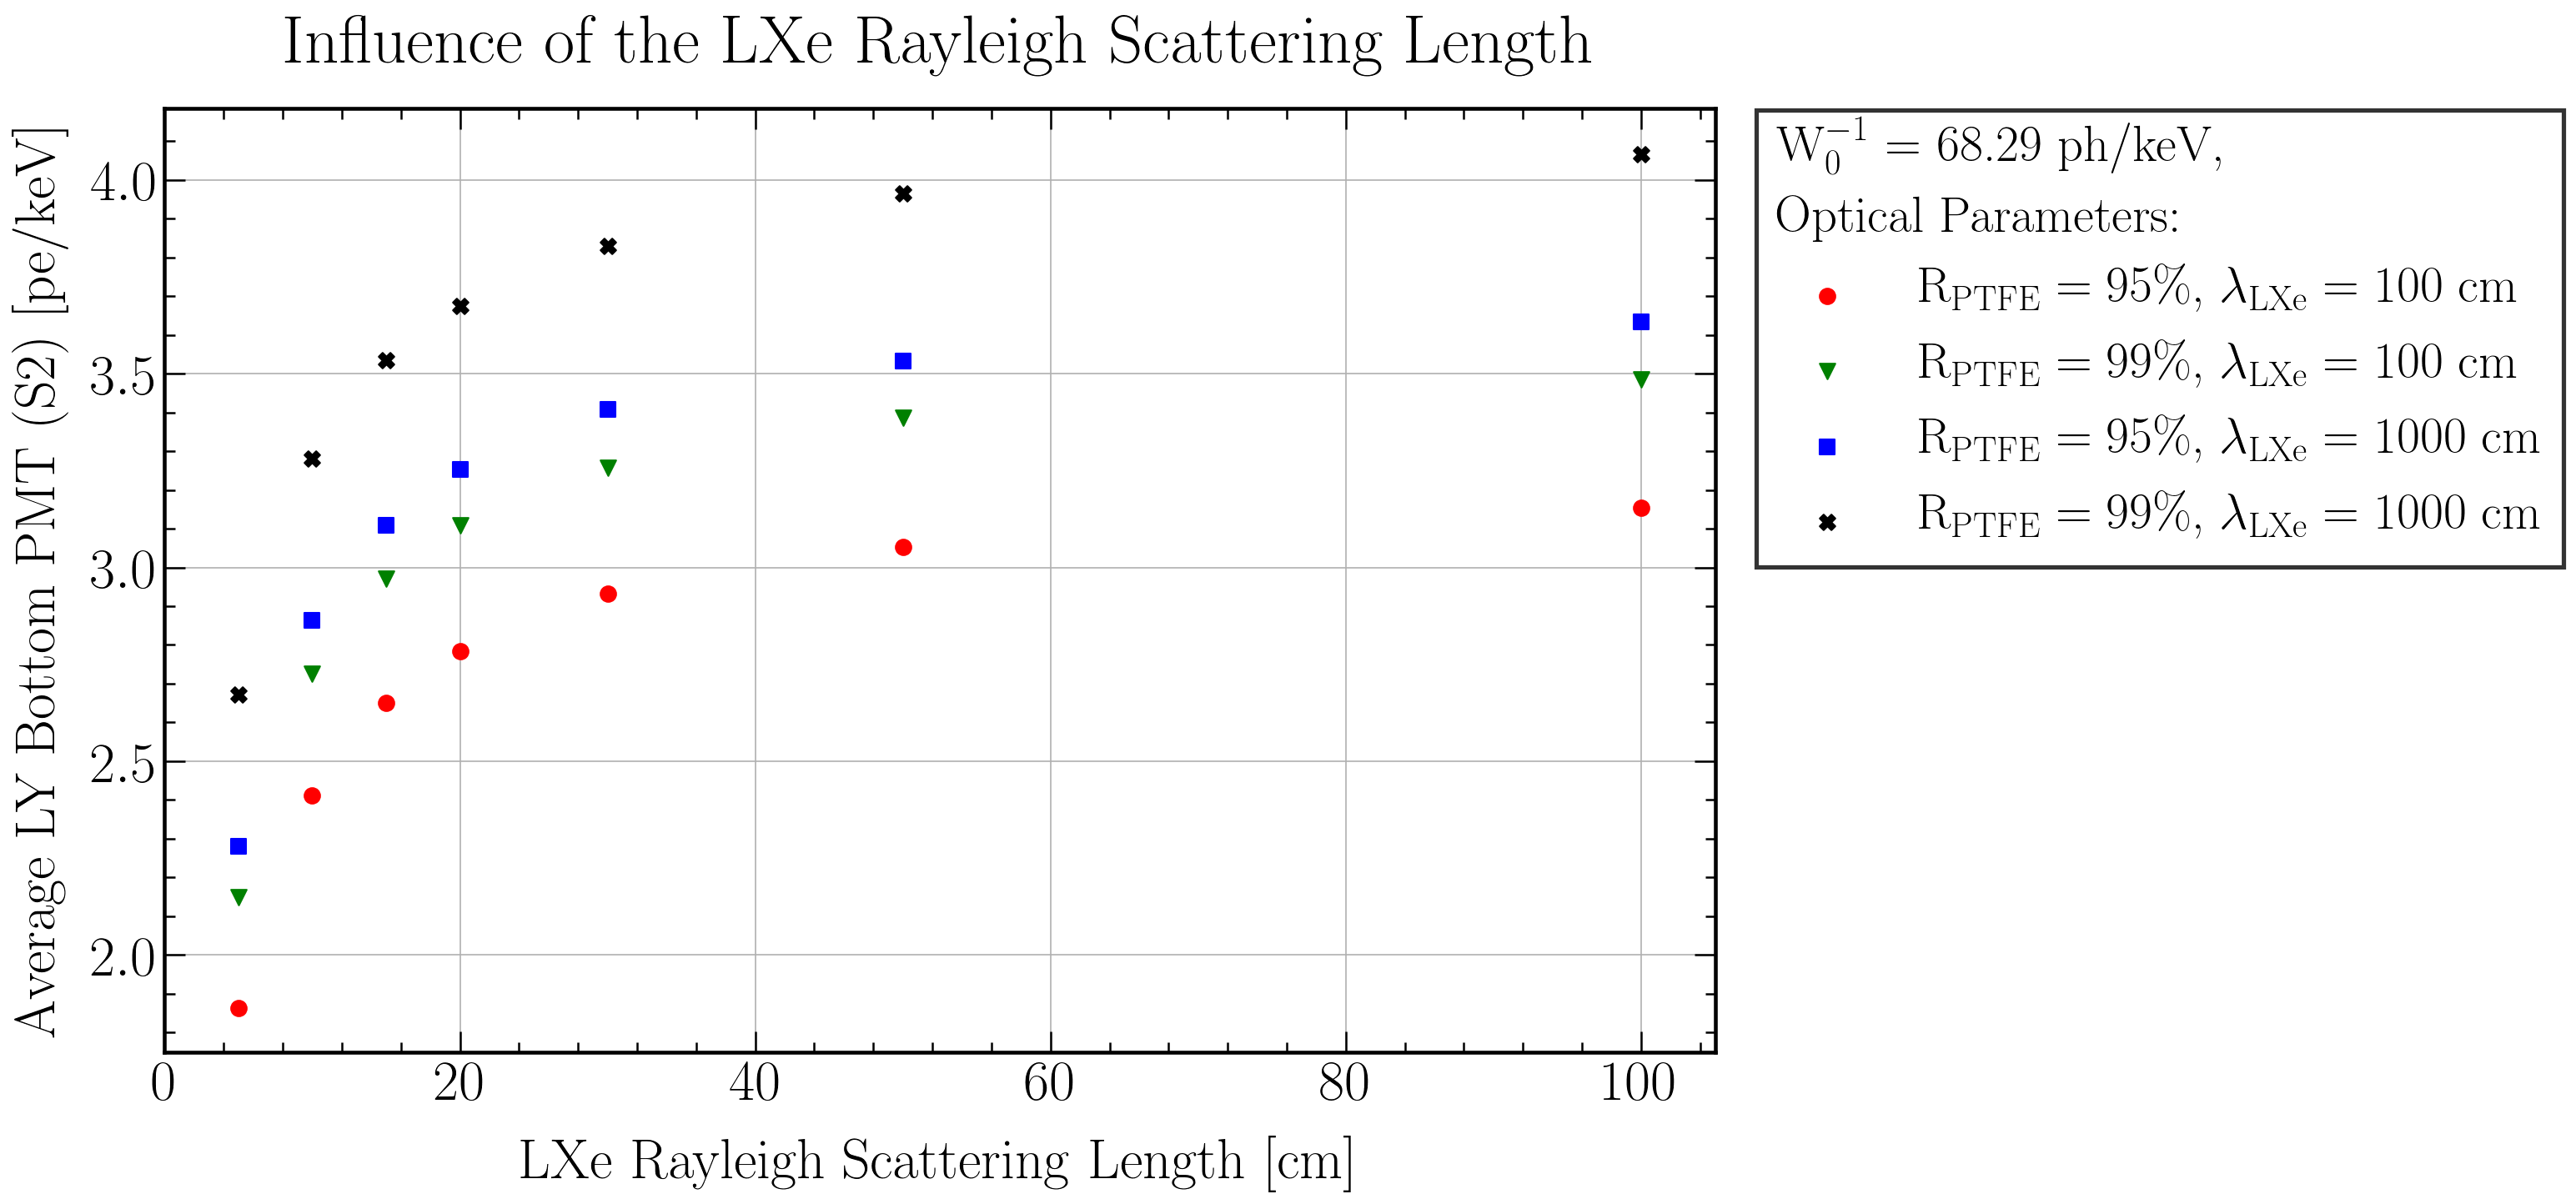

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_Bottom_S2.png", bbox_inches='tight')
plt.show()

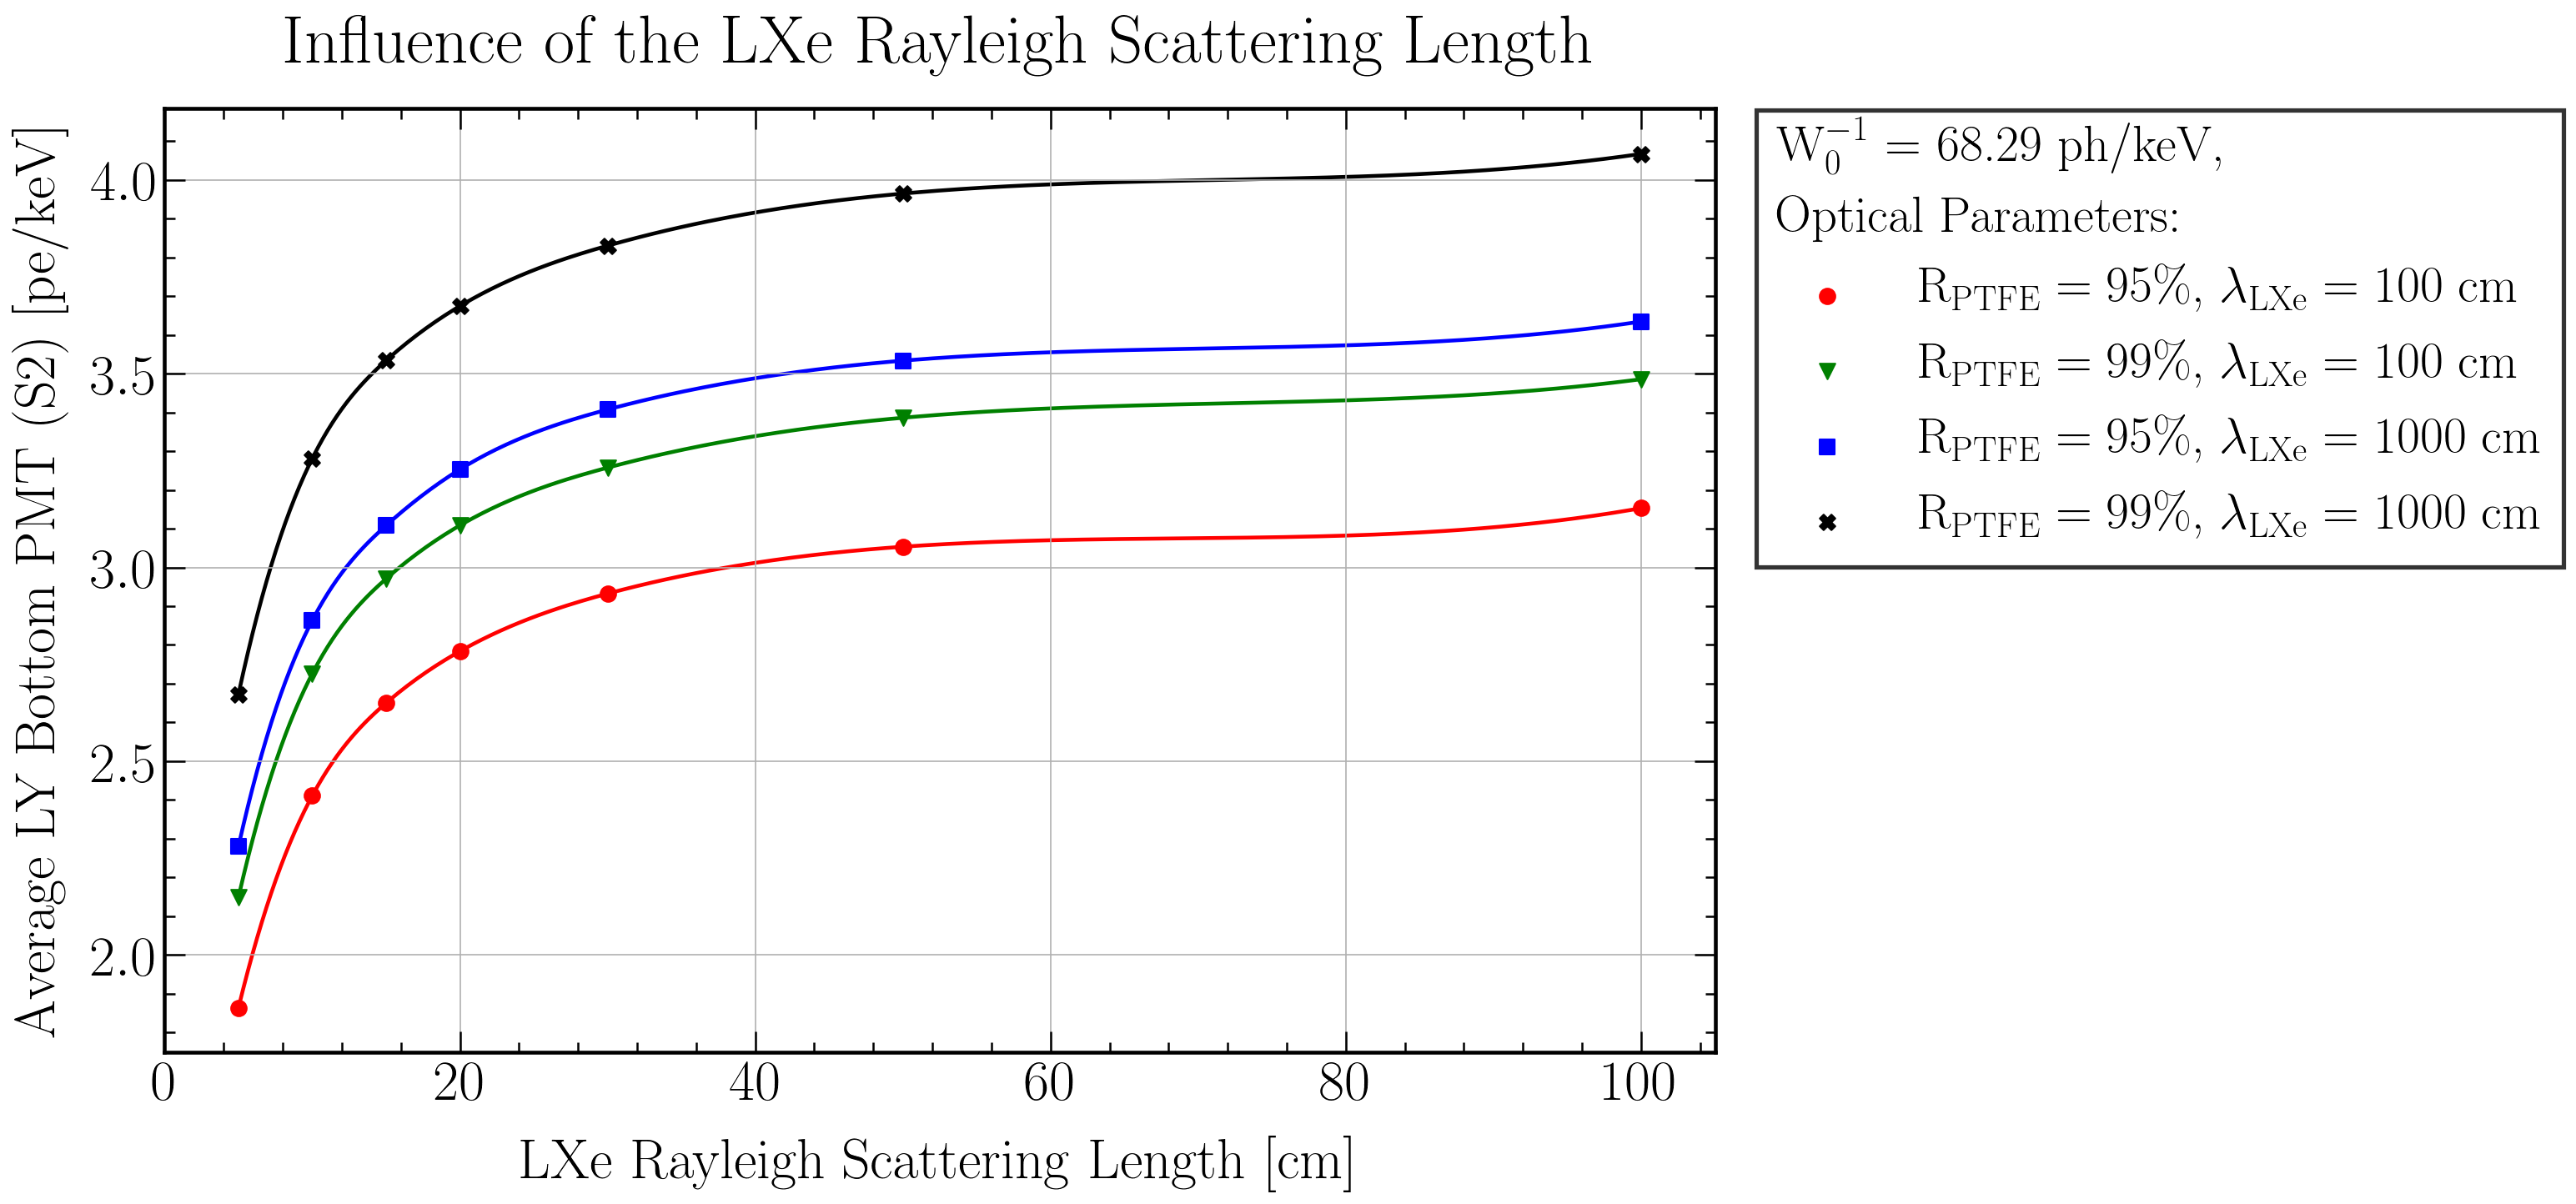

In [29]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_b"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Bottom PMT (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_Bottom_spline_S2.png", bbox_inches='tight')
plt.show()

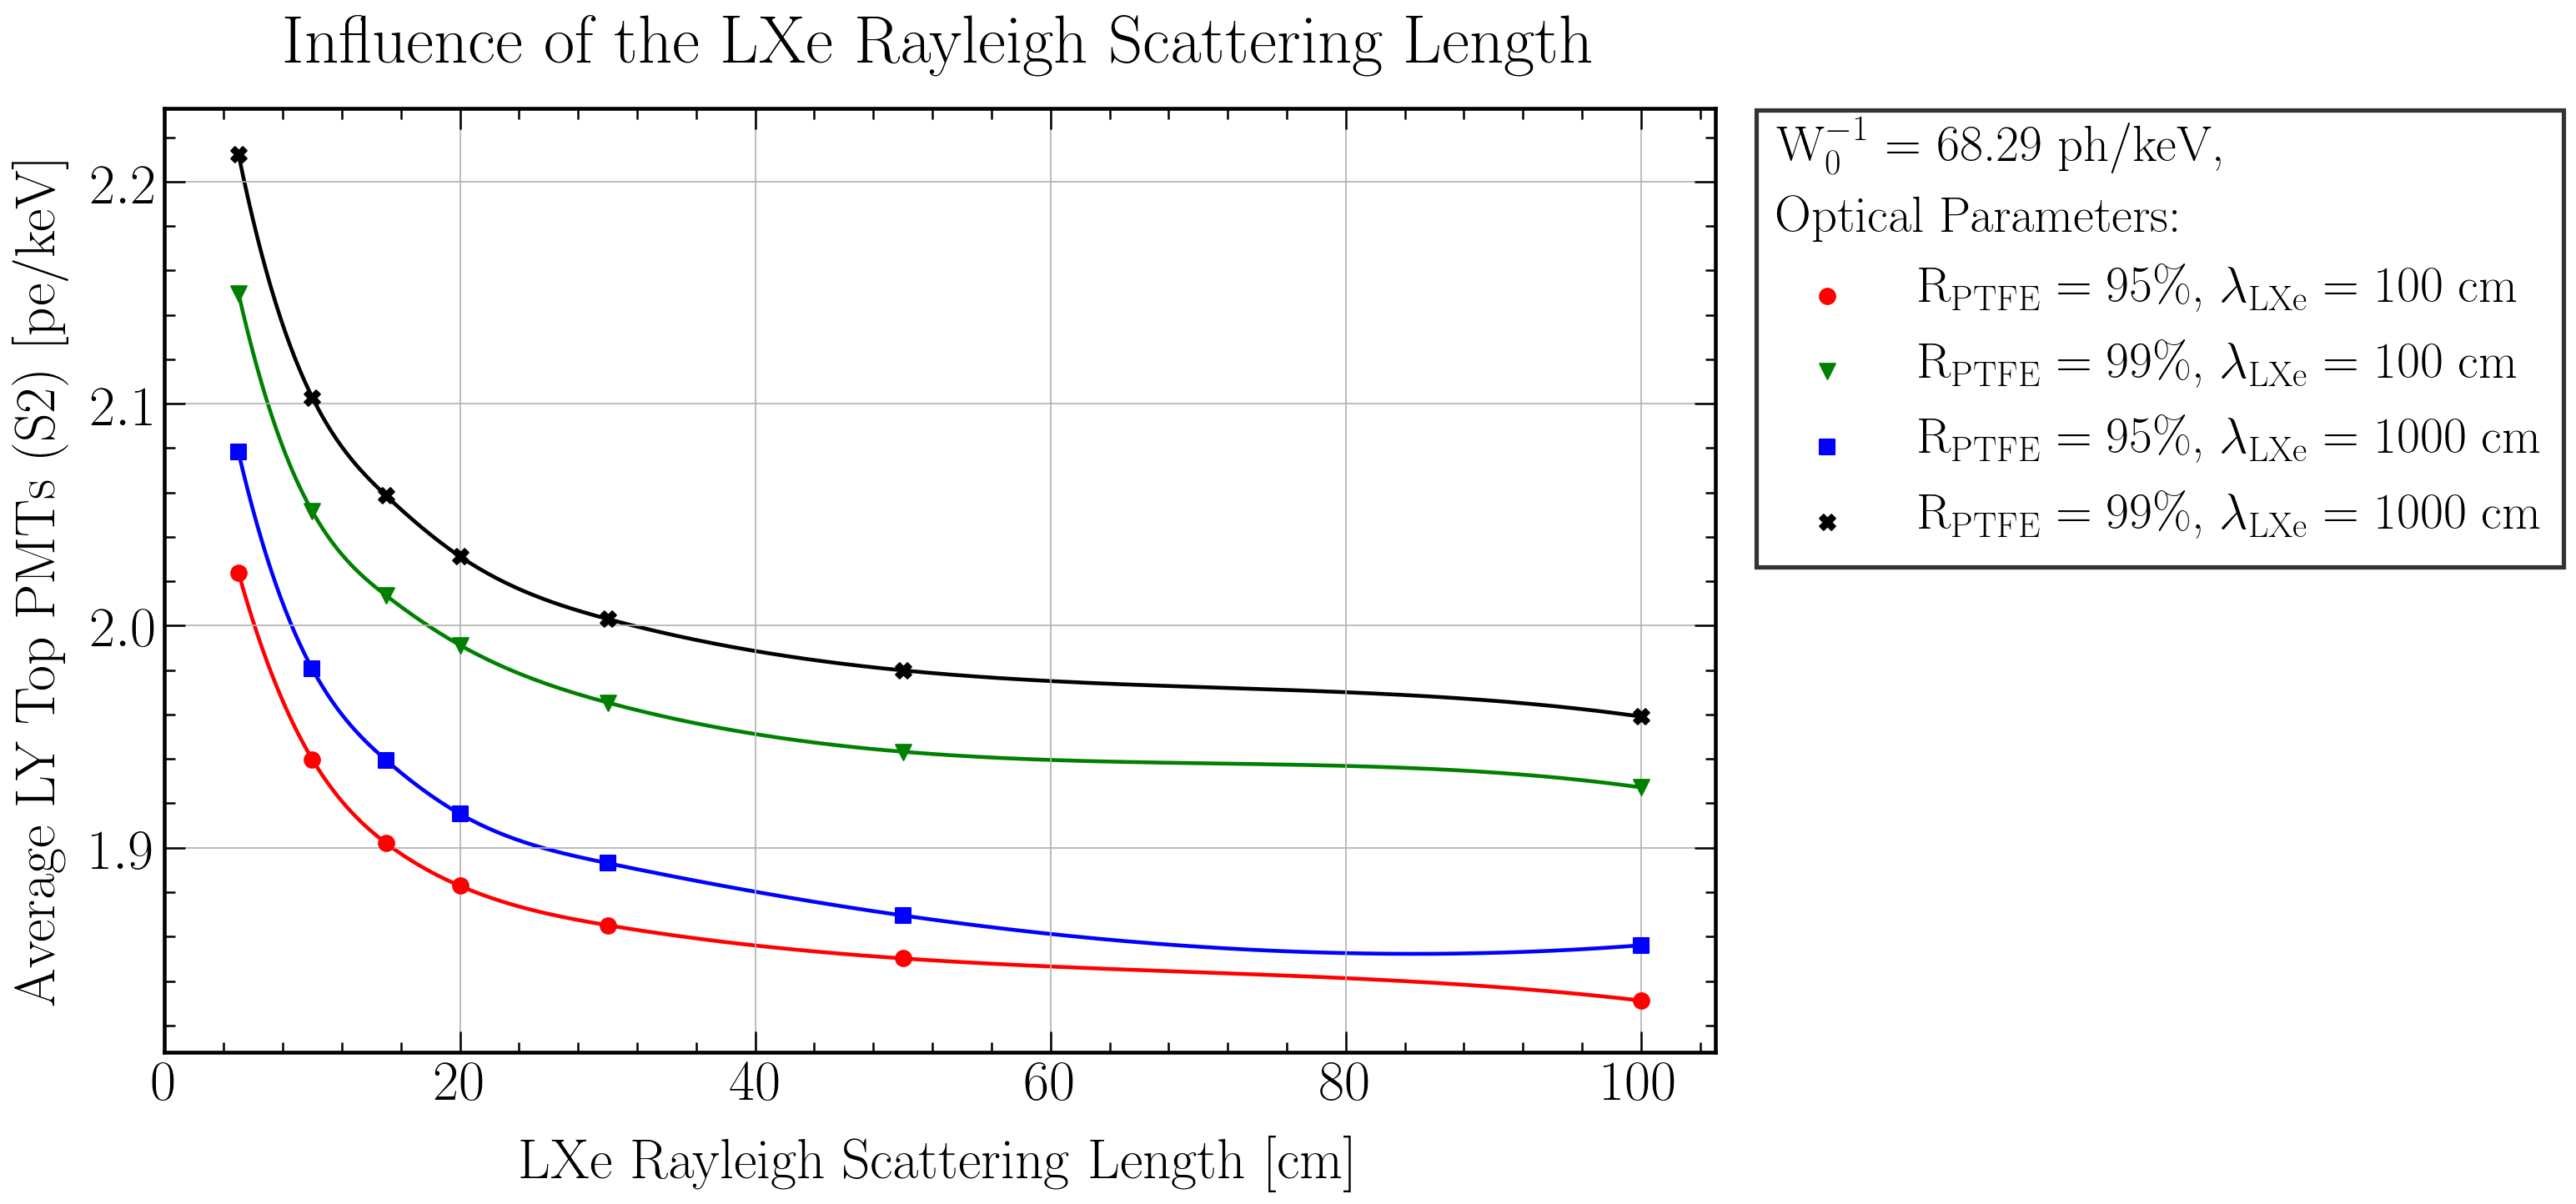

In [30]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "red", s = 80, marker="o")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'red', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
y = opticals["LY0_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 100)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 100$ cm", color = "green", s = 80, marker="v")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'green', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_t"][(opticals["RPTFE"] == 0.95) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 95 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "blue", s = 80, marker="s")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'blue', zorder=0)

x = opticals["LXeRayScatterLength"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
y = opticals["LY0_t"][(opticals["RPTFE"] == 0.99) & (opticals["LXeAbs"] == 1000)]
plt.scatter(x,y, label = "$\mathrm{R}_{\mathrm{PTFE}} = 99 \%$, $\lambda_{\mathrm{LXe}} = 1000$ cm", color = "black", s = 80, marker="X")

xr = remove_duplicate(x.values, x.values)
yr = remove_duplicate(y.values, x.values)
xnew = np.linspace(min(xr), max(xr), 300)
spl = make_interp_spline(sorted(xr), [X for Y, X in sorted(zip(xr, yr))], k=3)
ynew = spl(xnew)
plt.plot(xnew, ynew, linewidth = 2.2, color = 'black', zorder=0)

plt.xlabel('LXe Rayleigh Scattering Length [cm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Average LY Top PMTs (S2) [pe/keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Influence of the LXe Rayleigh Scattering Length', fontsize = title_size, pad = title_pad)

#plt.axvline(0.89770509, alpha=0.9, color='dimgrey', linestyle = 'dashed')

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(1.01,1.025), title="W$_0^{-1}$ = "+str(round(1/W0,2))+" ph/keV,\nOptical Parameters:", fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
leg.get_title().set_fontsize(0.9*label_size)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)
leg._legend_box.align = "left"

# Axes ---> Range
#plt.xlim(-20,520)
#plt.ylim(0,0.4)
#plt.ylim(bottom=0)
#plt.xlim(left=0)
#plt.gca().set_xscale('log')

fig.savefig("Influence_LXeRayScatterLength_LY0_Top_spline_S2.png", bbox_inches='tight')
plt.show()